# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel: 
### Topic modeling:  Dimensionsreduzierung von Rezept Namen in n Kategorien (4.Teil)

## Natural Language Processing:
### Durchgeführte Methoden:
- [Latent Dirichlet Allocation (LDA)](https://de.wikipedia.org/wiki/Latent_Dirichlet_Allocation)
- [Hierarchical Dirichlet process (HDP)](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)
- [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

## [Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation](https://www.di.ens.fr/~fbach/mdhnips2010.pdf)
## [Wang, Paisley, Blei: Online Variational Inference for the Hierarchical Dirichlet Process](http://proceedings.mlr.press/v15/wang11a/wang11a.pdf)
## [Da Kuang: Nonnegative matrix factorization for interactive topic modeling and document clustering](https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf)
## Python Implementation [1](https://radimrehurek.com/gensim/models/ldamodel.html) [2](https://github.com/bmabey/pyLDAvis)

In [1]:
!pip install stop_words
!pip install nltk
!pip3 install -U scikit-learn scipy matplotlib
!pip install seaborn
!pip install gensim
!pip install pyLDAvis

  Preparing metadata (setup.py) ... done
  DEPRECATION: stop_words is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for stop_words ... done
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached regex-2022.10.31-cp38-cp38-macosx_10_9_x86_64.whl (294 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scikit_learn-1.1.3-cp38-cp38-macosx_10_9_x86_64.whl (8.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 25.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 39.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 5.7 MB/s eta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=f8a2484297414cb64f05ea3086f69a07334adf5f7b704f0a3b02cd4ade27f94a
  Stored in directory: /Users/shu/Library/Caches/pip/wheels/62/73/dd/e1723cb4dfe5b31bf4719e640a6f9a28f488225e0af46a3514
Successfully built pyLDAvis
  DEPRECATION: sklearn is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for sklearn ... done
  DEPRECATION: future is being installed using the lega

In [2]:
import csv
import random
from operator import itemgetter

from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import TSNE
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim import corpora, models
import gensim

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
def get_recipe_names():
    recipe_names = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names.append(row[2])
            except: 
                continue 
    return(recipe_names)

def get_recipe_years():
    recipe_years = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_years.append(row[-2])
            except: 
                continue 
    return(recipe_years)

recipe_names = get_recipe_names()
print('Anzahl aller Rezeptnamen所有配方名称的数量:', len(recipe_names)) # Anzahl aller Rezeptnamen

print('20 raw recipe names: \n >>>')
pprint(recipe_names[:20])

Anzahl aller Rezeptnamen所有配方名称的数量: 316755
20 raw recipe names: 
 >>>
['Bratapfel-Rotkohl',
 '„Frühstückswolke 7“ aus Fiefhusen',
 'Deichgrafensalat von der Westküste',
 'Geschichteter Kohl',
 'Rinderlendenragout',
 'Blaukraut mit Butter-Maroni',
 'Sauerbraten à la Tick',
 'Punschtorte',
 'Gebackene Oberländer',
 'McMoes bunter Pasta-Topf "Allerlei"',
 'Geschnetzeltes mit gebratenen Radieschen',
 'Ahorn-Bacon-Butter',
 'Warmer Endiviensalat mit Mettwürstchen',
 'Rote-Linsen-Gemüse-Pfanne',
 'Kotelett-Gratin mit Pilzen und Schupfnudeln',
 'Rotkohl',
 'Remouladensauce aus Schmand',
 'Nudeln mit Cashewsauce und Tempeh "Meta-Typ Alpha"',
 'Kohlsuppe',
 'Gemüse-Hackfleischauflauf']


In [4]:
seen = set()
uniq = []
duplicates = []
for x in recipe_names:
    if x not in seen:
        uniq.append(x)
        seen.add(x)
    else: duplicates.append(x)

print('Anzahl einzigartiger Rezeptnamen唯一配方名称的数量:',len(uniq)) # Anzahl einzigartiger Rezeptnamen

duplicates.sort()

print('Anzahl Duplikate重复次数',len(duplicates))
print('20 dupliactes: \n >>>')
pprint(duplicates[:20])

Anzahl einzigartiger Rezeptnamen唯一配方名称的数量: 260907
Anzahl Duplikate重复次数 55848
20 dupliactes: 
 >>>
['24 - Stunden - Salat',
 '3 - Minuten - Brot',
 '3 - Tage - Torte',
 '3 - Tage - Torte',
 '43 Sunset',
 '5 - Minuten - Brot',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Tiramisu',
 '6 - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 Tassen - Salat',
 '7 Tassen Salat',
 'ACE-Marmelade',
 'Aachener Poschweck',
 'Aachener Printen',
 'Aachener Reisfladen',
 'Aalterrine']


# Säubern der Rezept Namen清洁配方名称

## 1. Tokenisierung Tokenize

Nur falls es nicht mit diesem Wort anfängt und der String nachher nicht leer ist仅当它不以该单词开头且之后字符串不为空时

1. replace('und ...', 'mit nichts')
2. replace('à la ...', 'mit nichts')
3. replace('von ...', 'mit nichts')
4. replace('aus ...', 'mit nichts')
5. replace('mit ...', 'mit nichts')
6. replace('ohne ...', 'mit nichts')
7. replace('in ...', 'mit nichts')
8. replace('auf ...', 'mit nichts')
9. replace('für ...', 'mit nichts')
10. replace('nach ...', 'mit nichts')
11. replace('by ...', 'mit nichts')
12. replace('zu ...', 'mit nichts')
13. replace('"..."', 'mit nichts')
14. replace('-', 'space')

In [5]:
import re
# 1
first_iter = []
regex = re.compile(r" und.*", re.IGNORECASE)
for r_name in recipe_names:
    if r_name.lower().startswith('und '):
        first_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: first_iter.append(new_name)
    else: first_iter.append(r_name)
print(len(first_iter))
# 2
sec_iter = []
regex = re.compile(r" à la.*", re.IGNORECASE)
for r_name in first_iter:
    if r_name.lower().startswith('à la '):
        sec_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sec_iter.append(new_name)
    else: sec_iter.append(r_name)
print(len(sec_iter))
# 3
third_iter = []
regex = re.compile(r" von.*", re.IGNORECASE)
for r_name in sec_iter:
    if r_name.lower().startswith('von '):
        third_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: third_iter.append(new_name)
    else: third_iter.append(r_name)
print(len(third_iter))
# 4
fourth_iter = []
regex = re.compile(r" aus.*", re.IGNORECASE)
for r_name in third_iter:
    if r_name.lower().startswith('aus '):
        fourth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fourth_iter.append(new_name)
    else: fourth_iter.append(r_name)
print(len(fourth_iter))
# 5
fifth_iter = []
regex = re.compile(r" mit.*", re.IGNORECASE)
for r_name in fourth_iter:
    if r_name.lower().startswith('mit '):
        fifth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fifth_iter.append(new_name)
    else: fifth_iter.append(r_name)
print(len(fifth_iter))
# 6
sixth_iter = []
regex = re.compile(r" ohne.*", re.IGNORECASE)
for r_name in fifth_iter:
    if r_name.lower().startswith('ohne '):
        sixth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sixth_iter.append(new_name)
    else: sixth_iter.append(r_name)
print(len(sixth_iter))
# 7
seventh_iter = []
regex = re.compile(r" in.*", re.IGNORECASE)
for r_name in sixth_iter:
    if r_name.lower().startswith('in '):
        seventh_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: seventh_iter.append(new_name)
    else: seventh_iter.append(r_name)
print(len(seventh_iter))
# 8
eigth_iter = []
regex = re.compile(r" auf.*", re.IGNORECASE)
for r_name in seventh_iter:
    if r_name.lower().startswith('auf '):
        eigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eigth_iter.append(new_name)
    else: eigth_iter.append(r_name)
print(len(eigth_iter))
# 9
ninth_iter = []
regex = re.compile(r" für.*", re.IGNORECASE)
for r_name in eigth_iter:
    if r_name.lower().startswith('für '):
        ninth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: ninth_iter.append(new_name)
    else: ninth_iter.append(r_name)
print(len(ninth_iter))
# 10
tenth_iter = []
regex = re.compile(r" nach.*", re.IGNORECASE)
for r_name in ninth_iter:
    if r_name.lower().startswith('nach '):
        tenth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: tenth_iter.append(new_name)
    else: tenth_iter.append(r_name)
print(len(tenth_iter))
# 11
eleventh_iter = []
regex = re.compile(r" by.*", re.IGNORECASE)
for r_name in tenth_iter:
    if r_name.lower().startswith('by '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eleventh_iter.append(new_name)
    else: eleventh_iter.append(r_name)
print(len(eleventh_iter))
# 12
twelveth_iter = []
regex = re.compile(r" zu.*", re.IGNORECASE)
for r_name in eleventh_iter:
    if r_name.lower().startswith('zu '):
        twelveth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twelveth_iter.append(new_name)
    else: twelveth_iter.append(r_name)
print(len(twelveth_iter))
# 13
thirteenth_iter = []
regex = re.compile(r'".*?"', re.IGNORECASE)
for r_name in twelveth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: thirteenth_iter.append(new_name)
    else: thirteenth_iter.append(r_name)
print(len(thirteenth_iter))
# remove leading and ending spaces
fourteenth_iter = []
for r_name in thirteenth_iter:
    new_name = r_name.strip()
    fourteenth_iter.append(new_name)
print(len(fourteenth_iter))
# remove all quotes
fiftheen_iter = []
for r_name in fourteenth_iter:
    new_name = r_name.replace('"', '')
    fiftheen_iter.append(new_name)
print(len(fiftheen_iter))
# 16
sixteenth_iter = []
regex = re.compile(r"'.*?'", re.IGNORECASE)
for r_name in fiftheen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: sixteenth_iter.append(new_name)
    else: sixteenth_iter.append(r_name)
print(len(sixteenth_iter))
# remove again leading and ending spaces
seventeenth_iter = []
for r_name in sixteenth_iter:
    new_name = r_name.strip()
    seventeenth_iter.append(new_name)
print(len(seventeenth_iter))
# remove all quotes '
eigththeen_iter = []
for r_name in seventeenth_iter:
    new_name = r_name.replace("'", "")
    eigththeen_iter.append(new_name)
print(len(eigththeen_iter))
# 19 remove (...)
nineteenth_iter = []
regex = re.compile(r"\(.*?\)", re.IGNORECASE)
for r_name in eigththeen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>2: nineteenth_iter.append(new_name)
    else: nineteenth_iter.append(r_name)
print(len(nineteenth_iter))
# remove -
twenteenth_iter = []
for r_name in nineteenth_iter:
    if r_name.startswith('- '):
        new_name = r_name.replace("- ", "")
        twenteenth_iter.append(new_name)
    elif r_name.startswith('-'):
        new_name = r_name.replace("-", "")
        twenteenth_iter.append(new_name)
    else: twenteenth_iter.append(r_name)
print(len(twenteenth_iter))
# remove again leading and ending spaces
twentyoneth_iter = []
for r_name in twenteenth_iter:
    new_name = r_name.strip()
    twentyoneth_iter.append(new_name)
print(len(twentyoneth_iter))
# add space around -
twentytwoth_iter = []
for r_name in twentyoneth_iter:
    new_name = r_name.replace("-", " - ")
    twentytwoth_iter.append(new_name)
print(len(twentytwoth_iter))
# 23 remove all numbers
twentytird_iter = []
regex = re.compile(r'[0-9].*?(?=\s)', re.IGNORECASE)
for r_name in twentytwoth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    twentytird_iter.append(new_name)
print(len(twentytird_iter))
# 24 remove everything but letters
twentyfourth_iter = []
regex = re.compile(r'[^A-Za-zäöüßéàèêëïùâîûç]+', re.IGNORECASE)
for r_name in twentytird_iter:
    new_name = regex.sub(' ', r_name)
    twentyfourth_iter.append(new_name)
print(len(twentyfourth_iter))
# remove again leading and ending spaces
twentyfifth_iter = []
for r_name in twentyfourth_iter:
    new_name = r_name.strip()
    twentyfifth_iter.append(new_name)
print(len(twentyfifth_iter))
# 26 remove all single letters
twentysixth_iter = []
regex = re.compile(r'(?:^| )\w(?:$| )', re.IGNORECASE)
for r_name in twentyfifth_iter:
    new_name = regex.sub(' ', r_name).strip()
    twentysixth_iter.append(new_name)
print(len(twentysixth_iter))
# 27 remove empty entries
twentyseventh_iter = []
for r_name in twentysixth_iter:
    if len(r_name) < 1: twentyseventh_iter.append('error') # just skip
    else: twentyseventh_iter.append(r_name)
print(len(twentyseventh_iter))
# 28
twentyeigth_iter = []
regex = re.compile(r" im.*", re.IGNORECASE)
for r_name in twentyseventh_iter:
    if r_name.lower().startswith('im '):
        twentyeigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twentyeigth_iter.append(new_name)
    else: twentyeigth_iter.append(r_name)
print(len(sixth_iter))

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:65: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:87: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:98: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:118: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:129: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:248: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32:

316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: sec_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: third_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: fourth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: fifth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:65: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: sixth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: seventh_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:87: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: eigth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:98: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: ninth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: tenth_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:118: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: eleventh_iter.append(new_name)


316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:129: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: twelveth_iter.append(new_name)


316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755


/var/folders/mm/_4m99mz14qn619z8qsl3rhbh0000gn/T/ipykernel_75097/3592512037.py:248: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: twentyeigth_iter.append(new_name)


316755


## Nach 28 handgefertigten Bedingungen sieht das ganze so aus经过28个手工条件，整个东西变成了这个样子:

In [6]:
print('Nach 28 handgefertigten Bedingungen sieht das ganze so aus: \n >>>')
pprint(random.sample(twentyeigth_iter, len(twentyeigth_iter))[:50])

Nach 28 handgefertigten Bedingungen sieht das ganze so aus: 
 >>>
['Pfeffernüsse',
 'Mausis Roquefort Birnen',
 'Axels geschmorte Koteletts',
 'Nutella Gugelhupf',
 'Hackfleischsauce',
 'Kartoffelsuppe',
 'Amarenatraum',
 'Chimi Churri',
 'Köstliche Schoko Cookies wie bei Millies Cookies',
 'Lasagne Giovanni',
 'Chili Cheese Fries perfekter USA Style',
 'Hähnchen',
 'Erdbeer Jogurette Eis',
 'NeriZ Breznknödel',
 'Fegato di Vitello alla Paesana',
 'Reisnudeln',
 'Windbeuteltorte',
 'Erdbeer Joghurt Schokomüsli',
 'Schokoladen Kaki Torte',
 'Zucchini Thunfischpfanne',
 'Banana Split Kuchen',
 'Steinpilz Kartoffel Gratin',
 'Mango Kokos Dessert',
 'Nuss Marmelade Muffins',
 'Pizzateig',
 'Karins Kölsche Pizza',
 'Himbeer Traum',
 'Kürbis Zucchini Tomaten Soße',
 'Nudelmuffins',
 'Abgespeckte Leberwurst',
 'Fettuccine',
 'Lamm',
 'Gefüllte',
 'Heidelbeer Traum',
 'Tea Fruit',
 'Möhrensuppe',
 'Hasenkeule',
 'Pfirsich Quark Muffins',
 'Merguez',
 'Spaghettisalat rot',
 'Rhabarber Frischkäs

## 2. Stoppwörter entfernen und Stammformreduktion

Unwichtige Wörter wie *welche*, *sich*, *manches*, *einige* etc. entfernen und Wörter auf ihren Wortstamm reduzieren.
删除停用词和词干形式缩减¶
删除不重要的单词，例如 which、self、some、some 等，并将单词缩减到词根。

In [7]:
de_stop = get_stop_words('german')
s_stemmer = SnowballStemmer('german')
tokenizer = RegexpTokenizer(r'\w+')
final_names = []
filter_words_ = ['low carb',
               'vegane', 
               'smokeys',
               'schnelle',
               'schneller',
               'single',
               'veganer',
               'überbackene',
               'bunter',
               'gebratene',
               'grüner',
               'grünes', 
               'vegetarische',
               'italienisch',
               'scharfe',
               'krümeltigers',
               'pfanne',
               'mini',
               'warmer',
               'gefüllt',
               'gefüllte',
               'pikante',
               'schnelles',
               'rezept',
               'dessert',
               'bunte',
               'gebackene',
               'feierabend',
               'omas',
               'topf',
               'mediterrane',
               'mal',
               'saftig',
               'mediterraner',
               'saftiger',
               'saftiges',
                 'nr',
                 'abendessen',
                 'achims']

for recipe_name in twentyeigth_iter:
    raw = recipe_name.lower()
    tokens = tokenizer.tokenize(raw)
    stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop and not recipe_name in filter_words_]
    stem_t = [i for i in stop_t if len(i)>1]
    if len(stem_t)==0: final_names.append(['error'])
    else: final_names.append(stem_t)

print('Fertig gesäuberte Rezeptnamen: \n >>>')
pprint(final_names[:20])

Fertig gesäuberte Rezeptnamen: 
 >>>
[['bratapfel', 'rotkohl'],
 ['frühstückswolke'],
 ['deichgrafensalat'],
 ['geschichteter', 'kohl'],
 ['rinderlendenragout'],
 ['blaukraut'],
 ['sauerbraten'],
 ['punschtorte'],
 ['oberländer'],
 ['mcmoes', 'pasta'],
 ['geschnetzeltes'],
 ['ahorn', 'bacon', 'butter'],
 ['endiviensalat'],
 ['rote', 'linsen', 'gemüse'],
 ['kotelett', 'gratin'],
 ['rotkohl'],
 ['remouladensauce'],
 ['nudeln'],
 ['kohlsuppe'],
 ['gemüse', 'hackfleischauflauf']]


In [8]:
print(len(final_names))
print(len(twentyeigth_iter))

316755
316755


In [9]:
sorted(final_names)[:20]

[['aachener', 'feuerzangenbowle'],
 ['aachener', 'poschweck'],
 ['aachener', 'poschweck'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen', 'ii'],
 ['aachener', 'printen', 'iii'],
 ['aachener', 'printen', 'schichtspeise'],
 ['aachener', 'printenauflauf'],
 ['aachener', 'reisfladen'],
 ['aachener', 'reisfladen'],
 ['aachener', 'suppe'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal']]

# Topic Modeling

## Versuch 1: Latent Dirichlet Allocation (LDA) mit 50 Topics

In [10]:
dictionary = corpora.Dictionary(final_names)
# save dictionary
#dictionary.save('input/test/topic_modeling_dictionary_2.dict')
corpus = [dictionary.doc2bow(text) for text in final_names]
# save corpus
#corpora.MmCorpus.serialize('input/test/corpus_2_lda.mm', corpus)

In [11]:
print(dictionary)

Dictionary<60477 unique tokens: ['bratapfel', 'rotkohl', 'frühstückswolke', 'deichgrafensalat', 'geschichteter']...>


In [12]:
%%time
# generate LDA model
ldamodel = models.LdaMulticore(corpus=corpus, num_topics=50, id2word = dictionary)
ldamodel.save('input/test/kategorien_50_60477_lda.model')

CPU times: user 11.6 s, sys: 7.65 s, total: 19.2 s
Wall time: 29.3 s


In [14]:
# ldamodel = models.ldamodel.LdaModel.load('input/test/kategorien_50_60477_lda.model')

In [15]:
ldamodel.print_topics()

[(39,
  '0.238*"risotto" + 0.087*"vollkorn" + 0.060*"geflügel" + 0.033*"thymian" + 0.026*"teig" + 0.019*"drei" + 0.010*"helles" + 0.002*"apfel" + 0.001*"butterspritzgebäck" + 0.001*"muffins"'),
 (27,
  '0.226*"dip" + 0.118*"auberginen" + 0.117*"alla" + 0.076*"rucola" + 0.050*"melonen" + 0.044*"carbonara" + 0.032*"erdbeer" + 0.015*"strawberry" + 0.012*"salat" + 0.011*"kohlsuppe"'),
 (13,
  '0.343*"joghurt" + 0.066*"dinkel" + 0.055*"sellerie" + 0.038*"vollkornbrot" + 0.030*"frucht" + 0.028*"karotten" + 0.026*"tomaten" + 0.022*"eintopf" + 0.017*"pflaumenmus" + 0.011*"rettich"'),
 (20,
  '0.342*"salat" + 0.183*"gemüse" + 0.109*"rote" + 0.065*"walnuss" + 0.065*"bete" + 0.042*"brownies" + 0.016*"karotten" + 0.011*"fenchel" + 0.009*"kirsch" + 0.006*"apfel"'),
 (12,
  '0.613*"spaghetti" + 0.033*"asiatisch" + 0.029*"rotes" + 0.005*"klassisches" + 0.005*"angehauchte" + 0.002*"thai" + 0.002*"curry" + 0.002*"alla" + 0.001*"il" + 0.001*"kartoffel"'),
 (46,
  '0.400*"tomaten" + 0.112*"lauch" + 0.064

## Visualisieren des LDA Model mit [pyLDAvis](https://github.com/bmabey/pyLDAvis)

In [16]:
vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Interaktive Graphik交互式图形

In [17]:
pyLDAvis.display(vis_data)

In [18]:
# from IPython.display import Image
# PATH = "/Users/Muriz/Desktop/"
# Image(filename = PATH + "topic.png", width='60%', height=140)

Mit einem kurzen Skript können zusammenhängende Rezepte zu einem Begriff ausgegeben werden.

In [19]:
def get_related_recipes(term, top):
    print(">>>>>",top," top recipes related to ",term,"<<<<<<")
    related_docid = []
    doc_topics = ldamodel.get_document_topics(corpus, minimum_probability=0.10)
    term_topics =  ldamodel.get_term_topics(term, minimum_probability=0.000001)
    for k,topics in enumerate(doc_topics):
        if topics:
            topics.sort(key = itemgetter(1), reverse=True)
            if topics[0][0] == term_topics[0][0]:
                related_docid.append((k,topics[0][1]))
    
    related_docid.sort(key = itemgetter(1), reverse=True)
    for j,doc_id in enumerate(related_docid):
        print(final_names[doc_id[0]],"\n",doc_id[1],"\n")
        if j == (top-1):
            break


苹果

In [20]:
get_related_recipes('apfel', 10)

>>>>> 10  top recipes related to  apfel <<<<<<
['fish', 'chips', 'englische', 'fast', 'food', 'einfach', 'selbstgemacht'] 
 0.87749547 

['panna', 'cotta', 'con', 'salsa', 'di', 'fragole'] 
 0.8366646 

['fusilli', 'con', 'frutti', 'di', 'mare'] 
 0.8366632 

['involtini', 'di', 'melanzane', 'con', 'salsa', 'di', 'pomodoro'] 
 0.83666044 

['amerikanische', 'blaubeeren', 'streusel', 'muffins', 'bekannten', 'amerikanischen', 'kaffee', 'kette'] 
 0.7854664 

['lasagne', 'di', 'funghi', 'finocchio', 'con', 'salsa', 'di', 'pomodoro'] 
 0.7596918 

['schokolade', 'bananen', 'muffins'] 
 0.7549995 

['salsa', 'di', 'semi', 'di', 'papavero'] 
 0.754999 

['frutti', 'di', 'mare', 'herbe'] 
 0.75499696 

['frutti', 'di', 'mare'] 
 0.75499696 



We can see that himbeer覆盆子 and apfel 苹果 are belonging to one topic.

# Versuch 2
## Hierarchical Dirichlet Process

### Der Unterschied zu LDA besteht hier, das mit HDP keine Anzahl von Topics von vornherein bestimmt werden muss. Die Anzahl empfohlener Topics wird beim Lauf selbst bestimmt. Mit Parameter T kann man bestimmen, wie viele Topics mindestens berechnet werden müssen.
分层狄利克雷过程
与 LDA 的不同之处在于，使用 HDP，无需从一开始就确定主题的数量。推荐主题的数量是在运行过程中确定的。 T 参数可用于确定至少必须计算多少个主题。

In [21]:
%%time
# generate HDP model
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=20) # I tried 20, 50, 100 and the results are almost the same
hdp.save('input/test/kategorien_hdp_new.model')

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/

CPU times: user 8min 32s, sys: 11.1 s, total: 8min 43s
Wall time: 9min 31s


In [22]:
hdp = models.hdpmodel.HdpModel.load('input/test/kategorien_hdp_new.model')

In [23]:
hdp.print_topics()[:10]

[(0,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (1,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.002*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (2,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (3,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.002*kartoffel + 0.001*spaghetti + 0.001*schoko + 0.001*tomaten + 0.001*gemüse'),
 (4,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.002*kartoffel + 0.001*spaghetti + 0.001*schoko + 0.001*tomaten + 0.001*gemüse'),
 (5,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.002*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (6,
  '0.003*sa

## Auch hier kann man das Ergebnis visualisieren
您还可以在此处可视化结果

In [24]:
vis_data_hdp = gensimvis.prepare(hdp, corpus, dictionary)

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [25]:
pyLDAvis.display(vis_data_hdp)

### Der Versuch mit HDP liefert leider schlechte Ergebnisse. Viele Kategorien überlappen sich stark, z.B. Salat, Torte, Kuchen und Apfel sind die Top-Ergebnisse in fast jedem Topic. Das Ergbniss von HDP wird nicht in Betrachtung gezogen.
不幸的是，对 HDP 的尝试带来了糟糕的结果。许多类别重叠严重，例如沙拉、馅饼、蛋糕和苹果几乎在每个主题中都是最佳结果。不考虑HDP的结果

# Versuch 3
## Non-negative Matrix Factorization

In [83]:
# rezepte_csv_analysis = pd.read_csv('input/test/chefkoch_rezepte_analysis.csv')
# rezepte_csv_analysis.head(2) # zeige erste zwei zeilen

Unnamed: 0         recipe_id                        recipe_name  \
0           0  3449791514066439                  Bratapfel-Rotkohl   
1           1  3449721514056932  „Frühstückswolke 7“ aus Fiefhusen   

   average_rating stars_shown  votes difficulty  preparation_time        date  \
0             2.5         unb    0.0     normal              45.0  2017-12-24   
1             2.5         unb    0.0    pfiffig              15.0  2017-12-24   

  has_picture  
0          no  
1          no

### Zuerst wird eine zusätzliche Spalte hinzugefügt zur  chefkoch_rezepte_analysis.csv Datei mit dem 'sauberen' Namen.

In [85]:
# rezepte_csv_analysis.drop(rezepte_csv_analysis.columns[[0, 3, 4, 5, 6, 7, 9]], axis=1, inplace=True)
# rezepte_csv_analysis['date'] = pd.to_datetime(rezepte_csv_analysis['date'])
# rezepte_csv_analysis['year']=rezepte_csv_analysis.date.dt.year
# rezepte_csv_analysis['clean_name'] = data_samples
# rezepte_csv_analysis.head(2)
# rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_cleannames.csv')

In [26]:
rezepte_csv_analysis=pd.read_csv('input/test/chefkoch_rezepte_analysis_cleannames.csv')

### 3.1 Non-negative Matrix Factorization:

In [27]:
n_topics = 300  #can we change this topic number to 30?
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:10]): # just show first 10 topics
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [28]:
data_samples = [' '.join(ti) for ti in final_names]
print(len(data_samples))

316755


In [29]:
sorted(data_samples)[:20]

['aachener feuerzangenbowle',
 'aachener poschweck',
 'aachener poschweck',
 'aachener printen',
 'aachener printen',
 'aachener printen',
 'aachener printen ii',
 'aachener printen iii',
 'aachener printen schichtspeise',
 'aachener printenauflauf',
 'aachener reisfladen',
 'aachener reisfladen',
 'aachener suppe',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal']

## Insgesamt wurden 2 Modelle berechnet:
1. Mit 250 Kategorien auf meiner lokalen Hardware
2. Mit 300 Kategorien auf einer [Amazon EC2-Instanz](https://aws.amazon.com/de/ec2/instance-types/) berechnet, da mein lokaler PC nicht mit genügend schneller Hardware ausgestattet ist.

In [30]:
%%time
# tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Extracting tf-idf features for NMF...
CPU times: user 1.91 s, sys: 66.5 ms, total: 1.98 s
Wall time: 2.06 s


/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Erste Einblicke: Ranking der grössten TF-IDF Werte im Dokument

In [31]:
import operator
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [32]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate(ranking[0:50]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

01. salat (2935.18)
02. spaghetti (2429.36)
03. torte (2196.21)
04. kuchen (1970.08)
05. nudeln (1856.08)
06. muffins (1823.38)
07. apfel (1679.88)
08. kartoffel (1651.78)
09. tomaten (1628.55)
10. schoko (1520.09)
11. gemüse (1464.49)
12. nudelsalat (1421.97)
13. hähnchen (1358.69)
14. suppe (1306.70)
15. paprika (1301.66)
16. curry (1271.75)
17. pasta (1189.32)
18. zucchini (1179.31)
19. erdbeer (1164.30)
20. bananen (1150.77)
21. käse (1146.86)
22. apfelkuchen (1133.69)
23. lachs (1055.75)
24. spargel (1030.62)
25. schweinefilet (1022.06)
26. käsekuchen (1010.36)
27. kartoffelsalat (965.17)
28. kokos (954.14)
29. error (944.00)
30. quark (932.04)
31. reis (908.07)
32. auflauf (882.07)
33. kürbis (870.52)
34. joghurt (858.62)
35. sauce (849.17)
36. rote (837.60)
37. kirsch (826.79)
38. nudelauflauf (821.69)
39. creme (806.50)
40. pizza (803.71)
41. orangen (795.90)
42. lasagne (788.46)
43. himbeer (780.59)
44. dip (779.24)
45. spinat (750.39)
46. möhren (742.89)
47. sahne (729.83)
48

In [33]:
# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, verbose=2, max_iter=5).fit(tfidf)
print()

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


violation: 1.0
violation: 0.018565269411167436
violation: 0.007817644440549082


/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/

violation: 0.005119904174260631
violation: 0.0028764086484659736


/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


In [34]:
import os
os.makedirs('input/test/topic_modeling/',exist_ok=True)
joblib.dump(nmf, 'input/test/topic_modeling/nmf_allfeat_100000samp_300topic.pkl')
nmf_300 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_300topic.pkl')

In [35]:
# saving NMF model
#joblib.dump(nmf, 'input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

In [36]:
# loading NMF 250 cat model
#nmf_250 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

In [42]:
# loading NMF 300 cat model
#nmf_300 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic_cloud.pkl')

## Mittelmässige Ergebnisse liefert das 1. NMF model:

In [43]:
#print_top_words(nmf_250, tfidf_feature_names, 5)

## Ausgezeichnete Ergebnisse liefert das 2. NMF model:

In [44]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_300, tfidf_feature_names, 10) # just show first 10 topics

Topic #0:
spaghetti carbonara olio aglio al sabo di puttanesca mare nester
Topic #1:
salat gemischter melonen chicoree bulgur radieschen sellerie quinoa lauwarmer matjes
Topic #2:
nudeln chinesische asia mie wok udon schwarze leichte china parmesan
Topic #3:
muffins blaubeer cranberry herzhafte saftige streusel chocolate haferflocken erdnussbutter mohn
Topic #4:
nudelsalat leichter sommerlicher scharfer chinesischer asiatischer mediterran sommer roter vegetarischer
Topic #5:
tomaten oliven salsa basilikum aufstrich getrocknete ciabatta gratinierte geschmorte sahnesoße
Topic #6:
torte philadelphia linzer raffaello baiser maracuja mokka buttercreme giotto stracciatella
Topic #7:
kuchen streusel mohn nuss baiser zwetschgen buttermilch grieß schmand marmor
Topic #8:
pasta one pot asciutta al alla sommerliche fagioli cremige gorgonzola
Topic #9:
hähnchen spieße scharfes cordon bleu mariniertes tandoori saté geschmortes überbackenes



/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Tfidf-Matrix zu NMF-Embedding

In [45]:
nmf_embedding = nmf_300.transform(tfidf)
#nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


violation: 1.0
violation: 0.005005575517930899
violation: 0.0005290616488602933
violation: 0.00014832596229426038
violation: 6.968016914205698e-05
Converged at iteration 6


/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


# Resultat

## Die Matrize *nmf_embedding* enthält nun das gesuchte, vermutete Verhältnis zwischen Rezeptname und Kategorie. Für jedes Rezept der 316'755 Rezepte findet man die Gewichte, je höher desto stärker mit der Kateogrie assoziiert.

nmf_embedding 矩阵现在包含搜索到的、假定的配方名称和类别之间的关系。对于 316,755 种食谱中的每一种，您都可以找到权重，权重越高，与类别的关联度越高

In [46]:
nmf_embedding.shape

(316755, 300)

### Zum Beispiel:
#### Der 11. Rezeptname ist Geschnetzeltes mit gebratenen Radieschen. Welcher Kategorie der 300 gehört dieses Rezept an?

In [40]:
recipe_names[10:11]

['Geschnetzeltes mit gebratenen Radieschen']

### Ergebnis: Das Modell ist sich mit 0.13 sicher, dass es zur 74. Kategorie angehört.

In [41]:
nmf_embedding[10,:].round(2)

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

Tatsächlich ist der Name der 74 Kategorie *geschnetzeltes* und damit liegt das Model richtig.

In [127]:
# topics_category_300[73]

# Das Spiel umdrehen

## Wie sieht es aber aus, wenn man eine Kategorie zu einem bestimmten String sucht?
扭转局势
但是，如果您正在寻找特定字符串的类别，它会是什么样子呢？

In [47]:
nmf_300.components_.shape

(300, 60477)

## Als Test gibt man 'carbonara' an.

In [48]:
term_index = tfidf_feature_names.index('carbonara')
nmf_300.components_[:,term_index].round(2)

array([0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

## Am sichersten ist es, dass es zur ersten Kategorie gehören muss.
## Überprüfung: 1. Kategorie ist:它必须属于第一类，这是最安全的。
验证：第一类是：

In [49]:
# topics_category_300[0]

spaghetti und carbonara passt!

## Top 300 Vorschläge vom 2. NFM Model für Kategorien:

##### Kleiner Ausschnit (10 Kategorien)
## 来自第二个 NFM 模型的前 300 个类别建议：

##### 小摘录（10类）

In [50]:
top_idx = np.argsort(nmf_embedding,axis=0)[-1:]
show_ten = 10
count_idxs = 0
for idxs in top_idx.T:
    if count_idxs == show_ten: break
    print("\nTopic {}:".format(count_idxs))
    for idx in idxs:
        print(final_names[idx])
    count_idxs += 1


Topic 0:
['spaghetti']

Topic 1:
['salat']

Topic 2:
['nudeln']

Topic 3:
['muffins']

Topic 4:
['nudelsalat']

Topic 5:
['tomaten']

Topic 6:
['torte']

Topic 7:
['kuchen']

Topic 8:
['pasta']

Topic 9:
['hähnchen']


In [51]:
len(top_idx.T)

300

In [52]:
count_idxs = 0
for idxs in top_idx.T:
    words = []
    for idx in idxs:
        words.extend(final_names[idx])
    with open('input/test/categories_300.txt', 'a') as the_file:
        the_file.write(str(' '.join(words)+'\n'))
    count_idxs += 1

### Die Kategorien für die 300 empfohlenen Topics müssen manuell ausgewertet werden. Die fertige Liste mit 300 Kategorien findet sich unter *input/test/categories_300.txt*
### 300 个推荐主题的类别必须手动评估。包含 300 个类别的完成列表可以在 *input/test/categories_300.txt* 下找到

In [53]:
topics_category_300 = []
cat_file = open('input/test/categories_300.txt', 'r')
cat_file_lines = cat_file.readlines()
for line in cat_file_lines:
    topics_category_300.append(line.strip())

In [54]:
topics_category_300[:10]

['spaghetti',
 'salat',
 'nudeln',
 'muffins',
 'nudelsalat',
 'tomaten',
 'torte',
 'kuchen',
 'pasta',
 'hähnchen']

### Die am übereinstimmensten Rezepte für Kategorie:
### 类别最匹配的食谱：

In [55]:
def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] # umdrehen
    top_result = [] # return result as list
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

### Beispiel: die besten Rezepte für Kategorie Spaghetti (1. Kategorie)示例：类别意大利面（第 1 类别）的最佳食谱

In [56]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 0, 10)

In [57]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Spaghetti nach italienischer Art
02. Spaghetti mit Wirsingpesto
03. Spaghetti mit Basilikumpesto
04. Spaghetti mit zwei Soßen
05. Spaghetti mit Paprika - Tomaten - Püree und Rinderfiletstreifen
06. Spaghetti mit Wirsing und Schafskäse
07. Spaghetti in Thymianrahm mit Cocktailtomaten
08. Spaghetti mit Pfirsich - Ingwer Sauce
09. Spaghetti  mit Chili und Knoblauch nach Chris
10. Spaghetti mit Ziegenkäse und Zucchini


### Beispiel: die besten Rezepte für Kategorie Paprika (15. Kategorie)示例：类别辣椒的最佳食谱（第 15 类）

In [58]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 14, 10)

In [59]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Gefüllte Paprika
02. Gefüllte Paprika auf frischer Tomatensauce
03. Gefüllte Paprika
04. Gefüllte Paprika mit Tomatenmatsch
05. Gefüllte Paprika
06. Gefüllte Paprika mit Chili con Carne
07. Paprika mit Thunfisch
08. Gefüllte Paprika mit Hackfleisch
09. Paprika - Ingwer - Sauce
10. Gefüllte Paprika in Alufolie


### Die am übereinstimmenste Kategorie für ein Rezept:食谱最匹配的类别：

In [60]:
def get_top_cat_for_recipe(recipes_all_list, w_vector):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: final_recipes_cat_name.append('no_cat')
        else: final_recipes_cat_name.append(topics_category_300[num])
    return final_recipes_cat_name

In [61]:
categories_for_recipes = get_top_cat_for_recipe(recipe_names, nmf_embedding)

In [62]:
count_no_cat = 0
for recipe_s in categories_for_recipes:
    if recipe_s == 'no_cat': count_no_cat+=1
print('Für {} Rezepte wurde keine Kategorie festgestellt'.format(count_no_cat))

Für 129240 Rezepte wurde keine Kategorie festgestellt


## Die passende Kategorie als Spalte hinzufügen:添加适当的类别作为列：

In [63]:
rezepte_csv_analysis.head()

Unnamed: 0         recipe_id                         recipe_name  \
0           0  3449791514066439                   Bratapfel-Rotkohl   
1           1  3449721514056932   „Frühstückswolke 7“ aus Fiefhusen   
2           2  3449701514054063  Deichgrafensalat von der Westküste   
3           3  3449651514047893                  Geschichteter Kohl   
4           4  3449681514052511                  Rinderlendenragout   

         date  year          clean_name  
0  2017-12-24  2017   bratapfel rotkohl  
1  2017-12-24  2017     frühstückswolke  
2  2017-12-24  2017    deichgrafensalat  
3  2017-12-24  2017  geschichteter kohl  
4  2017-12-24  2017  rinderlendenragout

In [64]:
rezepte_csv_analysis['category'] = categories_for_recipes

In [65]:
rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_with_category.csv')

In [66]:
rezepte_csv_analysis.head(10)

Unnamed: 0         recipe_id                          recipe_name  \
0           0  3449791514066439                    Bratapfel-Rotkohl   
1           1  3449721514056932    „Frühstückswolke 7“ aus Fiefhusen   
2           2  3449701514054063   Deichgrafensalat von der Westküste   
3           3  3449651514047893                   Geschichteter Kohl   
4           4  3449681514052511                   Rinderlendenragout   
5           5  3449481514034645          Blaukraut mit Butter-Maroni   
6           6  3449641514047091                Sauerbraten à la Tick   
7           7  3449571514042406                          Punschtorte   
8           8  3449471514033424                 Gebackene Oberländer   
9           9  3449241513953107  McMoes bunter Pasta-Topf "Allerlei"   

         date  year          clean_name   category  
0  2017-12-24  2017   bratapfel rotkohl  bratapfel  
1  2017-12-24  2017     frühstückswolke     no_cat  
2  2017-12-24  2017    deichgrafensalat     no_cat  
3  2017-12-24  2017  geschichteter kohl       hack  
4  2017-12-24  2017  rinderlendenragout     no_cat  
5  2017-12-24  2017           blaukraut     no_cat  
6  2017-12-24  2017         sauerbraten     no_cat  
7  2017-12-24  2017         punschtorte     no_cat  
8  2017-12-24  2017          oberländer     no_cat  
9  2017-12-23  2017        mcmoes pasta      pasta

In [67]:
rezepte_csv_analysis[rezepte_csv_analysis.category!='no_cat'].shape

(187515, 7)

In [68]:
rezepte_csv_analysis[rezepte_csv_analysis.category=='no_cat'].shape

(129240, 7)

In [69]:
rezepte_csv_analysis.category.nunique()

299

In [70]:
len(set(topics_category_300))

299

In [71]:
set([x for x in topics_category_300 if x not in rezepte_csv_analysis.category.to_list()])

{'pangalaktischer donnergurgler'}

In [72]:
set([x for x in rezepte_csv_analysis.category.to_list() if x not in topics_category_300])

{'no_cat'}

## Visualisierung mit [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (Dimensionsreduzierung für Darstellung auf 2D-Ebene)

In [152]:
nmf_embedding[:10].argmax(axis=1)

array([299,   0,   0, 106,   0,   0,   0,   0,   0,   8])

In [153]:
%%time
tsne = TSNE(n_components=2, verbose=2, random_state=0, perplexity=5, learning_rate=85, init='pca')
tsne_embedding = tsne.fit_transform(nmf_embedding[:50000])

tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding[:50000].argmax(axis=1)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.005s...
[t-SNE] Computed neighbors for 50000 samples in 11.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 155.4389343, gradient norm = 0.1208947 (50 iterations in 7.365s)
[t-SNE] Iteration 100: error = 144.0394135, gradient norm = 0.1072937 (50 iterations in 7.263s)
[t-SNE] Iteration 150: error = 125.7966003, gradient norm = 0.2029285 (50 iterations in 4.408s)
[t-SNE] Iteration 200: error = 119.1683807, gradient norm = 0.3194003 (50 iterations in 5.142s)
[t-SNE] Iteration 250: error = 116.0334854, gradient norm = 0.1286915 (50 iterations in 4.628s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.033485
[t-SNE] Iteration 300: error = 6.2281098, gradient norm = 0.0438680 (50 iterations in 3.845s)
[t-SNE] Iteration 350: error = 4.9820695, gradient norm = 0.0538332 (50 iterations in 4.598s)
[t-SNE] Iteration 400: error = 4.3306708, gradient norm = 0.0638970 (50 iterations in 5.017s)
[t-SNE] Iteration 450: error = 3.6012473, gradient norm = 0.0396809 (50 iterations in 5.175s)
[t-SNE] Iteration 500: error = 3.2489896, gradient norm = 0.012254

In [154]:
# save tsne model
joblib.dump(tsne_embedding, 'input/test/topic_modeling/tsne_50000_sample.pkl')

['input/test/topic_modeling/tsne_50000_sample.pkl']

In [155]:
tsne_embedding = joblib.load('input/test/topic_modeling/tsne_50000_sample.pkl')
print(tsne_embedding.shape)

(50000, 3)


## Dimensionsreduzierung mit t-SNE von 300 auf 2D. Nun ist es möglich die Ergebnisse von einem hochdimensionalen Datensatz in einen zwei-dimensionalen Raum zu plotten.

In [156]:
print(tsne_embedding.shape)

(50000, 3)


In [157]:
tsne_embedding.head()

x          y  hue
0  48.032391  30.350334  299
1  18.706341   1.899686    0
2   0.225298   0.272288    0
3  14.572527  12.804902  106
4   0.225644   0.272014    0

In [158]:
tsne_embedding.isnull().values.any()

False

### Ergebnis

In [159]:
tsne_embedding.hue.unique()

array([299,   0, 106,   8,  73, 244, 130, 101,   2,  18, 243,  95,  27,
       178,  58,  14,  87,  63, 218,  21,   1,  16, 172, 206, 150, 117,
       180, 278, 147, 215,  62,  53, 193, 281,  47,  69, 195, 205,  81,
        68, 165,  24, 108, 235,  83, 293, 204, 291, 129, 283,   7, 236,
        85, 242, 196,  46,  39,  25, 286, 209, 214, 192,  99,  41,   4,
        32, 145,  40, 264,  80,  65,   6, 294, 263, 131,  60, 239,  71,
       267, 257, 161, 269, 134, 290, 153,  19,  57, 297, 124,  88, 292,
       160, 219, 184,  84, 255, 259, 295,  10, 233,  30, 121,  31, 225,
       133, 220, 276,  13,  76,  22, 241, 155, 132,  72,  45,  34, 199,
         9, 104, 224, 185, 289,  91, 198,  98,  64,  38, 200, 262, 171,
       271,  49, 247,  75, 189, 266, 234,  78, 191, 118, 105,  67, 221,
        15,  29,  17, 135, 249, 120, 154, 162, 103, 270, 251, 119,  96,
        59, 268, 122, 187, 102, 143, 137, 202, 111,  51,  35, 210,  90,
        48,  11, 282, 253,  56, 168,  55, 176, 277, 228, 136,  3

/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/594040072.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


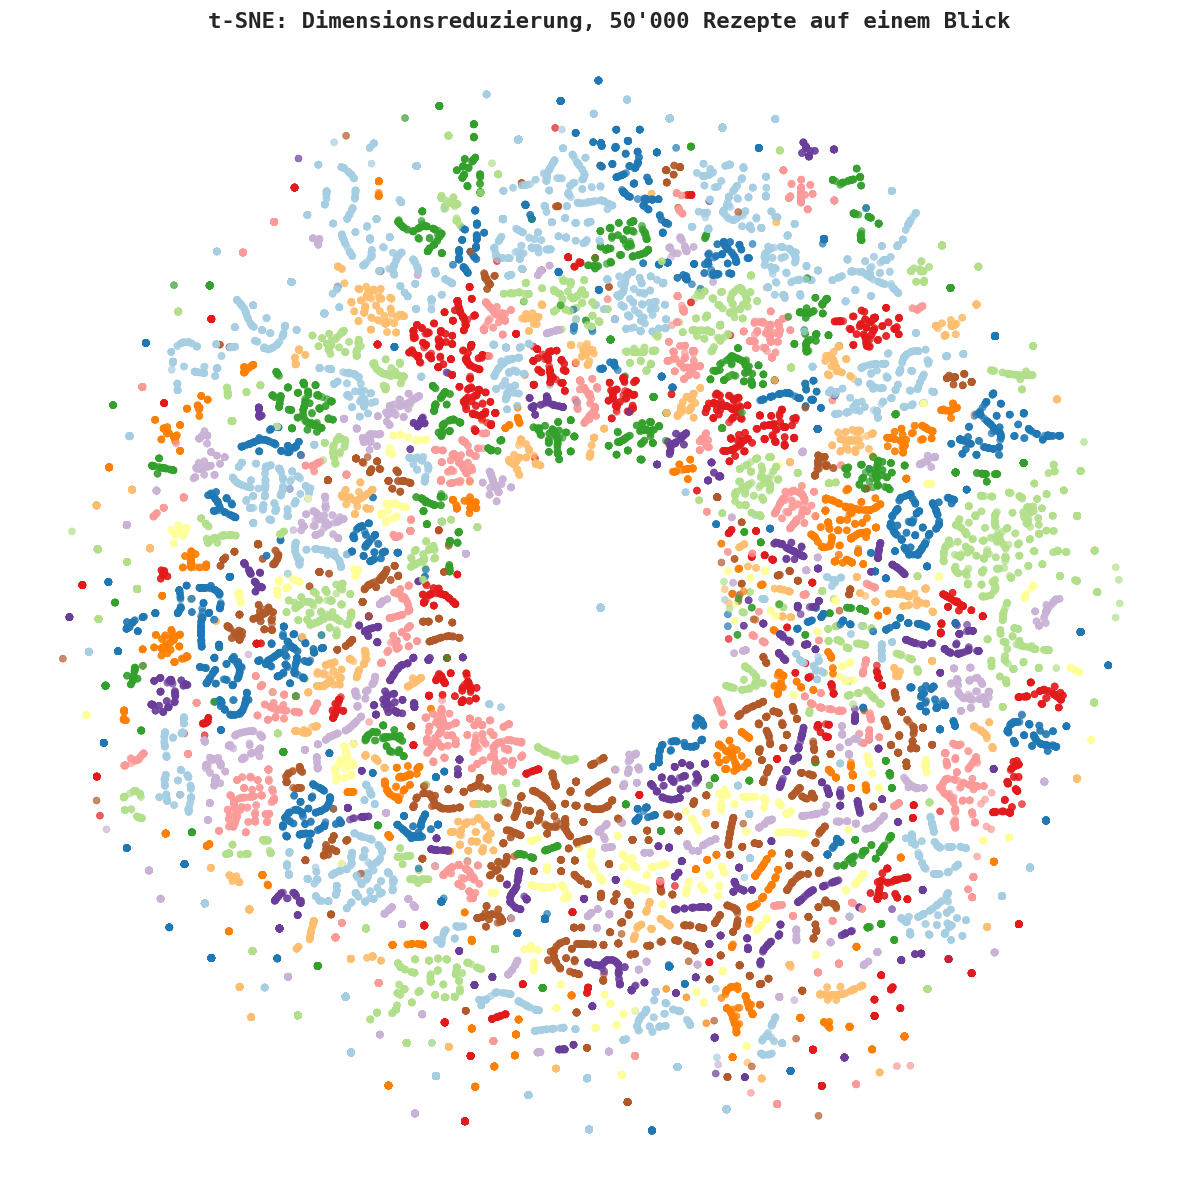

In [160]:
matplotlib.rc('font',family='monospace')
plt.style.use('seaborn-poster')

fig, axs = plt.subplots(1,1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

#data = tsne_embedding
scatter = plt.scatter(data=tsne_embedding,x='x',y='y',s=25, c=tsne_embedding['hue'], cmap="Paired", alpha=0.7)
plt.axis('off')
plt.annotate('t-SNE: Dimensionsreduzierung, 50\'000 Rezepte auf einem Blick', xy=(0.17, 1), xycoords='axes fraction',
            fontsize = 16, weight = 'bold', alpha = .85)

plt.show()

# Not run below -zhuoyu

In [161]:
legend_list = []
colors = []
for i in range(len(topics_category_300)):
    idx = np.where(tsne_embedding['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

IndexError: index 0 is out of bounds for axis 0 with size 0

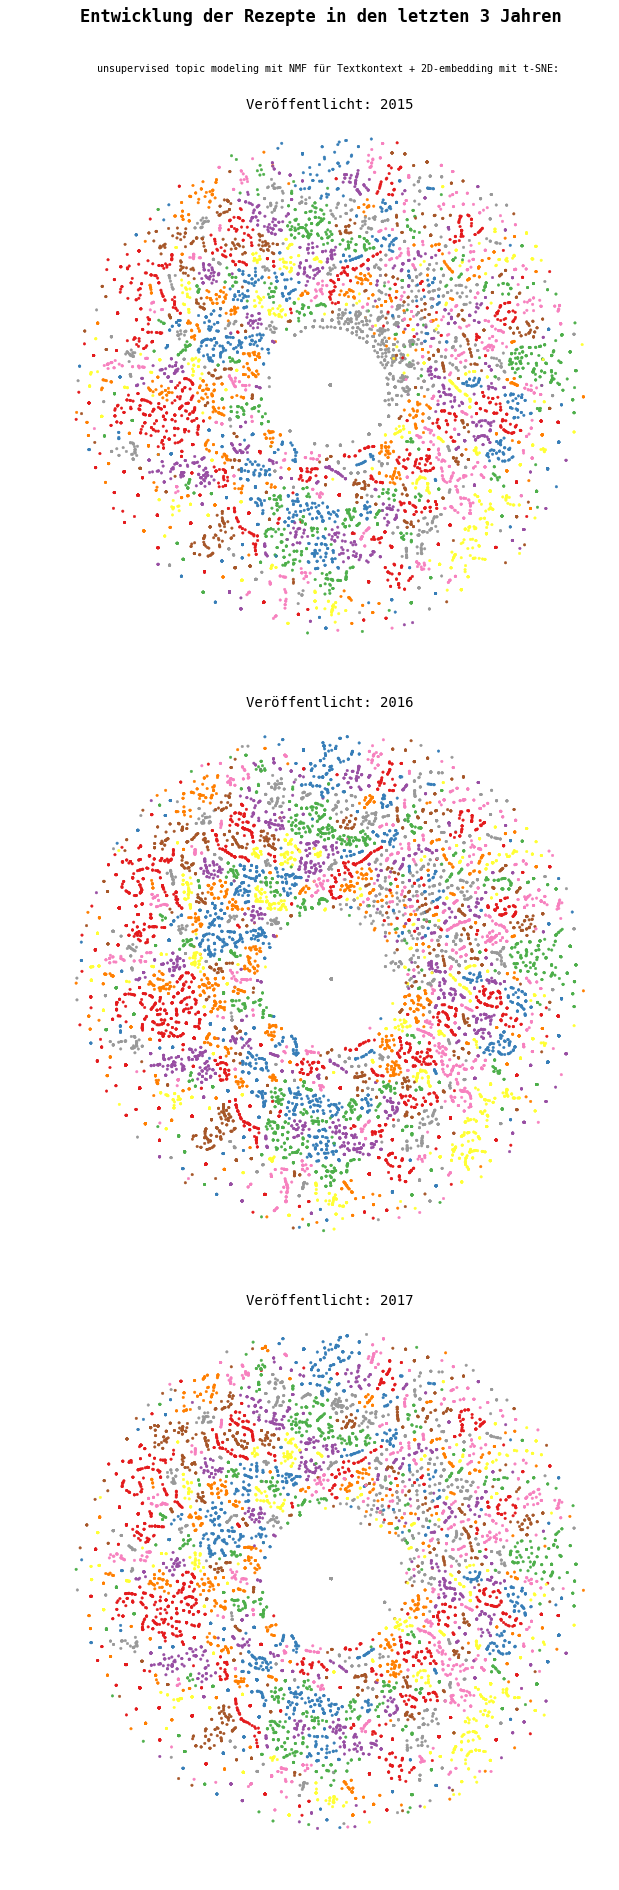

In [175]:
plt.style.use('ggplot')


fig, axs = plt.subplots(3,1, figsize=(10, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0.1)

axs = axs.ravel()

sorted_dataframe = rezepte_csv_analysis.sort_values(by='year', ascending=True)[266755:]
sorted_dataframe = sorted_dataframe.reset_index(drop=True)
count = 0
legend = []
for year, idx in zip([2015,2016,2017], range(3)):
    if year == 2015: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2016: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2017: data = tsne_embedding[sorted_dataframe['year']==year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Veröffentlicht: {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("Entwicklung der Rezepte in den letzten 3 Jahren",**{'fontsize':'17','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling mit NMF für Textkontext + 2D-embedding mit t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


#fig.legend(legend_list[:20],topics_category_300[:20],loc=(0.1,0.89))
plt.subplots_adjust(top=0.93)
plt.savefig('tsne_50000_3_years.pdf', format='pdf')
plt.show()

# Bilder Umbennenung
### Da man nun für jedes Rezept die passende Kategorie hat, kann man nun einen Ordner pro Kategorie machen mit den richtigen Bildern im richtigen Verzeichnis

# 图片重命名
### 由于现在每个食谱都有正确的类别，您现在可以为每个类别创建一个文件夹，在正确的目录中包含正确的图片

In [73]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [74]:
def movePic(src, dest):
    os.rename(src, dest)

In [85]:
topics_category_300[0:10]
len(topics_category_300)

300

In [84]:
directories_names = []

for directt in topics_category_300:
    d_name = directt.replace(' ', '_')
    directories_names.append(d_name)

for curr_dir_category in directories_names:
    print('input/images/images2/' + curr_dir_category)
    createFolder('input/images/images2/' + curr_dir_category)
    
createFolder('input/images/images2/no_cat')

input/images/images2/spaghetti
input/images/images2/salat
input/images/images2/nudeln
input/images/images2/muffins
input/images/images2/nudelsalat
input/images/images2/tomaten
input/images/images2/torte
input/images/images2/kuchen
input/images/images2/pasta
input/images/images2/hähnchen
input/images/images2/kartoffel
input/images/images2/error
input/images/images2/apfelkuchen
input/images/images2/schweinefilet
input/images/images2/paprika
input/images/images2/kartoffelsalat
input/images/images2/apfel
input/images/images2/lachs
input/images/images2/gemüse
input/images/images2/käsekuchen
input/images/images2/spargel
input/images/images2/zucchini
input/images/images2/curry
input/images/images2/nudelauflauf
input/images/images2/rote_bete
input/images/images2/schoko
input/images/images2/bananen
input/images/images2/suppe
input/images/images2/hähnchenbrust
input/images/images2/käse
input/images/images2/reis
input/images/images2/gnocchi
input/images/images2/erdbeer
input/images/images2/lasagn

In [76]:
!ls input/images/search_images/ | head -10

recipe-1101101216097184-1.jpg
recipe-1101101216097184-2.jpg
recipe-1101101216097184-3.jpg
recipe-1101101216097184-4.jpg
recipe-1101101216097184-5.jpg
recipe-1162451222354826-1.jpg
recipe-1162451222354826-10.jpg
recipe-1162451222354826-11.jpg
recipe-1162451222354826-12.jpg
recipe-1162451222354826-13.jpg


In [95]:
import csv
def get_recipe_id_cat():
    recipe_names_id_ = []
    recipe_names_cat_ = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis_with_category.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names_id_.append(row[2])
                recipe_names_cat_.append(row[7])
            except:
                print('ERROR')
                continue 
    return recipe_names_id_, recipe_names_cat_

In [96]:
get_recipe_id_cat_ID, get_recipe_id_cat_CAT = get_recipe_id_cat()

from itertools import zip_longest
def create_dict(keys, values):
    return dict(zip_longest(keys, values[:len(keys)]))

id_key_cat_value = create_dict(get_recipe_id_cat_ID, get_recipe_id_cat_CAT)

In [97]:
id_key_cat_value

{'3449791514066439': 'bratapfel',
 '3449721514056932': 'no_cat',
 '3449701514054063': 'no_cat',
 '3449651514047893': 'hack',
 '3449681514052511': 'no_cat',
 '3449481514034645': 'no_cat',
 '3449641514047091': 'no_cat',
 '3449571514042406': 'no_cat',
 '3449471514033424': 'no_cat',
 '3449241513953107': 'pasta',
 '3440201512485335': 'geschnetzeltes',
 '3440191512484382': 'butter',
 '3440181512484146': 'no_cat',
 '3440141512483430': 'linsen',
 '3440081512476666': 'gratin',
 '3440131512482468': 'no_cat',
 '3440031512469998': 'no_cat',
 '3440011512465228': 'nudeln',
 '3439971512426493': 'no_cat',
 '3439961512426428': 'gemüse',
 '3439951512423018': 'no_cat',
 '3439941512420770': 'überbackener apfel',
 '3439921512417177': 'eierlikör',
 '3439911512417093': 'nudeln',
 '3439841512408566': 'suppe',
 '3439571512375851': 'no_cat',
 '3439781512405763': 'no_cat',
 '3439751512402828': 'nudeln',
 '3439731512402196': 'süße',
 '3439711512393223': 'gemüse',
 '3439681512390736': 'spinat',
 '3439661512388943'

In [99]:
#input/images/search_thumbnails/recipe-100001040044233-0.jpg
#input/images/search_thumbnails/recipe-1000011205319453-0.jpg
#input/images/search_thumbnails/recipe-1000021205319843-0.jpg
# ...
import os
THUMBNAIL_DIR = './input/images/search_thumbnails/'
OLD_IMG_DIR = './input/images/search_images/'
files_moved = 0
for filename in os.listdir(OLD_IMG_DIR):
    #print(os.path.join(THUMBNAIL_DIR, filename))
    if filename.endswith(".jpg"):
        comp_id = filename.split('-')[1]
        cat_val = id_key_cat_value.get(comp_id, '_')
#         print(cat_val,comp_id)
        cat_val = cat_val.replace(' ', '_')
        
        new_image_dest = cat_val+'-'+str(comp_id)+'-'+ str(filename.split('-')[2])+'.jpg'
        movePic(OLD_IMG_DIR+filename, 'input/images/images2/'+cat_val+'/'+new_image_dest)
        files_moved+=1
        if files_moved%10000==0: print('+= 10000')

no_cat 2174031348989140
no_cat 2215211354802923
basilikum 2848391436875496
art 1904281310395852
no_cat 2335771371817949
no_cat 2615581410782203
nudelauflauf 2030311329124362
cookies 3176311472730598
gebratener 2584971405672557
brot 2324081370445580
mango 2654491416867136
gefüllter 2091361337770977
weiße 2426831382807776
nudelauflauf 1904691310462725
no_cat 2058871333034308
no_cat 2305541367922492
no_cat 2228441357119491
no_cat 2636391414132077
marzipan 2504511393189855
pizza 2304701367855737
rote bete 2520611395237922
gurkensalat 2398381379233773
no_cat 2849811437023820
no_cat 2104391339571599
no_cat 2161751347000194
no_cat 1940581315997276
no_cat 2318091369564753
no_cat 2649131416229732
low carb 3044491457121161
marzipan 1992411322751508
paprika 2357991374674200
mandarinen 2082441336375990
quark 2129181342540892
himbeer 2252501360596342
pilz 2133281343053838
spaghetti 2055191332249132
hähnchengeschnetzeltes 2548201398888450
hähnchengeschnetzeltes 2480281390288468
brötchen 221616135490

vanille 2315601369224192
blumenkohl 2028891328859299
orangen creme 2039971330359891
no_cat 3231561480786195
no_cat 2803681432473735
no_cat 1992331322734627
zucchini 2448471385667120
käsekuchen 2185081350850890
brownies 2330991371193879
bratapfel 2605011409315392
dip 2066151334069069
no_cat 2692151421954020
no_cat 2287501364830315
himbeer 2304971367906227
obstsalat 2073981335240216
brot 2613211410419016
bruschetta 2676351420228664
mango 2348251373399655
low carb 2801571432283729
schwarzwälder kirschtorte 2506321393356414
no_cat 2135591343298635
no_cat 2577591404053930
mandarinen 2451601386106660
kartoffeln 1993321322924822
no_cat 3032841455995156
torte 1990071322503701
frikadellen 2179861349988932
no_cat 2683881421003975
asiatische 2040501330425322
no_cat 2516691394807741
apfel 2725161425051304
error 2016351326713867
paprika 2357991374674200
frikadellen 2558511400419039
low carb 2990421451869696
pflaumenkuchen 2166871347792616
spaghetti überbacken 2251301360402926
bratapfel 200767132549

tortellini 2032921329430682
rührkuchen 2869001439127351
pasta 2239151358665620
no_cat 2168171347960373
honig senf 2115561340801211
nudelauflauf 1904691310462725
art 2252161360573409
risotto 2374581376594409
auberginen 2132231342936209
schokokuchen 1746041283847496
dinkel vollkornbrot 2570261402389888
asiatische 2352511374043771
no_cat 3092471461947578
honig senf 2278291363534789
nudeln 2045011331021392
no_cat 2942971446566339
eier 2152461345634474
no_cat 2052931331913392
no_cat 2441851384929722
no_cat 2549681399193118
lachs 3088671461580622
no_cat 2326811370781867
brötchen 2124171341900271
bolognese 2617931411122824
himbeer 2059661333196923
no_cat 2673361419790106
torte 2559051400505753
walnuss 2389931378360247
risotto 2270691362579388
pralinen 2524731395843698
no_cat 2168861348038269
champignons 2710171424041072
cupcakes 2243201359376719
no_cat 1645761272274628
mandel 2916351443958425
no_cat 2453261386322901
kartoffelpfanne 2393121378716490
quiche 2698191422694827
no_cat 3085221461154

cookies 2274481362985202
no_cat 3131381466436027
rhabarberkuchen 2792231431373861
no_cat 2035121329813550
wirsing 2073961335239999
couscous 2030771329166468
no_cat 1842241298538211
no_cat 2363801375370445
hackbraten 1997781323618308
no_cat 2208241353832698
tiramisu 2583131405368143
mango 2795971431725727
feldsalat 2670601419185504
sauce 2197031352496350
pflaumenkuchen 2583111405368037
no_cat 2495731392155573
no_cat 2115771340812873
no_cat 2495731392155573
no_cat 2279681363719464
gebratener 2334811371736384
kokos 3014401454250892
no_cat 3324961493671948
spaghetti 2448211385646018
kuchen 2291321365346561
schwarzwälder kirschtorte 2657761417366960
no_cat 2411981380996000
lauch 2131791342868265
cappuccino 2216951355063671
blätterteig 3090591461742710
cake 3060291458628664
no_cat 3060671458646675
no_cat 2118801341328031
no_cat 1874781304692490
eingelegte 2349321373552232
no_cat 2971661449744101
no_cat 2307431368165621
tortellini 2237471358363336
no_cat 1162451222354826
apfelkuchen 232085136

torte blech 2240901358955575
no_cat 1908231311080249
curry con carne 2849571436981632
pfannkuchen 2529831396465550
no_cat 2189681351458817
no_cat 3295701489314378
schokoladen 2011621325951604
no_cat 2032041329339863
erdbeer 2311561368724833
pfirsich 2121041341545131
auflauf 2331301371216446
art 2205281353507236
himbeer 2018571327011704
no_cat 1969621319876522
no_cat 2617501411048849
quiche 2801401432239694
no_cat 2286071364511473
bohnensuppe 2392441378657729
kürbis 2922661444580549
cupcakes 1940351315981940
no_cat 2574041403212287
zucchini 2164501347435757
kokos 2543051398172876
pizza 3207231477380021
no_cat 2356461374564857
kabeljau 2690531421776371
kartoffelpfanne 2120381341499440
vanille 2901001442430097
no_cat 639171164876057
no_cat 2375841376769049
low carb 2531661396718677
no_cat 2286511364568328
no_cat 2517691394919767
spaghetti 2984291451228398
no_cat 2165491347594931
pudding 3100521462886675
no_cat 2131111342765824
pikanter 1972271320327235
salat 2869901439229772
brownies 3108

gnocchi 2703751423248348
kohlrabi 2132431342948988
pfannkuchen 2299611366634834
bandnudeln 2549561399146861
no_cat 2287701364848460
no_cat 2371901376312725
schokokuchen 2637841414404866
griechischer 2035251329814401
no_cat 2182101350399069
knoblauch 2221311355486926
reis 1996341323284940
no_cat 2062231333483915
no_cat 2278141363527809
no_cat 1904801310481396
no_cat 2466751388650600
no_cat 2892271441537302
no_cat 2077301335722695
fenchel 3024371455216473
cupcakes 2566111401627757
no_cat 2349291373548901
no_cat 2000711323929063
no_cat 3172621472217156
schwarzwälder kirschtorte 1778431287735383
no_cat 1998701323731588
kartoffelsalat 3426311510415384
no_cat 2091201337763932
eierlikörkuchen 2504731393230544
cupcakes 1987381322148859
likör 2877741440057797
kuchen 2370451376151096
suppe 2098111338561333
muffins 2474941389691202
kiwi 2318851369671303
low carb 2274141362944915
no_cat 2111171340288035
feldsalat 2474121389570859
no_cat 2248221360055482
nudeln 2461681387437657
no_cat 2262981361634

low carb 2534161397043694
rhabarber 2791831431338599
no_cat 2625921412509510
feta 2078981336027710
gratin 2508511393710891
kokos 2264581361859859
no_cat 2455511386627445
schmand 2176931349526457
no_cat 2392301378649782
smoothie 2732701425630334
möhren 1904871310483063
lasagne 2291331365346705
spaghetti 2822261434289740
no_cat 2730791425463607
no_cat 2296941366142559
no_cat 2074571335292744
überbackener apfel 2087811337250544
muffins 2120291341497775
cake 1977481320924054
pilz 2458781387101136
no_cat 2176711349450086
schokoladen 3082701460909867
porree 2232101357569788
no_cat 1938851315770033
no_cat 2254441360766925
art 2137911343643146
cupcakes 2566111401627757
no_cat 2136811343456828
quark 2260721361429035
hackbraten 2661361417894397
thunfisch 2236431358197320
cookies 2078041335852913
no_cat 2483471390722597
hühnchen 1999851323860956
mohnkuchen 2043781330869015
no_cat 2507961393588832
pasta 3004761453328041
cake 2067011334176628
no_cat 2146431344920604
grüne 2406611380140966
kuchen 25

no_cat 1905411310551645
salatdressing 2403941379864417
no_cat 3003351453208337
no_cat 3206451477245446
no_cat 2056161332417223
no_cat 2678641420465151
no_cat 2122941341816613
champignons 2209471353939543
pudding 2130981342712403
kuchen 3011311453987883
spargel 2093401338025265
pfirsich 2280471363797284
himbeer 2603731409067922
sauce 2150631345356366
no_cat 2301361366984662
no_cat 2075461335446954
spaghettisalat 2621161411669331
orangen creme 3018331454624805
spargel 2520621395238605
grünkohl 2196831352475323
muffins 1987971322227565
shake 1841101298383678
no_cat 2055081332243991
torte 2249651360171392
sahne 2213931354704059
no_cat 2626581412615779
gegrillte 2813301433326496
avocado 2405211379967540
schinken 2253181360663190
spinat 2257481361166703
no_cat 2380631377366321
quiche 2017651326831340
zitronen 2647021415916677
tomatensuppe 3064881459016579
kekse 2386991378122801
no_cat 3094381462179697
no_cat 3230991480700828
art 2058971333091109
kabeljau 2678601420460732
linsensuppe 29545814

no_cat 3060331458631544
burger 2731081425476050
kekse 1871951304259870
spaghetti 3395531505511187
wurstsalat 2271111362593115
no_cat 2111831340383591
no_cat 2283661364208390
chicken 2564651401386981
no_cat 2655001416928979
pasta 3190371474828227
mozzarella 2220611355433479
thunfisch 2111711340375637
no_cat 2067601334243384
no_cat 2341701372709382
brot 3340011496228272
cookies 1873301304490448
champignon 1980231321347364
error 2673141419750450
no_cat 2573981403201985
pizza 2234091357829470
blätterteig 3090591461742710
no_cat 1998441323707027
no_cat 1907351310977943
thunfisch 2157801346267309
low carb 3035021456167801
lebkuchen 3435161511735111
pikanter 3130101466320853
obstsalat 2919491444234193
quark 1974251320657381
no_cat 2348701373471778
no_cat 2850511437082395
no_cat 2190581351543242
cappuccino 2671221419273131
no_cat 1996151323276129
reispfanne 2494161392024691
no_cat 2251111360325613
no_cat 2142471344321010
maultaschen 2245501359644242
no_cat 2409511380639283
art 2496301392236906

ravioli 1646211272278441
tortellini 2609091409858838
tagliatelle 2109501340136606
brötchen 2841831436245733
no_cat 2066751334132029
haselnuss 2190491351537798
no_cat 2708961423846995
no_cat 2283661364208390
brot 2480471390309024
salat 1872471304348888
kuchen 2031851329315625
pudding 2573341403033333
no_cat 3046891457293856
karotten 2201621353018579
error 2461341387398773
no_cat 1840251298299232
no_cat 2238571358516836
flammkuchen 2216101354895066
ente 1998371323703563
no_cat 2672631419604367
no_cat 2540691397898745
no_cat 2122821341815190
rote bete 2104631339574578
dinkel vollkornbrot 2958371448139777
kuchen 3320341493055909
kasseler 2250581360274628
garnelen 2138531343725212
himbeer 2171371348548564
no_cat 2572871402987307
low carb 2621681411744812
kohlrabi 2371301376250382
paprika 2336941372061305
muffins 2129401342554803
apfelkuchen 2204031353338061
spinat 3219401479046221
salatdressing 2074821335342775
no_cat 2241081359023607
no_cat 2457511386865988
makkaroni 2393721378756788
karto

no_cat 2653361416753488
no_cat 2543261398193691
gegrillte 1873811304538564
no_cat 2091181337763462
bolognese 2613271410421525
no_cat 2678481420452224
no_cat 2503591393087486
no_cat 2258731361267605
couscous 2180631350134311
sahne 2040541330436041
blumenkohl 3224671479753109
burger 2065081333916956
paprikaschoten 2127951342365792
no_cat 2344661373005925
kohlrabi 2609081409857711
no_cat 2393851378757244
einfache 2117451341213380
rührkuchen 2352411374039489
schokoladenkuchen 2932031445525032
cupcakes 2605991409493598
kuchen 2202631353171916
brot 2613211410419016
hähnchengeschnetzeltes 2411591380906417
pflaumenkuchen 2227521356870378
no_cat 2287801364848680
no_cat 2829391434906178
rote bete 2534261397047076
huhn 2158391346400168
süße 2053661332053043
porree 1903931310363800
no_cat 2562571401126047
no_cat 1913651311847730
no_cat 2628311412875281
no_cat 2243641359445895
no_cat 2685401421172076
no_cat 2181871350329730
no_cat 2233151357740012
low carb 2718921424689494
bandnudeln 26209714116551

no_cat 3235851481440049
cookies 3176311472730598
torte 3292501488863519
no_cat 2174031348989140
no_cat 2215211354802923
marzipan 2504511393189855
rote bete 2520611395237922
no_cat 2058871333034308
no_cat 2228441357119491
no_cat 2305541367922492
no_cat 2636391414132077
aprikosen 2509221393842849
weiße 2426831382807776
porree 2069411334604201
fisch 3223891479648528
no_cat 2849811437023820
no_cat 2161751347000194
obstsalat 2284851364334486
no_cat 1940581315997276
gurkensalat 2398381379233773
no_cat 2079711336057219
mandarinen 2082441336375990
marzipan 1992411322751508
paprika 2357991374674200
no_cat 1643321271926427
low carb 3044491457121161
no_cat 2474261389617352
brötchen 2216161354902571
hähnchengeschnetzeltes 2480281390288468
no_cat 1940541315993954
spaghetti 2055191332249132
no_cat 2959601448230489
himbeer 2252501360596342
marmelade 2055181332246711
no_cat 2346131373211621
pfannkuchen 3103391463244790
burger 2625801412493032
torte 3158461470127588
no_cat 2352661374049355
brownies 164

no_cat 2258831361267917
burger 2624771412279803
nusskuchen 2755481427571459
brokkoli 2470311389104715
kohlrabi 2371301376250382
no_cat 2457511386865988
no_cat 2241081359023607
salatdressing 2074821335342775
nudelsalat 2520991395262854
muffins 2129401342554803
nudelauflauf 3234491481206661
vanille 2996441452460771
no_cat 2572871402987307
himbeer 2171371348548564
no_cat 1840241298299158
aprikosen 2838701435858146
no_cat 2170541348389246
no_cat 2122821341815190
no_cat 2267881362236042
schokoladen 2066091334067546
no_cat 2594091407348060
no_cat 2037011330002196
no_cat 2331121371196972
tortellini 2121871341693729
muffins 2129401342554803
chinakohl eintopf 2321261370002987
no_cat 1872541304356249
auberginen 2165701347606024
feine 2310181368568943
nudelauflauf 2140051343845974
no_cat 2842301436274891
nudelauflauf 1907601311004505
no_cat 2572871402987307
grüne 2865391438782982
cupcakes 2791331431270758
no_cat 2805681432584491
gnocchi 2711861424240239
no_cat 2993301452166284
no_cat 212233134175

no_cat 2203771353334219
avocado 2851181437150444
no_cat 1810141293101855
no_cat 2262961361634788
cookies 1942431316281389
ananas 2644401415524742
no_cat 2914441443718296
kekse 2269841362490785
feta 2860601438177981
no_cat 1904831310481858
quiche 2017651326831340
no_cat 2663951418215257
no_cat 2972461449793257
no_cat 3076771460313933
pesto 2648731416211587
shake 2931151445444326
schweinebraten 2310381368596011
chicken 2071811334947215
kartoffel 2130521342674080
joghurt 2270531362562851
tomatensalat 2777991429956803
torte 2531551396704423
kürbissuppe 1808981292883798
no_cat 2379341377222282
nudeln la 2163051347220702
no_cat 2853711437479417
lasagne 2657231417263331
no_cat 2148021345099050
low carb 2674661419956248
sauce 2094671338200466
no_cat 2692011421942621
bratapfel 2493711391955217
curry 2019331327269617
zucchini 2620161411540966
no_cat 2582281405098024
no_cat 2442471384960481
no_cat 2069861334674016
dinkel vollkornbrot 2314201369084320
kaffee 2137511343575190
no_cat 214344134441620

brownies 2242781359314039
no_cat 2581991405035000
shake 1841101298383678
no_cat 2134921343222675
kuchen 1990581322569363
gebratener 2701001422984657
sauce 2150631345356366
bananen 2170401348339334
kartoffelpfanne 3075861460227689
putengeschnetzeltes 1808261292600432
lasagne 2106861339852496
apfel 2178281349707392
nudelauflauf 2352371374010722
kürbis 2625011412335340
spaghetti 2068801334506662
no_cat 2261711361535603
no_cat 2054491332223952
thunfisch 2086251337054585
no_cat 2010311325775011
no_cat 2147281345008464
eier 2064041333630150
gurken 2848121436835501
no_cat 2079481336050523
kekse 2821781434227346
no_cat 3003351453208337
cookies 2370471376157523
brot 2119111341388717
nudeln 3011061453974908
fenchel 2458161386967657
no_cat 2036101329915562
mohn 2176791349514032
nudeln 2604991409314630
no_cat 2001911324048431
dinkel vollkornbrot 3244631482857698
no_cat 2319981369834705
no_cat 2082871336404681
lasagne 3020771454875865
bananen 2179131349898662
risotto 2443881385153128
quark 22466713

no_cat 2071531334866293
zitronen 2209451353937987
fenchel 2227811356966913
cocktail 2523201395588825
paprika 1989391322419306
nudeln la 2066201334070106
nudeln 2848091436834550
schmand 1968441319746720
muffins 3055911458203395
basilikum 2087531337181286
weiße 2777591429903350
no_cat 1101101216097184
low carb 2548121398888147
no_cat 1972451320328777
kekse 2495491392137318
no_cat 2523341395601145
pizza 2369681376040694
salat 2378201377102663
wurstsalat 2028681328818951
tomaten 2379551377259763
low carb 2053471332003967
no_cat 2604331409214517
nusskuchen 2437141384238366
no_cat 2455511386627445
zimt 2045381331104950
no_cat 2139951343845069
sahne 2535801397225039
no_cat 2686101421306417
no_cat 3173711472381409
no_cat 3168761471686517
torte 1990621322575038
no_cat 2320441369859626
no_cat 2444181385219265
no_cat 2058981333091256
cheesecake 2200801352928260
nutella 3111761464100274
nudelsalat 3191771475047927
dressing 2301491366988637
cheesecake 2568931402080074
fenchel 1989431322419706
no_ca

no_cat 2573701403108660
porree 2605141409334197
kartoffeln 2538091397573693
no_cat 2060171333287230
no_cat 2621861411812948
möhren 2221221355486169
griechischer 2419101381852132
gemüse 1999421323793064
sauce 2176081349374996
muffins 2538381397597158
süße 2510401394010673
no_cat 2036251329922377
nudeln 2848091436834550
pflaumenkuchen 2219281355322881
no_cat 3346481497332404
no_cat 2129991342599498
no_cat 2410871380818172
pizza 2591521406899132
zucchini 2823611434400429
no_cat 2562341401094045
feldsalat 2051201331732913
no_cat 2431651383566361
nuss 2529671396448635
no_cat 2827501434741328
kiwi 2318851369671303
no_cat 2216771355047309
muffins 2474941389691202
haselnuss 2144601344603462
no_cat 3022831455092558
low carb 2274141362944915
no_cat 2111171340288035
torte 2528001396272176
cupcakes 1987381322148859
no_cat 2283661364208390
no_cat 2091201337763932
no_cat 2000711323929063
no_cat 2146291344873262
schwarzwälder kirschtorte 1778431287735383
no_cat 3172621472217156
kuchen 213738134355181

no_cat 2959381448214820
no_cat 2146691344940976
kaffee 1967821319653706
kürbis 2922661444580549
no_cat 2245741359651394
bohnensuppe 2392441378657729
einfache 2294701365792540
no_cat 2697531422560188
schokoladen 2011621325951604
no_cat 3295701489314378
no_cat 2189681351458817
no_cat 2617501411048849
nutella 2124381341901285
nutella 2421471382111393
no_cat 2963831448799622
auflauf 2331301371216446
art 2205281353507236
erdbeer 2311561368724833
no_cat 2032041329339863
nutella 2349191373540375
zwiebel 2375431376746066
pfannkuchen 2529831396465550
no_cat 2572991403003290
torte 2663901418213360
torte 2313951369058496
no_cat 2795011431669127
birnen 2390081378389098
schweinefilet 2594391407422710
heidelbeer 2308631368340009
no_cat 2015751326472354
no_cat 2826781434715535
no_cat 2318581369652597
no_cat 2283661364208390
low carb 3374691501962154
vanille 2447831385586537
basilikum 2453311386323019
haselnuss 2675201420049343
gugelhupf 2298801366523927
no_cat 2095351338294142
nudelauflauf 2172011348

torte 2012261326033673
no_cat 2171131348501194
torte 2394071378757699
champignon 2312741368852663
gurkensalat 2615971410851537
pfirsich 2604181409154164
no_cat 2714991424437069
no_cat 3224231479667873
no_cat 2160361346825396
no_cat 2173491348916699
linsensuppe 2242451359229529
pasta 1994061323030486
smoothie 2771231429167961
torte 2080871336146271
gulasch 2031221329231715
eintopf 1977151320914088
hähnchengeschnetzeltes 2620001411492918
no_cat 3240861482174479
kirschkuchen 2294661365792363
pflaumenkuchen 2436381384116484
no_cat 2067541334213328
no_cat 2095831338311129
no_cat 2565241401467009
risotto 2148221345114285
tortellini 2546231398604265
chinakohl eintopf 2280561363799485
lasagne 2246511359795546
salatdressing 2073641335193550
no_cat 2663951418215257
käsekuchen 2842381436276004
muffins 2679421420537535
quiche 2017651326831340
kartoffelpfanne 3003451453210688
quiche 2124951341994726
käsekuchen 2510771394046016
eingelegte 2073471335177843
no_cat 2454891386591039
süße 241339138123150

makkaroni 2543141398180682
tomatensuppe 2100341338969720
torte 1938391315551630
low carb 2713101424297235
fruchtiger 1644731272093991
no_cat 2009701325694465
marmorkuchen 2636351414128390
smoothie 2372981376399631
streuselkuchen 2804151432492152
smoothie 2662281418054781
no_cat 2600961408632984
low carb 2557491400245424
feta 2678971420482263
no_cat 2392301378649782
pesto 2838471435839647
karotten 2015591326456137
kartoffel 1940461315989732
no_cat 2343421372876046
no_cat 2151151345452213
brot 2137331343550232
kartoffelpfanne 2152051345525156
no_cat 2012091326031063
no_cat 2178161349687628
feldsalat 2259711361349128
gefüllter 2375591376758674
möhren 2038881330268276
möhren 2040551330436827
penne 1977951320951924
no_cat 2009911325749835
blumenkohl 2194821352236768
no_cat 2177211349536190
eierlikör 1995711323258345
obstsalat 2318931369671550
mandarinen 2942901446564053
cupcakes 2321741370035477
kuchen 2344751373012857
marinierte 2727541425236070
kräuter 2112511340394413
spargel 23723313763

no_cat 2070981334779573
wirsing 1611571268382346
gugelhupf 2415781381428681
porree 2371941376313825
grüne 2294161365757646
no_cat 2260741361429088
no_cat 2007771325507213
no_cat 2823011434365940
garnelen 2267701362153770
salat 1966171319525408
auflauf 2413131381176042
no_cat 1997401323524834
no_cat 2572991403003290
no_cat 2161511346996340
no_cat 2457011386835397
schokoladen 2247041359902205
no_cat 2073131335109208
no_cat 2237361358350730
no_cat 2474801389652126
no_cat 2228441357119491
no_cat 2058871333034308
no_cat 2530081396503314
no_cat 2636391414132077
schinken 2952481447531384
no_cat 2551531399469252
rote bete 2520611395237922
pasta 2739771426108902
salatdressing 2575391403551712
aprikosen 2509221393842849
kiwi 1778901287762849
no_cat 2041861330585602
vanille 1809031292925677
apfelkuchen 2297811366306492
mango 2654491416867136
cheesecake 3274891486581257
marmelade 2162881347198928
no_cat 2174031348989140
mango 2213231354613434
no_cat 2335771371817949
no_cat 2880691440337234
no_cat 

waffeln 3224421479723888
asiatische 2352511374043771
kartoffelsalat 3018751454687817
weiße 2084241336656632
no_cat 3092471461947578
gurken 3155811469720467
dinkel vollkornbrot 2570261402389888
nudelauflauf 1904691310462725
rucola 2448771385672446
no_cat 2643621415375901
art 2252161360573409
kohlrabi 2592331407082356
risotto 2374581376594409
pizza 2197841352667480
schokokuchen 1746041283847496
marzipan 2193561352130225
frikadellen 2614741410633620
torte blech 2047241331300470
cake 2178331349725471
no_cat 2227111356684575
panna cotta 2241751359108969
mandarinen 2423561382388373
low carb 3051891457787598
bärlauch 1972171320301694
spargel 2539551397767855
pflaumenkuchen 2393191378721331
no_cat 2572171402844331
no_cat 2414781381322536
no_cat 1997541323616202
krautsalat 2605971409492016
no_cat 2410301380726440
bohnen 2522871395566242
no_cat 2657211417258645
himbeer 3220551479198380
chili 2299981366781440
torte 3044311457110630
süß sauer 2225661356083551
tiramisu 2294381365772882
bolognese 20

no_cat 2018311326965782
apfelkuchen 2320851369927456
no_cat 1162451222354826
low carb 2563311401210237
curry 2033501329494843
gemüse 2967111449162572
no_cat 2285631364484419
lasagne 2036601329992995
hähnchengeschnetzeltes 2456311386706852
no_cat 2702851423153525
no_cat 2181231350234899
tortellini 2237471358363336
fischfilet 2373031376401800
kohlrabi 2920351444327923
nudelauflauf 2197531352621646
no_cat 2842421436276472
kartoffeln 2059581333195024
nutella 2085091336846309
no_cat 2575171403525656
italienische 2520481395234858
basilikum 3079871460639743
cupcakes 2888651441133778
porree 3210401477842892
no_cat 2442281384948243
cake 2325821370607117
no_cat 2248341360055932
müsli 1967101319614771
no_cat 2035291329814755
no_cat 2281291363883887
no_cat 2035701329860153
brot 2055621332345472
wirsing 2059481333174116
couscous 2548511398962625
no_cat 1975061320692262
schweinebraten 2210881354095272
cupcakes 1940351315981940
kuchen 2663591418153740
no_cat 2036841329999583
no_cat 2151991345524564
m

no_cat 2048121331388184
pfannkuchen 2529831396465550
no_cat 2071901334948003
torte 2669731419072177
walnuss 2424981382542269
no_cat 2913371443623348
no_cat 2194951352301683
low carb 2814751433498134
no_cat 2739861426143257
apfelkuchen 2061641333452523
no_cat 3325381493742901
nudelauflauf 2352371374010722
apfelkuchen 2061091333398422
nuss 2053481332004907
no_cat 2000851323950976
no_cat 1840331298299942
cupcakes 2591951406991194
error 3015281454313255
pasta 2993411452170111
kartoffelsalat 2084481336717614
no_cat 2027701328707484
maultaschen 2266681362067405
spaghetti 1986511322004558
low carb 2488041391280845
no_cat 2520471395234003
no_cat 2864591438679746
carpaccio 2878311440093234
low carb 2067321334211747
lachs 3218751478969551
entenbrust 1937911315508775
spargel 2291271365345786
karotten 2057951332885465
no_cat 1986581322005157
pizza 1810181293103942
torte blech 2134251343129817
krautsalat 2530421396527860
kuchen 2508411393694623
fruchtiger 2422701382278415
sauce 2306691368043875
no_

toast 2264671361860092
no_cat 2294531365776173
rucola 2618171411143972
no_cat 2122011341694252
no_cat 2417201381651462
avocado 2848921436903204
no_cat 2366791375820957
blechkuchen 2038461330206007
griechischer 2258051361196976
couscous 2520661395239178
blumenkohl 2481851390484666
no_cat 1906941310902803
no_cat 2609301409902829
smoothie 3078621460541224
pfirsich 2013581326212261
no_cat 2171511348550929
schokokuchen 3137061467180040
no_cat 2135631343305732
grüne 2406611380140966
dinkel vollkornbrot 2953771447614204
hack 3059631458565542
no_cat 2287701364848460
brownies 2183471350587883
pasta 2653001416687032
salat 2333531371625198
no_cat 2229681357229455
auberginen 2738751426074650
lachs 3206461477245494
no_cat 2093951338117463
low carb 2534161397043694
butter 2766911428603391
eierlikörkuchen 2526691396114515
zwiebel 2237201358337066
zucchini 1994841323158055
zitronen 2980211450698617
curry 1989281322415149
schwarzwälder kirschtorte 1973051320415618
flammkuchen 1996621323342935
paprika 2

no_cat 2608611409822602
no_cat 2069681334661301
no_cat 2324221370450304
pikanter 2193211351950173
quiche 2046301331189305
no_cat 2442461384960272
kürbissuppe 2621661411743434
gegrillte 2888991441188569
no_cat 2087371337165415
pasta 2317501369498306
apfelkuchen 1645841272275285
no_cat 2811951433186052
no_cat 2148571345138010
apfel 1941171316073591
möhren 2258011361193840
no_cat 2942871446563559
no_cat 2796201431773286
überbackener apfel 1746411283869548
cake 2040561330436979
torte 2561971401020801
no_cat 2138891343740724
cupcakes 2171531348551080
no_cat 2144271344527184
pasta 2636151414073693
bowle 2867431438965416
sauce 2306691368043875
no_cat 1942291316259984
no_cat 2639701414675615
zimt 2538031397569657
no_cat 2656181417094772
kuchen 2508411393694623
tarte 2031801329290713
pizza 1810181293103942
no_cat 1986581322005157
torte blech 2134251343129817
reispfanne 2584681405625295
mandarinen 2052791331888709
no_cat 2137281343548332
eier 2009651325690829
no_cat 2134121343104952
bratapfel 20

cupcakes 1940351315981940
torte 3125711465821083
fenchel 2148151345111414
no_cat 2289191365056719
no_cat 1968171319719361
torte blech 2134251343129817
torte 3090711461745280
spinat 2156801346078795
kartoffel 2222681355727931
zucchini 2132681342975066
quark stollen 2406751380141551
pflaumenkuchen 2341781372709532
cheesecake 1973741320510380
cookies 2415691381419890
no_cat 2971401449693617
curry con carne 2845421436601760
no_cat 2717911424621117
lasagne 2283781364208806
pfannkuchen 1997521323615875
kuchen 2178851349866249
karotten 2057951332885465
marzipan 2150871345389553
zucchini 2548231398894641
lasagne 2036601329992995
fisch 1712711280092640
gebratener 1907311310977628
linsensuppe 2520431395231017
brot 2744501426503860
müsli 2991591451996107
no_cat 2423231382361217
tomatensoße 2554401399819211
no_cat 3038321456476264
no_cat 2069391334603995
low carb 2929201445247058
kuchen 2121391341584109
no_cat 2270371362561067
zucchini 2044781331019749
no_cat 3415951508950086
kartoffel 29728314498

no_cat 3007161453576887
torte blech 2047241331300470
no_cat 2474931389652822
kabeljau 2705881423501640
pflaumenkuchen 2238611358580768
muffins 2236601358244033
no_cat 639181164876273
blätterteig 1643131271857934
no_cat 2400441379450180
no_cat 2034701329749424
krautsalat 2136081343377480
hackfleisch 2326371370700442
kekse 2425581382616389
smoothie 2825191434619728
streuselkuchen 2692381422008732
kuchen 2119481341431853
burger 2516631394805309
ente 2049701331587253
grünkohl 2497151392313460
no_cat 2730491425455071
cake 1996921323358725
curry con carne 2571751402693757
mohnkuchen 2094181338129930
spaghetti 1903751310311718
sandwich 3028391455624301
no_cat 2730971425472844
error 2198511352729910
pudding 2695031422290597
blumenkohl 2531951396733645
cupcakes 2243201359376719
no_cat 1809281292934121
pflaumenkuchen 2446461385416697
vanille 2193581352130557
no_cat 2634351413805820
no_cat 2148591345138664
no_cat 2597911408085244
kuchen 2773651429457718
no_cat 2331331371218035
no_cat 230914136847

no_cat 2929831445290936
apfel 2145241344699211
no_cat 2279811363726091
sauce 2094671338200466
no_cat 2542041398034089
zimt 2041371330530050
dinkel vollkornbrot 3256251484294544
no_cat 3194371475488901
low carb 2414271381303554
rindfleisch 2187371351069215
no_cat 2857211437851725
geschnetzeltes 2057061332609674
no_cat 2651981416572618
art 2673231419770434
hähnchenbrust 2775271429630322
no_cat 2666091418575856
feta 1990981322589905
müsli 3116981464687589
no_cat 2401511379588506
hackbällchen 2178231349706223
no_cat 2324841370531110
frikadellen 2179861349988932
couscous 2803821432479439
smoothie 2546101398590444
no_cat 2291311365346438
tofu 2038621330247142
mozzarella 2188101351169201
no_cat 2046771331226690
brotaufstrich 2176051349374167
torte 2059921333209496
zimt 2446441385416660
no_cat 3187121474369442
cake 2067011334176628
pesto 2321831370161871
bärlauch 2174701349072377
no_cat 2167711347909691
haselnuss 639111164874609
pasta 2204631353400369
no_cat 3108171463689270
lasagne 2268731362

bananenkuchen 2488351391355874
einfacher 1974231320646079
brötchen 1907901311066229
no_cat 2316021369232981
no_cat 2338971372273350
pilz 2133281343053838
chicken 3131771466490084
torte 2359001374793283
mohn 2328841371012586
blumenkohl 2259961361357393
chicken 1842161298537114
no_cat 2283661364208390
karotten 2014181326287160
no_cat 2136761343455656
no_cat 2346131373211621
art 2179061349882535
brot 1995601323210249
müsli 2935901445947329
no_cat 2252621360648847
kräuter 2132321342947107
no_cat 2572991403003290
hackbällchen 2233901357807439
muffins 2729151425371471
no_cat 1644211272021213
no_cat 2166771347791681
no_cat 2494391392037946
erdbeer 3135731467018311
no_cat 2526551396099159
kartoffelpfanne 2649861416317453
no_cat 1996721323351224
no_cat 1986051321982537
no_cat 2472231389302157
spaghetti 2334371371710329
kekse 2233771357770390
no_cat 2523001395581306
kekse 2327131370804198
torte 1938391315551630
no_cat 2347731373362653
feta 2874391439727539
tofu 2051471331757919
überbackener apfe

lasagne 2268731362381035
pasta 2204631353400369
haselnuss 639111164874609
no_cat 2169281348139303
no_cat 1941071316067560
no_cat 2362501375266808
kartoffelpfanne 2868351439057435
brotaufstrich 2176051349374167
zucchini 2448471385667120
no_cat 2046771331226690
bärlauch 2174701349072377
no_cat 2306931368085577
no_cat 2167711347909691
cake 2067011334176628
no_cat 3187121474369442
frikadellen 2179861349988932
no_cat 2638791414525802
no_cat 2324841370531110
hackbällchen 2178231349706223
no_cat 2401511379588506
feta 1990981322589905
no_cat 2203461353318194
error 3075371460194842
tofu 2038621330247142
mozzarella 2188101351169201
no_cat 2291311365346438
couscous 2803821432479439
no_cat 2033481329494270
marzipan 2345371373031378
pizza 2640381414844898
low carb 2414271381303554
no_cat 1998981323763212
zimt 2041371330530050
no_cat 2080891336147683
bratapfel 2007671325498717
apfel 2145241344699211
cheesecake 2572331402854031
no_cat 2045231331047604
no_cat 2261931361542263
lachsfilet 26641114182342

kürbis 2682081420790405
no_cat 3326991493975118
no_cat 3099921462821724
auflauf 2498991392559655
apfel 2213551354640407
feigen 2895931441919984
rinderfilet 639131164875278
no_cat 2220351355413234
risotto 2303561367499048
spaghetti 1978671321080987
risotto 2249131360134936
no_cat 3263101485121843
no_cat 2673081419707676
dinkel vollkornbrot 2542431398113526
no_cat 2287701364848460
no_cat 2806191432656420
no_cat 2666241418587462
gurkensalat 3211871478018256
gemüsesuppe 2267741362233572
gefülltes gemüse 2700631422958385
no_cat 2257091361092343
no_cat 2225491356082028
no_cat 2125171342003579
gnocchi 2507481393507298
no_cat 2520271395217022
kuchen 2328051370927795
no_cat 2283661364208390
no_cat 2622401411916437
pudding 3020321454857990
no_cat 2085181336851214
no_cat 2008991325624887
ravioli 2413331381225790
paprika 2566161401634049
sahne 1987001322065634
zimt 2592451407102512
no_cat 2328421370947904
sauce 2298351366446128
nudelsalat 2003721324395729
no_cat 2817081433691604
apfel 250464139322

sahne 2942351446498223
no_cat 3303481490635699
geschnetzeltes 2476211389815331
rhabarberkuchen 3101941463058500
kirschkuchen 2444671385284674
muffins 2520301395225657
kirschkuchen 2013311326197631
kartoffelpfanne 2120381341499440
ananas 2062901333551066
nudeln 2176531349426612
no_cat 2817411433747307
nudeln 1907951311067236
no_cat 2200781352909710
cupcakes 2408171380375396
no_cat 2355361374416573
makkaroni 2543141398180682
cheesecake 2550341399307168
nudelauflauf 2133071343027010
no_cat 2943091446571276
no_cat 2142141344248068
no_cat 1986151321990928
bananen 2616701410934534
quiche 2524041395748056
zimt 2538031397569657
einfacher 2573291403030822
rührei 2413321381224513
low carb 2110811340265379
auberginen 2030131329116303
spargel 3102741463159471
no_cat 2437181384245354
couscous 3332001494757608
bananenkuchen 2546131398591561
brokkoli 1940391315986026
pizza 2234091357829470
no_cat 2406321380115615
couscous 2864811438700415
no_cat 2895601441897770
no_cat 2056121332415143
no_cat 2225321

apfelkuchen 2051241331736339
no_cat 2050651331707025
ofenkartoffeln 2254741360838642
no_cat 2513221394402455
no_cat 3055311458136536
cupcakes 2123131341820414
erbsensuppe 2581921405011705
no_cat 2287701364848460
zimt 2592451407102512
kokos 2688451421589419
gulasch 2249871360229107
kuchen 2221031355484857
weiße 1993221322834906
kohlrabi 2132431342948988
basilikum 2175831349361283
italienischer 2673251419775373
low carb 2534161397043694
dinkel vollkornbrot 2809241432990994
low carb 2769311428925732
no_cat 2900251442340646
no_cat 3261521484996430
pilz 2558181400386342
no_cat 2185061350850834
muffins 2378441377118288
porree 2611811410190625
erdbeeren 1679511276007515
no_cat 2585971405925377
champignon 2001671324028018
kuchen 2540101397832807
basilikum 2113971340627731
kartoffelsalat 2544451398332737
knoblauch 1906081310657528
kräuter 2224031355904319
schafskäse 1904491310452389
tarte 2317591369507656
chili 1997451323529151
hähnchengeschnetzeltes 2556111400008788
hähnchenschenkel 2088431337

blechkuchen 2038461330206007
pfirsich 2013581326212261
low carb 2436511384122345
tortellini 2244441359486769
no_cat 2609301409902829
spargel 2312161368791882
gegrillte 2950781447345481
no_cat 2366791375820957
avocado 2848921436903204
no_cat 2417201381651462
no_cat 2122011341694252
tomatensalat 2979371450632282
no_cat 2294531365776173
no_cat 2392301378649782
toast 2264671361860092
torte 1990621322575038
gefüllter 2572241402852371
no_cat 2097541338493326
no_cat 2957181448026450
chili 3149941468953037
cheesecake 2200801352928260
no_cat 2444181385219265
error 2644861415613641
rucolasalat 2898621442221712
gnocchi 3071581459714431
bananen 2062621333525022
apfelkuchen 2099821338879656
fenchel 1989431322419706
no_cat 3058401458478907
knoblauch 2331791371289980
wurstsalat 2028681328818951
low carb 2053471332003967
zimt 2045381331104950
no_cat 2455511386627445
sahne 2535801397225039
no_cat 2686101421306417
curry con carne 2084491336717774
spinat 2749261427023024
sandwich 3054671458067417
no_cat 

schnitten 2335631371810573
no_cat 2321311370003807
no_cat 2602091408834041
no_cat 2501961392908755
makkaroni 2581571404924638
makkaroni 2543141398180682
no_cat 2663961418215428
kartoffelpfanne 2120381341499440
dressing 2933161445655559
dressing 2054101332140177
bratkartoffeln 2252891360660954
milchreis 2088821337437122
champignon 2705061423420219
süße 2079611336051475
putengeschnetzeltes 2185151350881557
honig senf 2056641332503791
low carb 2709591423949672
no_cat 2418591381783641
spaghetti 2068801334506662
no_cat 2096431338381276
rote bete 2063291333572614
torte 2344111372928440
no_cat 2901031442431024
karotten 2184101350676521
cheesecake 2942921446564900
no_cat 2389221378309957
spaghetti überbacken 2666601418658165
huhn 2558811400442939
porree 2577041403899687
suppe 2207631353778718
pflaumenkuchen 2249251360135344
no_cat 2059091333099355
avocado 2207061353687509
no_cat 2895601441897770
no_cat 2469221389005629
pizza 2234091357829470
no_cat 2027511328696080
weiße 1997081323361518
no_ca

brot 3067021459244234
bohnensalat 2099121338728319
hähnchenbrust 2681801420740304
no_cat 2406121380092990
salat 2914941443786140
rührei 2491681391707604
salat 2723021424946519
bratkartoffeln 2235281358007549
muffins 2011091325871966
nudelsalat 2003721324395729
griechischer 2521451395352658
zimt 2592451407102512
sahne 1987001322065634
no_cat 2008991325624887
gulasch 2273201362838790
paprika 2566161401634049
himbeer 2578821404320822
süße 2315551369224090
no_cat 2622401411916437
pudding 3020321454857990
no_cat 2283661364208390
kuchen 2328051370927795
no_cat 2520271395217022
kuchen 2121391341584109
no_cat 2270371362561067
zucchini 2044781331019749
torte blech 2421681382131890
low carb 2929201445247058
tomatensoße 2554401399819211
no_cat 3038321456476264
brot 2744501426503860
müsli 2991591451996107
no_cat 2423231382361217
lasagne 2397271379067341
vanille 1809771293023898
kartoffel 2972831449843274
rote bete 2444741385293781
brötchen 2634241413798831
geschnetzeltes 2004571324543995
no_cat 24

muffins 2644431415535427
no_cat 2572871402987307
grüne 2865391438782982
entenbrust 2465891388424507
pfannkuchen 2108371340028752
cupcakes 2791331431270758
no_cat 2792281431376809
brötchen 2607461409670102
no_cat 2594091407348060
pilz 2391401378504796
schokoladen 2066091334067546
no_cat 2267881362236042
no_cat 3306941491144905
eingelegte 1968661319748181
sauerkraut 2493141391885909
muffins 2129401342554803
apfelkuchen 2008441325586814
nusskuchen 2449801385845782
no_cat 2830841435044039
schnitten 3120531465156031
no_cat 2773481429448878
cheesecake 2546961398674578
linsen 2599341408379187
tiramisu 2379941377285733
blumenkohl 2531951396733645
no_cat 2373541376468545
kartoffel 3081801460846687
schweinefilet 2296471366102321
no_cat 2459461387180611
bratapfel 2531311396635771
brot 2055621332345472
asiatische 2233061357657660
gurken 2693441422103404
spargel 2304371367779734
no_cat 2664221418240908
feldsalat 2769551428947091
no_cat 3090431461703272
schnitzel 2253281360683462
schokokuchen 233955

basilikum 2960181448356357
no_cat 2034321329685096
joghurt 2246761359808743
schoko 2416841381579294
gefülltes gemüse 1810201293116992
porree 2371941376313825
gugelhupf 2415781381428681
wirsing 1611571268382346
lachs 2758191427790869
vanille 2146111344854276
muffins 2390591378452633
ananas 2343491372878286
no_cat 2410611380747739
lachs 2288881364998381
burger 2050961331709335
no_cat 2019921327383752
marinierte 2272561362691912
no_cat 2035521329835561
no_cat 2906561442990350
no_cat 2335771371817949
bruschetta 2530341396522165
frikadellen 2138191343655485
no_cat 2935521445890415
cupcakes 2171331348548492
no_cat 2010921325858525
pilz 2133281343053838
brötchen 2262921361634683
brot 2808171432843159
garnelen 2659191417563038
no_cat 2695041422290617
chicken 2589671406547691
no_cat 2826771434715286
blätterteig 2288991365001098
no_cat 2510541394013903
champignon 2965451448965285
cheesecake 2571071402561504
paprika 2260501361386674
gurken 2114491340690254
salat 2932561445593101
no_cat 2406461380

no_cat 2159781346766839
wurstsalat 2844291436458720
gurken 2812721433261917
rinderfilet 2666101418578686
pudding 2011641325951816
gefülltes gemüse 2260411361379265
curry 2245751359651651
cupcakes 2927991445156161
marmorkuchen 3042051456860280
chicken 2334741371730973
nudelsalat 2816481433668956
nudeln la 3097931462559028
no_cat 2288861364998126
porree 2011241325874396
shake 2705101423421820
erbsensuppe 2460771387355498
no_cat 2522051395417331
puten 2979621450641286
no_cat 2167401347875099
no_cat 2725361425059942
kokos 2795301431689631
no_cat 2334381371710348
gemüsepfanne 2460171387286690
blumenkohl 2059261333116521
no_cat 2572991403003290
kekse 2646731415877769
bratapfel 2133761343074041
no_cat 1907501310999715
zucchini 3180061473282463
no_cat 3042331456912034
brötchen 2039581330347451
tortellini 2672321419523939
no_cat 2142471344321010
torte 1938391315551630
cheesecake 3075881460228785
no_cat 1992721322816460
error 2696611422466612
haselnuss 2222971355753822
kohlrabi 3051411457721652


art 2030281329124086
spargel 2331941371388072
lachsfilet 2143631344419476
schweinefilet 2194991352302255
auflauf 2449541385830528
eier 2058611333018340
nudeln 2245271359629524
no_cat 2698931422786347
ofenkartoffeln 2621751411757427
reis 3287711488217568
no_cat 2076601335622292
quiche 2736311425918363
no_cat 2897991442155362
chicken 2688341421583359
cake 2320711369899875
torte 2510291393968703
no_cat 2047621331368842
no_cat 2010591325805634
geschnetzeltes 1712191280057068
no_cat 2229231357191268
muffins 2474941389691202
mozzarella 2099101338725292
no_cat 2351731373957084
no_cat 3135281466958566
no_cat 2241131359024087
art 2197231352562479
risotto 2278851363623147
bananen 2147941345097764
geschnetzeltes 2056241332422553
curry con carne 2123421341831299
beeren 2742911426353808
rührei 2665571418484037
tortellini 2484641390848998
no_cat 2060171333287230
kartoffelsuppe 2477311389949848
no_cat 2543071398176546
cupcakes 3031521455886752
no_cat 2091591337792981
frikadellen 1989921322463683
kirs

no_cat 2779061430058482
mohn 2496421392243740
reis 2452651386261264
no_cat 3254741484082388
kekse 2355811374492126
no_cat 3106671463553516
low carb 2053471332003967
no_cat 2388191378224740
no_cat 2796971431843037
mandel 2604471409227292
no_cat 2142391344319766
no_cat 3071131459694088
low carb 2991781452010048
rhabarber 2354301374244703
no_cat 2386291378028405
kartoffelsalat 2106601339780468
no_cat 2772611429351610
no_cat 2001471324023188
kartoffelpfanne 2600521408557999
dressing 2373871376504907
no_cat 2513931394515808
no_cat 2146871344952383
feta 2637431414325806
bruschetta 3149381468871664
ananas 2136091343377538
gnocchi 2083531336482091
dinkel vollkornbrot 3138581467360826
zimt 3409501507893967
dinkel vollkornbrot 2331771371289624
rote bete 2483951390763037
feldsalat 2281641363938958
no_cat 2219571355327468
gurkensalat 3208761477586308
sauce 2617571411056554
möhren 2137671343597410
torte blech 2333081371565565
kirschkuchen 2729871425397949
fisch 2020031327436830
no_cat 2736341425920

no_cat 2184511350758790
no_cat 2404071379874571
carpaccio 2624051412183701
zucchini 2403881379858630
brot 2058851333033966
brot 2510851394051618
kekse 3211001477919050
art 2093101337931325
kartoffelpfanne 2579181404401718
no_cat 2465991388445034
dinkel vollkornbrot 2525201395931064
quark stollen 2477611389986341
no_cat 2142471344321010
lachs 2014241326287733
kräuter 2132321342947107
muffins 2129401342554803
kartoffel 2973781449940862
lachs 2007591325498506
auflauf 2357581374660575
zucchini 1808611292844987
no_cat 2145891344793854
flammkuchen 2388931378295200
no_cat 2010871325857767
no_cat 2213081354606968
pizza 2077971335851916
grüne 2627241412707294
paprika 1745881283800005
tofu 2440431384771598
himbeer 2356761374576660
zitronen 2292501365519936
schoko 2084971336805534
torte 1969131319808254
bärlauch 2267591362135116
kaninchen 2083321336464691
pfirsich 2139771343835471
kuchen 2700901422974777
no_cat 2585971405925377
pasta 2302421367256045
walnuss 2668291418893259
müsli 257602140368718

vanille 2020051327436990
kekse 2245131359577808
gurken 2051371331742760
error 2566541401723833
low carb 3066771459189962
überbackener apfel 2038701330249404
no_cat 2326841370782301
spaghetti 2971311449688218
kartoffelpfanne 2440231384736968
tomaten 2035451329826770
no_cat 2000201323875753
kartoffelpfanne 1874051304581906
quiche 1643261271921339
gebratener 3078371460488212
no_cat 2080571336137823
brokkoli 2181751350328936
kekse 2296061366044281
no_cat 2564521401370259
mohn 1996941323359233
no_cat 2036181329920737
no_cat 2239071358619365
low carb 3035901456240805
dinkel vollkornbrot 2712481424266264
low carb 3066771459189962
gurken 2051371331742760
mohn 2504591393190039
no_cat 2292751365540093
no_cat 2052741331887568
entenbrust 1937911315508775
rote bete 2344141372932951
kartoffelpfanne 2339721372359866
ente 2336251371910523
zimt 2526861396170869
no_cat 2142691344328302
no_cat 2301511366989160
no_cat 2170751348413588
einfache 3344931497093821
no_cat 2042311330667908
gemüsepfanne 30347014

brötchen 3049191457531716
schnitten 1973131320417634
avocado 2091751337803089
brot 2644801415610651
cremesuppe 2246941359825313
no_cat 2050281331626367
no_cat 2588351406275869
low carb 2814751433498134
putenschnitzel 2551641399477407
cocktail 2487391391183460
mandarinen 2111321340290393
dinkel vollkornbrot 2774861429609613
cupcakes 2452281386195986
vanille 2090961337699160
zucchini 2126641342104010
cookies 2506761393413787
no_cat 2266591362066471
no_cat 2214271354712737
lasagne 2002821324226300
art 3042851456940779
nudelsalat 2142741344343375
no_cat 2006801325250900
marmelade 2404991379951696
auflauf 2357581374660575
no_cat 1872951304423958
lachs 2007591325498506
kuchen 2328051370927795
muffins 2129401342554803
marinierte 2589691406550240
no_cat 3176741472801424
no_cat 2734901425821408
tomatensalat 2095871338315914
aprikosen 2267961362304406
nudeln 2383311377698717
burger 2819461433958803
no_cat 2910721443366509
vanille 3279781487174752
putenbrust 2196721352462087
no_cat 24480813856197

cheesecake 3376691502306063
kartoffelpfanne 2120381341499440
hackbraten 2167101347816349
griechischer 2159751346766666
pesto 2400851379523976
kürbis 2410971380829788
griechischer 2271891362671665
art 2179051349882467
dinkel vollkornbrot 2306481368015256
no_cat 2233921357809267
basilikum 2123461341836618
tarte 1972561320334728
bolognese 3185721474155131
no_cat 2531211396635145
no_cat 2409721380651071
nudelauflauf 1992351322734856
kokos 2137361343550773
no_cat 2069021334519011
blätterteig 3018051454602091
no_cat 2972211449766146
bandnudeln 2184981350850655
quiche 2236771358264071
kartoffeln 2306621368022132
sahne 2041111330497721
spargelsalat 2574741403438308
burger 3042341456912174
maultaschen 2245501359644242
dinkel vollkornbrot 2098831338722314
no_cat 2993511452174060
reis 2339021372322096
pesto 3082191460892173
cheesecake 2138951343743868
no_cat 2508111393618277
cheesecake 2976021450201979
no_cat 1872541304356249
error 2594101407351808
kekse 3224341479677154
low carb 3033411456059781

schweinefilet 3218601478962269
kräuter 2112511340394413
cake 1996921323358725
no_cat 2604111409141989
no_cat 2343881372921513
bratkartoffeln 3270991486029806
bratkartoffeln 2095901338317151
himbeer 2613811410464438
rouladen 2146751344943037
no_cat 2462301387529261
kohlrabi 3051411457721652
no_cat 2059091333099355
smoothie 2046401331198519
käsekuchen 2256481361023302
tagliatelle 2046031331123421
no_cat 1711991280048144
no_cat 3037311456349450
kuchen 2247471359977540
kohlrabi 2194731352236591
eiersalat 2987831451643199
spargel 2520621395238605
rührei 2187791351151226
no_cat 2509451393862034
no_cat 2482651390582302
lammkeule 2683831421001666
no_cat 2397081379018377
champignon 2235331358009600
grüne 3098531462660359
einfache 2442221384944929
bärlauch 2281901363948419
low carb 3286551488106707
pralinen 3380641502957052
schweinebraten 2040481330418355
no_cat 2634131413791895
no_cat 2485461390937418
no_cat 2067501334213101
himbeer 2059661333196923
pfannkuchen 2578921404374806
no_cat 268794142

no_cat 1941071316067560
waffeln 2308021368260305
no_cat 2346351373222178
zimt 2136881343458284
no_cat 3046201457270072
bohnensuppe 2134071343104359
bananen 2520181395212038
no_cat 2599051408345361
dip 2072061334949215
kartoffel 2300821366902683
nudeln 2072691335080210
zucchini 3097531462527110
muffins 2188961351348054
low carb 2689271421664591
low carb 2899981442330099
no_cat 2183971350676103
schmand 2541661397983653
no_cat 2429441383151189
no_cat 2429861383241159
gemüse 3074431460058662
hähnchengeschnetzeltes 2081881336302873
nutella 2657321417270203
haselnuss 2238881358608506
no_cat 2442431384957034
no_cat 2933821445724945
hühnchen 2213861354703014
pasta 2227981356973004
walnuss 2033651329596950
no_cat 3003351453208337
no_cat 2386831378072547
low carb 2414271381303554
bratapfel 2169751348217200
brot 2885861440827938
joghurt 2824481434533278
frikadellen 2267901362237923
cheesecake 2344541372996453
no_cat 2338621372251716
nutella 2142211344249799
torte 1906861310901126
eier 22125613545

asiatische 2457971386947293
no_cat 2080001336109550
apfel 2550331399305796
brot 2254971360858455
burger 2809951433056413
no_cat 2572991403003290
no_cat 2349811373576803
no_cat 1941351316076333
walnuss 2553901399748816
pilz 2133281343053838
brötchen 3002181453105860
spargel 2814871433507064
no_cat 2072231335011523
rucola 2475271389718253
no_cat 2056121332415143
bananen 2398411379236325
no_cat 3146411468485841
no_cat 2300811366902450
no_cat 2160031346777467
kabeljau 2320201369845498
tiramisu 2553461399720371
lachsfilet 2520191395212083
kartoffelpfanne 2757021427707145
no_cat 3164781471107180
mango 2290931365245453
no_cat 2037111330003364
no_cat 2045351331104794
torte blech 2298791366523509
reispfanne 2298271366401028
avocado 1646311272279276
kokos 2086211337026397
pudding 2640281414785178
no_cat 2042341330668209
rouladen 2051121331722346
art 1810071293095644
no_cat 2282381364023405
champignon 2576611403802734
schoko 2379721377278329
no_cat 2152281345564960
schokoladenkuchen 2140001343845

low carb 2523841395689531
orangen creme 2671521419345555
linsen 2015971326643989
no_cat 2339031372322113
quiche 2134001343103064
no_cat 2065171333922894
no_cat 2905401442862554
cupcakes 2962251448584036
apfelkuchen 2204031353338061
no_cat 2981471450819931
no_cat 2439891384707544
kekse 2762061428075534
no_cat 2324841370531110
no_cat 2501841392902800
spaghetti 1995841323271256
cannelloni 3002421453120783
nudelauflauf 2223661355815316
marzipan 3228481480307237
no_cat 2281771363942988
schoko 2376991376945222
nudelsalat 2095081338234302
zucchini 2442731384980877
salat 2307051368085911
schokokuchen 2742441426332010
pfannkuchen 2578921404374806
no_cat 2304661367845700
muffins 2974241450005340
pralinen 3380641502957052
schweinebraten 2040481330418355
bärlauch 2281901363948419
himbeer 2059661333196923
fruchtiger 1988041322228768
no_cat 2485461390937418
sauce 2338561372249308
lammkeule 2683831421001666
gnocchi 2628331412881851
no_cat 2409841380662851
grüne 3098531462660359
kuchen 224747135997754

no_cat 2443401385112992
kokos 2137361343550773
no_cat 2069021334519011
curry con carne 2553111399642175
no_cat 2440851384787781
dinkel vollkornbrot 2098831338722314
maultaschen 2245501359644242
no_cat 2558591400428817
no_cat 2233921357809267
dinkel vollkornbrot 2306481368015256
art 2179051349882467
griechischer 2271891362671665
kürbis 2410971380829788
griechischer 2159751346766666
no_cat 2531211396635145
tarte 1972561320334728
basilikum 2123461341836618
error 2099241338733885
hackbraten 2167101347816349
kartoffelpfanne 2120381341499440
no_cat 3060671458646675
kasseler 2222391355678826
no_cat 2589321406459017
low carb 2991781452010048
rhabarber 2354301374244703
brot 2544191398286510
bärlauch 2302351367251662
ravioli 2679151420489570
no_cat 3071131459694088
ananas 2136091343377538
no_cat 2142471344321010
no_cat 2146871344952383
feta 2637431414325806
bruschetta 3149381468871664
cookies 2298211366398189
kartoffelpfanne 2600521408557999
dressing 2373871376504907
no_cat 2513931394515808
no_c

error 2314901369147487
süße 1996601323342790
kuchen 2434261383856101
gurken 3120311465141890
pfirsich 2380971377433266
dinkel vollkornbrot 2542431398113526
torte 2293421365665506
fischfilet 2083831336541975
cupcakes 2394281378810172
no_cat 3207221477378905
bananenkuchen 2138001343651445
low carb 3036881456324421
no_cat 2621091411665210
no_cat 2517141394889008
sauce 2546031398545892
bruschetta 1979001321178533
no_cat 2029261328887101
grüne 2316731369346665
no_cat 1904091310367112
reis 775731180528015
smoothie 3027431455535862
no_cat 2064151333657587
gnocchi 2217211355113863
kartoffelauflauf 2039301330326760
no_cat 2209711353953659
no_cat 2433971383837860
einfacher 2411331380857582
süße 1977081320866958
no_cat 3245821483025272
no_cat 2261211361454471
no_cat 2515661394708515
lammkeule 2542271398081283
torte 2336031371880159
low carb 2645271415644527
nutella 2090781337689303
mohn 2398431379236742
no_cat 2099081338725152
flammkuchen 2306671368023432
brokkoli 2284271364286649
weiße 199322132

no_cat 2588411406279504
kuchen 2456901386784216
gefüllter 2245651359649947
no_cat 3026321455449573
champignons 2304161367750755
no_cat 2006521325174760
einfacher 1969941319901341
gnocchi 2228191357079100
mandarinen 2269031362413343
cupcakes 2923421444654475
no_cat 2196841352495187
spaghetti überbacken 2130601342674366
kaffee 2286391364564262
art 1988991322389977
no_cat 2624131412186822
no_cat 2577471404041022
brownies 2346761373235538
no_cat 2518341394996870
brot 2817711433771826
zimt 2592451407102512
apfelkuchen 2613141410390519
no_cat 3043061456962724
cake 2067011334176628
kartoffeln 2283171364142202
no_cat 2461951387469405
feigen 2621371411727892
cocktail 2096771338404215
apfel 2329991371105894
no_cat 3203931476878385
auberginen 2138021343651792
einfache 2476671389886066
walnuss 2773181429398927
toast 2241221359024576
no_cat 2171131348501194
avocado 2640971414952951
kartoffel 2084281336663908
cheesecake 2654971416927537
cake 2040561330436979
blumenkohl 2617421411042205
no_cat 164549

no_cat 2099081338725152
bratapfel 2639761414676665
weiße 1993221322834906
flammkuchen 2306671368023432
torte 2336031371880159
lammkeule 2542271398081283
zimt 1974301320657834
no_cat 2515661394708515
süß sauer 2477021389903434
low carb 2645271415644527
nutella 2090781337689303
einfacher 2411331380857582
schweinefilet 2444001385209998
no_cat 2209711353953659
kartoffelauflauf 2039301330326760
süße 1977081320866958
no_cat 2973801449941669
reis 775731180528015
no_cat 1904091310367112
ananas 2033551329496401
no_cat 2064151333657587
grüne 2316731369346665
weiße 2036771329999006
sauce 2546031398545892
no_cat 2045501331105677
no_cat 2517141394889008
no_cat 2029261328887101
bruschetta 1979001321178533
no_cat 2952711447549791
pfirsich 1906611310722953
cupcakes 2394281378810172
no_cat 2621091411665210
low carb 3036881456324421
bananenkuchen 2138001343651445
schnitzel 2830241434982141
torte 2293421365665506
dinkel vollkornbrot 2542431398113526
fischfilet 2083831336541975
carpaccio 2893621441657922


no_cat 2142471344321010
torte 2606591409582033
pesto 2072361335015176
no_cat 2001471324023188
no_cat 1777511287663900
himbeer 2135811343317807
maultaschen 2786641430814722
asiatische 2017341326796570
couscous 2220621355433498
no_cat 2241291359024767
no_cat 2004231324478894
no_cat 2178421349725741
no_cat 1872541304356249
kiwi 2338761372254537
muffins 1940211315908800
bärlauch 1840281298299578
no_cat 2442421384955001
kürbis 2199571352823660
rote bete 2211911354222131
no_cat 2965211448917707
rhabarberkuchen 2182961350555869
grüne 2478971390164625
hühnchen 2087561337182201
dip 2157871346267466
bananen 2616701410934534
no_cat 2136151343377702
paprika 2486091391005099
avocado 3187691474440852
no_cat 2530861396604256
kirsch 1996161323276247
brot 2442741384981355
brötchen 2138151343654896
schokokuchen 2611871410197834
lauch 2259631361348919
cake 2174981349161975
no_cat 2483031390651644
no_cat 2027951328732220
knoblauch 2206881353668405
kuchen 2840531436099107
salat 2871751439408483
karotten 19

no_cat 2524191395763080
kartoffelpfanne 3003451453210688
no_cat 2179851349988912
no_cat 3059401458557558
gulasch 2097611338537843
nudelpfanne 2407361380230253
basilikum 3234391481155683
no_cat 2256271360966213
no_cat 2047621331368842
no_cat 2065541334034744
schmand 2329551371055293
kuchen 3165941471280045
no_cat 2544921398371349
pflaumenkuchen 2053441332003342
asiatische 2559251400518049
no_cat 1975921320774566
no_cat 2411891380982759
no_cat 2000121323873673
tomatensauce 2818131433834074
thunfisch 2088861337443350
no_cat 2166741347791387
no_cat 2048811331486514
pfannkuchen 2241791359109078
thunfisch 1842081298536684
hackbällchen 2575151403524697
lachs 2670311419163502
blätterteig 2109941340193345
no_cat 2696911422521538
blumenkohl 2531951396733645
muffins 2251031360321790
eier 2058611333018340
low carb 2528701396350701
no_cat 1998171323689315
no_cat 2069361334587476
chutney 1971631320178267
no_cat 2076301335526996
no_cat 2698901422785986
feldsalat 2095961338318680
himbeer 2814861433506

no_cat 2662171418044304
art 1810071293095644
rouladen 2051121331722346
brokkoli 3248001483310337
salat 2266921362090502
mango 3011671454007894
torte blech 2298791366523509
no_cat 2150081345301374
avocado 1646311272279276
bohnensalat 2594801407504396
no_cat 2045351331104794
no_cat 2037111330003364
rhabarberkuchen 2113651340575018
bratapfel 2546141398594208
no_cat 2001471324023188
no_cat 2472381389346341
cookies 2066591334130640
kürbis 2272751362744255
no_cat 1778601287739038
bärlauch 2135851343318475
schwarzwälder kirschtorte 1840821298369298
apfelkuchen 2065271333924007
fenchel 2566651401740935
no_cat 2919611444239919
no_cat 2774071429481310
no_cat 2122841341815413
no_cat 1998981323763212
kuchen 2662981418120618
obstsalat 3142591467841449
hackfleisch 2141051343981105
mohn 3056511458288598
no_cat 2512651394303320
süß sauer 3105061463405915
no_cat 2545221398418285
no_cat 2037111330003364
error 3204671476996900
no_cat 2312191368792444
pfannkuchen 2459881387229076
kirschkuchen 199808132368

no_cat 2516081394738593
basilikum 2851471437209039
no_cat 2774501429552179
frischkäse 2568691402063135
no_cat 2486971391115825
weiße 2071751334943446
art 2772051429276595
aprikosen 2407441380280709
no_cat 3108571463739745
pizza 2374911376642734
no_cat 2364651375525313
cookies 2257651361176625
kürbis 2406891380188842
quark 2057861332800938
gurkensalat 2357731374670337
tomaten 2466221388511170
kirsch 1993451322946898
obstsalat 2312291368792844
makkaroni 2423901382447017
torte 2175591349333284
no_cat 2754381427463103
kartoffel 2339811372403510
bolognese 2168051347956351
no_cat 2659681417639157
carpaccio 2890571441358758
burger 2121261341569693
joghurt 3151701469207165
no_cat 2052941331913439
brot 2399131379357474
lasagne 2041531330544067
schweinefilet 2226081356362151
tomatensalat 2779041430056901
kekse 2668231418852095
zucchini 2608931409838529
tomatensuppe 1938731315756820
no_cat 2100641338974816
nusskuchen 2008741325603329
no_cat 725381175258209
bohnen 2608491409816018
kokos 2365541375

no_cat 2193701352134805
pasta 2582601405243714
knoblauch 2036171329920629
pfannkuchen 2068101334292147
curry 2019331327269617
bratkartoffeln 2095901338317151
no_cat 2018261326965478
einfacher 1986331321991776
gefüllter 2430351383326058
schwarzwälder kirschtorte 2564771401397393
torte blech 2370051376108570
no_cat 2183871350675464
bananen 2185181350884634
no_cat 749471177503303
sauce 2150631345356366
no_cat 2457981386948450
weiße 2497251392316585
hähnchen 2357951374672589
hähnchenbrustfilet 2490111391539926
spätzle 2382981377634825
rote bete 2181521350247838
low carb 3066771459189962
bohnen 2152141345536123
apfelkuchen 2635661414046526
no_cat 2918421444150164
no_cat 2611431410166613
eierlikör 2018901327063047
müsli 2412271381079145
pasta 3052861457887484
eintopf 2307761368177614
feta 2075451335446867
no_cat 2131111342765824
no_cat 2202381353160265
milchreis 2331851371386450
gurken 2060801333380666
schafskäse 2043131330703787
art 2498511392494981
kaninchen 2311831368736205
eier 246655138

cupcakes 1874091304583166
dinkel vollkornbrot 2913491443626972
no_cat 2107081339874598
spaghetti 1966401319527829
no_cat 2672051419446317
no_cat 3045581457246547
no_cat 2852101437296776
no_cat 2216301354916942
risotto 2520581395237137
no_cat 2181091350215974
frikadellen 2524201395763543
no_cat 2043391330777712
no_cat 2475521389736438
no_cat 1906121310658247
no_cat 2408431380440244
sahne 2420711382020164
no_cat 2537271397472472
salat 2432931383703317
gemüsesuppe 1976671320848465
salat 1991341322635947
reispfanne 2320881369928770
pfannkuchen 2529831396465550
schweinefilet 2058771333031011
eierlikör 2508391393692215
mozzarella 2527171396196758
kaffee 2840061436043500
no_cat 2017771326881870
avocado 3102961463212799
pasta 2993411452170111
schmand 2016091326644574
torte 2168811348037985
dinkel vollkornbrot 2226611356584364
zucchini 2374501376579014
no_cat 2167691347909513
champignons 2076111335467945
no_cat 2321961370170736
no_cat 3027381455531567
kartoffeln 2469171389005322
no_cat 23019413

gebratener 2678031420398618
nudelsalat 2596341407824422
no_cat 2048671331467778
bolognese 2524231395766552
no_cat 1744921283582446
schnitzel 2709921424019502
no_cat 2521951395414490
kirschkuchen 1973671320508877
no_cat 2142471344321010
no_cat 2321211370002127
no_cat 2200781352909710
nudeln 2000401323893711
burger 2819461433958803
pfannkuchen 2140981343978408
no_cat 2585781405868316
avocado 2351101373870255
tomatensalat 2208351353841632
auberginen 2318171369567377
schafskäse 2164171347427685
no_cat 2874501439733486
rindfleisch 2168961348039290
low carb 3035901456240805
torte 2293421365665506
kartoffel 2956471447947189
mango 1987901322200423
dinkel vollkornbrot 2712481424266264
mohn 1996941323359233
no_cat 2517971394970902
kekse 2132631342970595
no_cat 2239071358619365
italienische 2236451358197361
no_cat 2261471361471400
kartoffelpfanne 3072271459843826
panna cotta 2122241341746315
no_cat 2142691344328302
nudelsalat 2558651400436910
no_cat 2301511366989160
rote bete 2344141372932951
ent

mandarinen 2222941355752272
pizza 1991391322645570
quark 2434641383920806
no_cat 2065471334032396
hackbällchen 2119541341432057
no_cat 1745031283591678
no_cat 2879941440268108
cremesuppe 2084451336677026
gnocchi 2228191357079100
dip 2458821387106721
champignons 2304161367750755
gefüllter 2245651359649947
spinat 2257481361166703
schmand 3091421461821192
cheesecake 2200801352928260
low carb 3066771459189962
gurken 2051371331742760
kekse 2245131359577808
no_cat 2659771417679497
überbackener apfel 2038701330249404
no_cat 3440621512558531
kartoffelpfanne 2440231384736968
zitronen 2007551325498432
himbeer 2268951362408359
kartoffelpfanne 1874051304581906
quiche 1643261271921339
no_cat 2000201323875753
no_cat 2455511386627445
error 2361691375177037
maultaschen 2457621386876001
hühnchen 2042351330668270
no_cat 2435061384008883
blätterteig 2942101446484768
brot 2878981440170860
porree 1971011320034597
no_cat 2501701392895732
frikadellen 2366631375791572
no_cat 2508631393754290
art 2364831375614

cocktail 2706041423513166
kuchen 2078581335940963
knoblauch 2403291379785707
no_cat 2142471344321010
marzipan 2657611417353079
no_cat 1995781323270215
blätterteigtaschen 2489281391447745
cake 2526031396009331
no_cat 2058991333091317
no_cat 2895601441897770
no_cat 2324131370446376
no_cat 2473941389557078
schoko 2096191338322622
pizza 2234091357829470
no_cat 2998511452704597
kirsch 2610421410035653
hackfleisch 2238051358463407
smoothie 3053231457905817
ananas 2282571364052903
marinierte 2305611367925648
ente 2081771336301589
no_cat 2902951442658428
spinat 2597881408083270
no_cat 1969551319822733
no_cat 1712021280048675
rührkuchen 2176971349527836
no_cat 2640941414950641
no_cat 3367441500889068
cookies 2057911332885203
zitronenkuchen 2165731347606217
cookies 2200881352928580
no_cat 2050651331707025
no_cat 2282231363982412
no_cat 3195421475611921
cupcakes 2408171380375396
no_cat 2314001369059231
no_cat 2360781375017497
brötchen 2129761342595246
kartoffelpfanne 2120381341499440
torte 217559

lammkeule 2115451340795198
no_cat 2287701364848460
quiche 2017651326831340
no_cat 2663951418215257
cake 2473711389543764
spargel 2803261432448289
apfel 2062781333535335
no_cat 2861431438254962
toast 2248971360102207
no_cat 1942301316260162
pasta 2012241326031887
no_cat 2718781424685129
no_cat 2487001391118276
kartoffel 2408551380473692
entenbrust 2179341349899282
salat 2404731379923677
karotten 2499621392648689
pudding 2571341402642572
apfelkuchen 2635661414046526
blechkuchen 2831721435082327
low carb 3066771459189962
no_cat 3139721467482670
nudelpfanne 2223871355903962
no_cat 2446181385408990
orangen creme 2012141326031357
kräuter 2594421407429248
gratin 2805531432576527
gefülltes gemüse 3246821483183038
lasagne 2275451363075842
kohlrabi 3306681491127366
chicken 2212701354568304
no_cat 2943811446638070
linsensuppe 2225931356277894
spargelsalat 2187591351116104
no_cat 2688311421576602
schwarzwälder kirschtorte 2235341358009626
lachsfilet 2004561324543743
dinkel vollkornbrot 23142013690

dressing 2811121433106177
kasseler 2000431323893935
burger 2243681359450847
tomaten 2466221388511170
cookies 2257651361176625
quark 2057861332800938
aprikosen 2407441380280709
no_cat 2157111346106313
himbeer 1874941304771042
no_cat 3108571463739745
frischkäse 2568691402063135
no_cat 2774501429552179
kaffee 2053321332000402
heidelbeer 3095181462259427
torte blech 2333081371565565
no_cat 2217511355134887
no_cat 2715141424439821
bohnen 2002061324117067
gurken 3327651494071494
pralinen 2225301356068860
art 2548341398944900
apfel 2132171342887358
mandarinen 2255361360877450
no_cat 2381941377549186
no_cat 2132361342947670
torte 3060311458630589
no_cat 2056211332418097
kartoffelpfanne 2044521330979637
spätzle 2376381376844033
no_cat 2033281329473544
no_cat 2019521327335611
cupcakes 2326391370704270
no_cat 2136381343393898
gefüllter 1976561320844554
cupcakes 1989941322489729
no_cat 2344081372927465
no_cat 1711511279982159
mousse au chocolat 2590391406664798
pasta 2787471430896232
kräuter 21125

no_cat 2651651416518429
cupcakes 2927991445156161
no_cat 2886511440879116
no_cat 1973871320518750
tomaten 2146121344854458
cupcakes 2508301393657410
no_cat 2572991403003290
kekse 2646731415877769
butter 2067221334209738
lauch 2890791441379558
no_cat 2725361425059942
no_cat 2522051395417331
erdbeer 3084131461051224
gemüsepfanne 2460171387286690
kartoffelpfanne 2400991379530483
no_cat 2334381371710348
no_cat 2714961424436957
gnocchi 3128621466115886
pasta 3053651457965957
dinkel vollkornbrot 2501161392804964
kartoffelsuppe 2036191329921025
bärlauch 2302351367251662
no_cat 2879261440195058
eierlikör 2327601370873262
rote bete 2201911353068556
milchreis 2210281354027594
low carb 2731341425488875
schoko 2018611327011796
hähnchen 2752581427287414
pfannkuchen 3063141458895241
no_cat 2806541432706143
tagliatelle 2109501340136606
no_cat 2410871380818172
no_cat 2015511326455861
torte 3090711461745280
pizza 2591521406899132
sauce 2162871347198691
cookies 2257651361176625
smoothie 2379891377285036

lachs 1938521315578404
muffins 2011091325871966
kartoffelpfanne 3003451453210688
smoothie 2948961447147247
no_cat 2179851349988912
flammkuchen 1998291323700454
no_cat 2524191395763080
nudeln 2532771396819962
gulasch 2097611338537843
no_cat 2193701352134805
pfirsich 2074981335362886
error 2615831410802506
pfirsich 2290871365234288
no_cat 2199731352825376
pikanter 2490061391529452
mais 2111201340288991
pasta 2582601405243714
süß sauer 2225661356083551
knoblauch 2036171329920629
quark 2150061345301149
avocado 2605541409416405
no_cat 2616871410955047
kekse 2803921432482048
carpaccio 2349861373618030
no_cat 2032771329410905
no_cat 2626861412668341
bratkartoffeln 2623541412146305
no_cat 1840251298299232
cheesecake 2154951345812336
no_cat 2496571392288456
schokokuchen 2568571402058370
no_cat 2367821375905130
no_cat 2196971352496212
bandnudeln 2523311395600188
error 2017941326914295
quark 2458971387120354
brot 2583841405508098
no_cat 1970391319955847
knoblauch 2109981340194068
no_cat 216978134

rinderfilet 2794051431554049
low carb 2053471332003967
no_cat 2763311428191843
wurstsalat 3337901495795498
kuchen 1778651287746519
apfel 3243021482585422
wirsing 2624921412328626
no_cat 2913571443632204
pfirsich 2444781385299064
putenschnitzel 1972011320245135
no_cat 2289301365060964
gegrillte 2143811344436255
marmelade 2473101389462526
hackbraten 2265591361951036
kokos 2137361343550773
no_cat 2069021334519011
rhabarberkuchen 2565391401484858
no_cat 2142471344321010
eierlikörkuchen 2058181332916584
no_cat 3050491457627955
no_cat 2001471324023188
gurken 3139481467468602
beeren 1988681322322805
pralinen 2290241365173305
no_cat 2241291359024767
couscous 2220621355433498
spätzle 2029721329039588
no_cat 2006471325172260
schoko 2553611399741593
italienische 3391291504719537
sahne 2545641398496771
puten 3034771456153843
no_cat 1872541304356249
lamm 2541861398014062
apfel 1973181320418731
lammkeule 2496851392305717
error 2099241338733885
schmand 2922291444566353
no_cat 2767021428615317
no_cat 

brokkoli 3059651458565990
no_cat 2179811349988824
no_cat 2584051405538651
no_cat 2798511431973809
carpaccio 2863721438542277
lachs 2007591325498506
auflauf 2357581374660575
no_cat 2068051334291408
muffins 2129401342554803
schoko 2212841354568872
bratapfel 2239651358801078
reis 2510011393940213
schokoladen 2008941325606354
torte 1974241320646755
no_cat 3109121463815454
burger 2254361360766359
wirsing 1904321310450346
no_cat 3073751459976362
feine 2028931328859467
no_cat 2057801332800476
schnitzel 2897651442141861
cookies 2057911332885203
low carb 2814751433498134
no_cat 2969001449404722
no_cat 1967661319634512
kohlrabi 2825251434621570
no_cat 2415371381407632
no_cat 2251211360341472
sauce 2066121334068525
mandarinen 2018131326915389
no_cat 2115871340827723
no_cat 2202321353159441
no_cat 2283661364208390
low carb 3066771459189962
linsen 2686991421355308
limetten 2176291349408244
nutella 2424991382542292
gurken 2450281385971027
schokokuchen 2742441426332010
cheesecake 3261501484994557
bur

möhren 2662211418049155
salat 2032401329383273
no_cat 2016901326745278
butter 2766911428603391
bananen 2904471442782132
krautsalat 2113341340530539
cupcakes 1987381322148859
gnocchi 2930611445374131
no_cat 2525141395925300
zimt 2124331341900787
no_cat 2147091344978573
cake 2040561330436979
champignons 2240461358940383
rosenkohl 2058211332925226
feldsalat 2598211408118015
mandarinen 2459371387179997
hackfleisch 2445071385311516
no_cat 2787321430858243
gurkensalat 2413751381242321
no_cat 2387401378154234
no_cat 2593931407334985
low carb 2487641391198818
linsen 2133611343071438
no_cat 1745141283667607
cupcakes 2566111401627757
pudding 2950541447332702
gefülltes gemüse 2127191342160817
no_cat 3026401455451617
weiße 2093181337932148
cupcakes 2123131341820414
no_cat 1942131316239795
entenbrust 2067611334243576
kasseler 2996591452509892
pizza 3099441462743890
mohn 2145661344778101
muffins 2474941389691202
no_cat 2574431403353000
zucchini 1808611292844987
no_cat 2038821330257225
no_cat 2016871

cheesecake 3261501484994557
marmelade 2905711442912285
limetten 2176291349408244
gurken 2450281385971027
low carb 3066771459189962
no_cat 2115871340827723
no_cat 2283661364208390
sauce 2066121334068525
ananas 2363301375299322
mandarinen 2018131326915389
no_cat 1967661319634512
schnitzel 2897651442141861
low carb 2814751433498134
cookies 2057911332885203
no_cat 2176271349408199
no_cat 2057801332800476
feine 2028931328859467
burger 2254361360766359
no_cat 2521721395386519
no_cat 2664291418247790
schokoladen 2008941325606354
auflauf 2357581374660575
lachs 2007591325498506
muffins 2129401342554803
no_cat 2068051334291408
no_cat 2179811349988824
dinkel vollkornbrot 2069851334673773
brokkoli 3059651458565990
cupcakes 2099951338880844
quark stollen 1971451320163815
carpaccio 2863721438542277
no_cat 2730271425411381
zucchini 2126641342104010
no_cat 2081091336213174
spaghetti 2396261378986324
schnitten 1973131320417634
avocado 2091751337803089
burger 2254361360766359
brötchen 3049191457531716
n

quiche 2236771358264071
bandnudeln 2184981350850655
no_cat 2917311444051618
cake 2347041373302270
kokos 2137361343550773
no_cat 2069021334519011
nudelauflauf 1992351322734856
haselnuss 3213311478201577
maultaschen 2245501359644242
no_cat 2440851384787781
no_cat 2001471324023188
salat 2643251415308945
no_cat 2619751411456696
no_cat 2549081399047117
cupcakes 1940351315981940
kartoffelsalat 2667791418814281
no_cat 2830851435044280
kartoffel 2925521444881557
low carb 3033411456059781
no_cat 2007771325507213
no_cat 2279951363726992
müsli 2861271438243345
zitronen 3183941473922613
low carb 3044731457134499
kekse 2040101330362724
low carb 2511661394139729
no_cat 2079391336035153
schafskäse 2662691418069998
no_cat 2222991355754022
no_cat 2019741327382104
pflaumenkuchen 2341781372709532
fischfilet 2152171345539651
no_cat 2811361433152394
butter 2920121444313785
no_cat 2516751394819270
no_cat 1777181287658354
spaghetti 2915581443879383
lauch 3208571477562864
no_cat 2753451427370758
kirsch 206608

no_cat 2686421421315889
blätterteigtaschen 2043711330863426
muffins 2327521370871711
no_cat 2191831351721977
no_cat 2215731354876264
no_cat 2477831390060028
paprika 2244251359474314
gurken 2341231372666221
blätterteig 2738621426072919
schoko 2549731399198543
gegrillte 2328551370949234
apfelkuchen 3067311459261009
no_cat 2663951418215257
tagliatelle 2109501340136606
no_cat 2794401431606971
no_cat 2520471395234003
fischfilet 2301731367061448
cupcakes 2591951406991194
fisch 2045211331043393
torte 2351291373897189
no_cat 2082921336405285
blätterteig 2466571388596823
no_cat 2238571358516836
no_cat 2047621331368842
no_cat 1840251298299232
bandnudeln 2338941372272079
waffeln 2514231394556957
honig senf 2296081366044841
no_cat 2163831347353881
burger 2364891375624140
no_cat 2283661364208390
no_cat 2054371332171241
risotto 1678151275902242
no_cat 2033831329644899
süß sauer 2225661356083551
schinken 2253181360663190
pudding 2760571427971569
gurkensalat 2052481331842783
cupcakes 3031521455886752


pilz 2133281343053838
rucola 2475271389718253
bananen 2398411379236325
no_cat 2056121332415143
fladenbrot 2033701329597060
sauce 2508761393776688
no_cat 2251361360416719
spaghetti 2068651334477382
smoothie 2823511434398724
pudding 2339671372357806
auflauf 2169601348161751
no_cat 2725361425059942
himbeer 1678581275920535
no_cat 2154111345750447
no_cat 2089911337589913
kartoffelsuppe 2068021334291178
no_cat 2533951397024377
asiatische 2457971386947293
no_cat 2572991403003290
hähnchenkeulen 2307201368126031
fisch 2520451395233159
no_cat 2572871402987307
no_cat 2452421386243977
cupcakes 2335371371756222
no_cat 2084701336733117
no_cat 2909211443196347
blätterteig 2090011337608886
bolognese 2090061337609907
no_cat 2278261363529280
no_cat 2576711403817393
kohlrabi 2202081353071159
eier 2260611361428575
pesto 2143001344346409
schinken 2004601324544206
cannelloni 2646911415900551
toast 3282351487566975
käsekuchen 2423671382433509
brötchen 2634241413798831
dinkel vollkornbrot 3216161478558357
nu

marmelade 1967971319654854
tagliatelle 2046031331123421
torte 2805731432588611
apfel 2649331416247969
no_cat 2470091389084050
tomaten 3158141470080357
dressing 2328981371013799
frikadellen 2290311365184444
risotto 2411101380830543
no_cat 2971331449689992
einfacher 2190161351508007
einfache 2662501418064026
low carb 2505721393315236
low carb 2801571432283729
no_cat 2186521350988783
no_cat 2100641338974816
no_cat 3065391459082145
no_cat 2121431341585978
himbeer 2155381345891664
pudding 2563861401265689
hackfleisch 2206651353623258
pizza 2625181412352601
kartoffelsalat 1873171304489595
waffeln 2521971395415054
cocktail 2370201376115512
kokos 3247711483288236
chili 2418781381833932
no_cat 2134381343194256
gulasch 2792501431417925
curry con carne 2029631328970745
mozzarella 2834811435427747
no_cat 2909271443201605
muffins 3117891464771780
no_cat 2136151343377702
feldsalat 2499401392584651
no_cat 1744701283524002
tomatensalat 2898201442168254
no_cat 3003601453218971
no_cat 2054471332223120
n

no_cat 2307431368165621
nutella 2349191373540375
no_cat 2687451421412348
tomaten 1777561287664781
no_cat 2663951418215257
no_cat 1971561320167019
tomatensalat 2353071374078140
no_cat 2014861326371319
no_cat 2010111325769351
no_cat 1991651322655540
no_cat 2722421424894984
lammkeule 2538591397635202
pizza 1678171275902433
no_cat 2930651445383674
kartoffeln 2306621368022132
schweinefilet 2081831336302487
no_cat 2175851349361765
gnocchi 2831601435076476
brot 2654151416846455
tagliatelle 2082131336315773
flammkuchen 2306671368023432
dinkel vollkornbrot 2776471429785674
no_cat 2028241328779050
no_cat 2866081438862643
no_cat 2410831380813391
no_cat 2283661364208390
burger 3425261510231000
ananas 3019691454786045
no_cat 2130421342622768
bohnen 2002391324210812
apfel 2436111384105732
hähnchenschenkel 2640321414834467
nudeln 2165691347605868
no_cat 2413251381178425
no_cat 2241181359024265
lachsfilet 1972091320248778
no_cat 2253321360684156
no_cat 1906841310828075
grüne 2001991324057688
erdbeer 2

hähnchenschenkel 2640321414834467
no_cat 2677371420362077
no_cat 2509361393853990
cake 2383091377637193
no_cat 2260881361452604
brötchen 2841831436245733
rucola 2545271398426159
cupcakes 3335611495372067
torte 2358531374745162
rührei 2064311333658911
no_cat 2294041365693402
schokoladenkuchen 1977611320935762
bratapfel 2293061365590614
no_cat 2078071335853189
no_cat 1978851321093772
no_cat 2061831333461857
no_cat 2198721352738737
kokos 2225311356068871
lauch 2713341424335138
pizza 3003371453208505
pilz 2718181424631245
no_cat 2498151392476205
bananenkuchen 2138001343651445
weiße 2004311324481564
cake 2767641428688355
no_cat 2009741325695397
no_cat 2275071363018203
cupcakes 2479221390207893
cheesecake 2528971396357517
dressing 2422331382213863
no_cat 2423241382363758
no_cat 2363941375415207
flammkuchen 2966641449134259
dinkel vollkornbrot 2580291404671219
low carb 3066771459189962
no_cat 2854351437558005
schnitzel 2628851413036072
no_cat 2576581403793589
kartoffelpfanne 3073711459971246


spargelsalat 2189401351446676
no_cat 2664351418291961
hackbraten 2852651437323395
cupcakes 1940351315981940
weiße 2170391348339209
fenchel 2206191353600041
cupcakes 2566111401627757
no_cat 2099231338733655
frischkäse 2297061366225660
no_cat 2629261413122939
sahne 2118051341262453
muffins 2120291341497775
no_cat 2073771335196442
no_cat 3006931453568223
no_cat 2138041343652866
no_cat 2009981325750630
paprika 2066951334146944
no_cat 2371781376305041
tiramisu 2245281359629549
no_cat 3152301469299419
no_cat 2212721354568385
gurken 3226501480019234
no_cat 2000201323875753
no_cat 3396831505759572
no_cat 2058551333017289
no_cat 2592461407115345
brownies 3042111456863523
hähnchen 2504831393236086
überbackener apfel 2038701330249404
hähnchenbrust 2443961385206741
asiatische 3022341455036506
low carb 3066771459189962
nudel 2336171371903586
nudelauflauf 1904401310451212
lasagne 2291331365346705
no_cat 2462281387524285
chicken 2162551347100187
eier 2065441333925317
no_cat 2359031374814697
no_cat 29

schoko 2798591431975822
tomatensalat 2020281327440312
no_cat 2410021380663192
brötchen 2818641433874368
muffins 2924581444758765
no_cat 3072101459794712
vanille 2165061347536747
zucchini 2018251326965370
erdbeer 2538041397570631
no_cat 2156621346075066
hackfleisch 2376821376918019
haselnuss 639111164874609
carpaccio 2472301389308458
pfannkuchen 2529831396465550
low carb 2814751433498134
bärlauch 2484231390821179
sauce 2111351340290543
no_cat 2307931368190705
no_cat 2072171335010000
schweinefilet 2622601411925966
brot 2058851333033966
no_cat 2092511337874046
marzipan 2446381385416533
karotten 2015261326442806
zitronenkuchen 2165731347606217
no_cat 2050651331707025
cheesecake 2138261343656371
kiwi 2824911434570202
basilikum 2100621338974043
muffins 2262821361634200
no_cat 2093321337944961
schokoladen 3048971457522269
spaghetti 2368371375958702
no_cat 2294891365852512
quark 2536531397386354
no_cat 2648241416151737
no_cat 2838691435858111
no_cat 2097831338540367
tiramisu 3081301460807256
e

himbeer 2400781379519338
pflaumenkuchen 2053441332003342
no_cat 2710731424116383
gefülltes gemüse 2355171374391837
no_cat 2136511343400477
burger 2364891375624140
no_cat 2073771335196442
nutella 2839111435928565
sahne 2213931354704059
champignons 3121141465237272
no_cat 2339111372324425
eis 2719911424725501
no_cat 2049021331541859
erdbeer 2317131369402997
no_cat 2413251381178425
kirsch 3353001498406392
salat 2903801442747042
no_cat 2031411329248738
hähnchenschenkel 2640321414834467
kirsch 2543281398194599
no_cat 2130421342622768
no_cat 2283661364208390
pralinen 2662771418110193
no_cat 2866081438862643
mohnkuchen 2674931420023770
blumenkohl 2155261345891135
dinkel vollkornbrot 2776471429785674
eier 2929721445282546
flammkuchen 2306671368023432
bandnudeln 3033721456070293
no_cat 2352451374040194
schweinefilet 2081831336302487
schnitzel 2430231383307593
no_cat 2203461353318194
kartoffeln 2306621368022132
no_cat 1991651322655540
no_cat 2010111325769351
no_cat 2014861326371319
pizza 1678171

no_cat 2092901337891351
brötchen 2969351449431984
no_cat 1939871315896239
torte 2191391351696265
walnuss 2756381427648753
nusskuchen 2154691345802257
zimt 2662681418068503
mandarinen 2411811380962850
dinkel vollkornbrot 2792541431423784
huhn 2266511362052501
cupcakes 2898031442158750
mohn 2083811336490163
no_cat 2883941440613294
hähnchengeschnetzeltes 2167251347828023
no_cat 1908131311079056
no_cat 1810291293119764
no_cat 2241341359035489
eingelegte 2482611390582246
brot 2274541362985386
chicken 2120781341519645
muffins 2453611386354397
cake 2473711389543764
apfel 2398471379239005
cupcakes 2321741370035477
no_cat 2150561345356037
bratapfel 2685671421233518
low carb 2505721393315236
no_cat 2537811397542354
lasagne 2215971354885777
sandwich 2344001372927187
no_cat 1942561316329727
kräuter 2112511340394413
lebkuchen 3242781482514560
grüne 2364611375520961
apfel 2511831394174077
spaghetti 2185201350886220
no_cat 2470091389084050
cookies 3127511465999064
no_cat 2057041332606657
no_cat 31108

low carb 2692311422006962
no_cat 3088681461581145
marmelade 2422661382275115
no_cat 2686321421313157
no_cat 2259051361280064
nudeln la 795981183194422
low carb 2605411409407904
dressing 1644601272090529
auflauf 3190731474893450
zucchini 3368171500977487
lebkuchen 2043321330774253
marmelade 1809401292934790
marzipan 2682181420792458
no_cat 2344471372960406
pudding 2829031434895049
käsekuchen 2565021401440124
no_cat 2857811437915780
no_cat 2663971418215572
no_cat 2316771369346772
no_cat 2000851323950976
no_cat 3129751466259359
rindfleisch 2310411368597954
rinderfilet 2200621352907173
bohnensalat 2111781340382982
pfannkuchen 2028711328819024
kokos 2955111447777495
no_cat 2005901325078566
mandarinen 2423561382388373
kuchen 2392821378678652
no_cat 2533731396978393
eingelegte 3272971486315579
apfelkuchen 2412891381175470
no_cat 2120351341498771
no_cat 2155801345987199
cookies 2917721444074791
cheesecake 2344541372996453
no_cat 1942501316282298
fruchtiger 3123221465546925
low carb 24142713813

no_cat 2159711346766390
pesto 2580251404669108
cookies 2605911409488428
no_cat 3163891470990115
no_cat 2774521429554052
no_cat 2283661364208390
no_cat 1967611319633811
no_cat 2366471375779073
no_cat 3013391454170605
sauce 2152591345638882
pikanter 3004841453355341
tagliatelle 2109501340136606
no_cat 2520471395234003
reis 2506181393345016
no_cat 2069891334674342
cupcakes 2591951406991194
pilz 2458781387101136
torte 3042351456912530
no_cat 2279391363704145
nusskuchen 2267751362233766
no_cat 2048651331467440
blätterteig 3090591461742710
käsekuchen 2577831404135507
no_cat 2196571352461306
kartoffel 2096421338381166
muffins 2327521370871711
brötchen 2553641399742721
mozzarella 2141381344149401
rouladen 2223151355761369
no_cat 2001081323963851
hähnchenschenkel 2220081355399506
nutella 3027571455543127
huhn 2230941357397318
erdbeer 2434691383924388
no_cat 3259631484670432
pflaumenkuchen 1940121315905133
no_cat 2300831366903065
no_cat 2033831329644899
no_cat 1840241298299158
no_cat 32400714820

kirsch 2108541340039973
no_cat 3067711459284457
avocado 3076411460295373
bratapfel 2214041354705055
no_cat 2299221366616661
low carb 3008341453720157
no_cat 2056491332499892
no_cat 2170041348309791
champignons 2099961338908625
no_cat 1808221292599274
kartoffelpfanne 2200491352906029
apfelkuchen 2362401375258433
spaghetti 2068801334506662
paprika 2158931346654850
no_cat 1872541304356249
rhabarber 2162511347088142
cake 2061381333435289
low carb 2601231408698234
no_cat 2435711384085562
pasta 3141701467721178
no_cat 2631681413394548
hack 3308881491422170
no_cat 2979171450616146
no_cat 2189491351449775
no_cat 2001471324023188
kirsch 2029921329064731
no_cat 2434231383850986
no_cat 1967151319615121
no_cat 3003351453208337
kuchen 3146371468483748
no_cat 3022441455040863
schoko 2018611327011796
bärlauch 2052861331893835
bratapfel 2146481344921168
no_cat 2355151374388911
torte 2175591349333284
eier 3228181480263577
kartoffelpfanne 2120381341499440
no_cat 2167611347901516
lauch 2744171426448682
c

mandel 2393981378757449
beeren 3048111457445666
no_cat 2661461417947706
weiße 1993221322834906
flammkuchen 2306671368023432
penne 2981591450855190
cookies 3067041459244680
kartoffelsalat 2176241349408139
schoko 2493121391883858
gurken 2930211445347882
no_cat 2350731373817555
no_cat 2336661372032000
weiße 1993221322834906
auberginen 2138021343651792
cake 2067011334176628
hähnchengeschnetzeltes 2480281390288468
cheesecake 2204821353419896
no_cat 2286811364591579
cocktail 2096771338404215
no_cat 3060071458586189
kirsch 2311891368736344
schoko 2070531334755637
no_cat 2370391376145706
avocado 2720261424776883
no_cat 2067001334176543
nutella 2614001410512517
käse 2083971336633272
spaghetti 2298631366469158
orangen creme 2075501335447772
pflaumenkuchen 2432581383672729
no_cat 2444661385284250
no_cat 2085261336888681
no_cat 2124911341994641
avocado 2458301386972388
geschnetzeltes 2391801378587942
fischfilet 2166101347706573
kuchen 2753081427307778
bratapfel 2194151352199704
mango 2863701438542

chili 3049861457557648
zucchini 2403881379858630
bratapfel 2244191359474180
curry 2366391375778793
no_cat 2450751386021714
no_cat 3160661470437520
cake 2383091377637193
no_cat 2535511397201632
no_cat 2993321452166774
feldsalat 2926721445009995
käsekuchen 2107621339967634
no_cat 3277911486927989
no_cat 2012921326127207
flammkuchen 2598511408206234
käsekuchen 2205901353531229
kekse 2094591338197647
blätterteigtaschen 2057821332800592
no_cat 2043091330703140
basilikum 2848821436899480
no_cat 2655831417022174
no_cat 2338981372273589
pasta 2302421367256045
no_cat 1994031323030251
no_cat 3007281453585259
no_cat 2538331397592189
pizza 1810181293103942
marmorkuchen 2269341362432395
zwiebelkuchen 2010541325805280
kuchen 2508411393694623
no_cat 1974651320674438
low carb 2645271415644527
süß sauer 2344181372936417
brot 2126701342104751
burger 2175571349333216
reis 775731180528015
low carb 2420271381989848
nusskuchen 2913271443617362
lamm 2132261342939880
no_cat 2075631335449928
gemüse 30895414616

burger 2567941401908586
schafskäse 2379681377270878
spaghetti 2056731332506981
no_cat 2893031441612378
no_cat 2445891385392326
joghurt 2214661354772481
schweinefilet 2015771326472616
süße 2500171392729103
eier 2950881447350976
linsen 3016481454420155
kartoffelgratin 2937011446049545
mohn 2029311328887162
quark stollen 2278101363527110
obstsalat 2547311398721427
no_cat 2385351377893930
hähnchenbrustfilet 2857011437839959
schoko 2528011396272569
no_cat 2205221353506114
no_cat 2283291364151675
no_cat 2799571432059159
no_cat 2501841392902800
no_cat 2112851340455561
dip 3117051464691811
grüne 2203531353321166
gegrillte 1777451287661160
smoothie 2840831436116897
zitronen 2579621404478565
apfelkuchen 2215041354799298
no_cat 2057871332801013
suppe 2289501365073671
zimt 3359821499608806
nudelauflauf 2069121334564057
no_cat 2118691341325063
no_cat 2360741375014934
mandel 2604471409227292
low carb 2053471332003967
no_cat 2262581361613137
auflauf 2124711341990729
pfirsich 2861581438259773
no_cat 3

flammkuchen 2906851443012345
bowle 2159061346656085
zucchini 2614631410613815
frischkäse 2402221379620536
no_cat 2261221361454490
huhn 2232631357646670
beeren 2317291369489311
avocado 2583921405511147
käse 1908841311220285
cookies 2337281372090032
no_cat 1993231322835079
konfitüre 2401131379530819
lauch 3236871481554928
bananen 2290371365184646
nudelsalat 2417021381598199
kartoffelsalat 2358901374765893
burger 2364891375624140
no_cat 2033831329644899
no_cat 2340241372487670
no_cat 2238571358516836
kürbis 2288591364970605
waffeln 2514231394556957
no_cat 1979681321273560
no_cat 2047621331368842
apfelkuchen 2229281357191582
no_cat 2347291373316055
schinken 2187041351021708
porree 1941371316078529
quiche 2112041340388383
no_cat 1778021287719711
no_cat 2914091443692747
no_cat 1939621315822636
kohlrabi 2440281384769917
couscous 2061591333446337
no_cat 2821261434194189
beeren 2446531385452731
no_cat 3159791470303145
ofenkartoffeln 3118181464800425
no_cat 2686421421315889
muffins 2327521370871

cookies 3390491504591670
pudding 3067911459331588
dinkel vollkornbrot 2188311351201318
auberginen 3048951457521831
spaghetti 2073171335116666
lauch 2282901364120450
no_cat 2248301360055810
low carb 2692311422006962
eier 2657551417346164
cake 1996911323358451
thai 3020431454862541
low carb 3001671453041837
no_cat 2538821397659154
no_cat 1840241298299158
fenchel 2080011336109830
sandwich 2204131353342272
gurken 2155501345907500
no_cat 2225271356068827
dressing 1644601272090529
pesto 2084141336638645
low carb 3008301453714259
no_cat 2133271343053489
low carb 2414271381303554
blätterteigtaschen 3240101482081413
no_cat 2145781344787766
kartoffelsuppe 2241661359108562
no_cat 2000851323950976
reis 2339131372334878
garnelen 2089661337580298
champignon 2513911394515764
no_cat 2422711382278815
gratin 2439801384704525
käse 2327861370895752
bratapfel 2158171346315454
no_cat 2029111328870858
pudding 2829031434895049
no_cat 2329421371048243
no_cat 2100601338973680
heidelbeer 2596861407872077
burger 

eingelegte 2073471335177843
weiße 2258471361223267
gemüsepfanne 1938021315509802
cannelloni 1992001322684213
cake 2402741379691696
möhren 2341451372695632
no_cat 3036871456324212
heidelbeer 2370251376131974
blumenkohl 2545381398434371
no_cat 2713811424354421
no_cat 1777731287667715
schoko 2464391388165134
kartoffelpfanne 1646581272286932
no_cat 2500311392735313
no_cat 2001821324042387
mandel 2347871373368729
nudelsalat 2638851414536133
no_cat 2496571392288456
auberginen 2487141391173374
kuchen 2372451376337668
dinkel vollkornbrot 3049761457550040
no_cat 2238571358516836
no_cat 2376891376931692
cheesecake 2154951345812336
lachs 3225541479850948
likör 2405971380051096
no_cat 2526151396029230
blätterteig 3020931454925266
bratapfel 2164571347447319
no_cat 2380631377366321
no_cat 2826821434716229
no_cat 3087551461490059
mousse au chocolat 2145521344775337
blumenkohl 2498351392484313
no_cat 2466721388650537
no_cat 3146161468436885
pesto 2126751342105391
no_cat 2679191420493771
feigen 2075411

marinierte 2582711405255439
no_cat 2007771325507213
brötchen 2463711387879898
tomaten 1969721319892594
no_cat 3403071506866273
kuchen 2653121416736572
tomatensuppe 3171921472068587
cake 2278691363611021
no_cat 2080841336143386
no_cat 2385671377948390
cake 2174451349035193
lachs 2007591325498506
honig senf 2047091331277256
mohnkuchen 1712351280062772
no_cat 2085311336889508
torte 2069741334671730
shake 3148831468834779
gemüse 2479521390222325
no_cat 1875071304862847
hühnchen 2220401355413932
nudelsalat 3181671473594606
quark stollen 2406751380141551
no_cat 2200781352909710
kohlrabi 2608661409825278
chili 1997451323529151
no_cat 2066921334146473
nudelauflauf 1942141316239889
no_cat 3075661460219317
no_cat 2596981407917078
fruchtiger 2107071339874264
bowle 3348061497598632
salat 2407061380207857
thai 2197621352629674
süße 3044791457169018
erdbeer 3155381469691088
no_cat 2635801414048554
pizza 3126891465922359
tarte 2245901359700374
low carb 2825401434624743
reis 2800291432135081
kartoffel

couscous 2605891409487376
cupcakes 1940351315981940
krautsalat 2113341340530539
cupcakes 1987381322148859
cookies 2694561422264386
pudding 2612951410364209
no_cat 2525141395925300
art 2099161338729188
cake 2040561330436979
no_cat 2463061387662672
gegrillte 2532661396813256
cake 2067011334176628
cake 2040561330436979
kuchen 2461271387390949
lebkuchen 2922721444582727
chili 2418781381833932
auflauf 2177661349615875
gemüsepfanne 2357191374601789
kartoffelpfanne 2066111334068255
nudeln 2583001405345029
no_cat 2426621382782352
cremesuppe 1997661323617332
lauch 2490961391611808
mandarinen 2459371387179997
hackfleisch 2445071385311516
apfel 2226241356434029
muffins 2120291341497775
maultaschen 3037371456355374
art 2520831395253452
smoothie 2797791431892919
pflaumenkuchen 2341781372709532
bratkartoffeln 2377771377030636
cheesecake 2182941350506582
joghurt 2121991341694190
no_cat 2166601347736488
no_cat 2507771393538528
no_cat 2392301378649782
spaghetti überbacken 2064581333700837
no_cat 203816

dinkel vollkornbrot 2580291404671219
flammkuchen 2966641449134259
shake 2350991373867446
no_cat 2001121323964341
no_cat 2283661364208390
no_cat 2576581403793589
kartoffelpfanne 3073711459971246
cake 2766321428574666
lachsfilet 2542331398093250
knoblauch 1905201310544138
cheesecake 2744341426463652
no_cat 2032561329384383
error 2632841413533841
muffins 1711521279982296
no_cat 2660631417783546
reispfanne 2480521390313846
no_cat 2451111386063712
salat 2935291445873579
torte 2345611373041356
curry con carne 1778551287737510
spaghetti 2451621386107061
no_cat 2414481381308798
no_cat 2142471344321010
no_cat 2325751370607003
burger 2819461433958803
no_cat 2019781327382434
no_cat 2598591408216109
pudding 2696301422441067
chicken 2987991451657177
marmelade 2651901416566309
no_cat 1974041320572787
low carb 2455861386669796
schokoladen 2313281368952068
no_cat 2762101428078928
no_cat 2576581403793589
no_cat 2569891402304520
no_cat 2510051393953841
tomatensalat 2576001403685123
no_cat 28142314334328

no_cat 2573981403201985
no_cat 725251175255999
no_cat 2127851342357856
no_cat 2283661364208390
mozzarella 1999631323855265
bananen 2278921363631728
heidelbeer 2344961373016941
no_cat 452601137753326
no_cat 2053621332051829
einfacher 3282331487541406
hackbällchen 2041941330610579
schinken 2401981379619390
no_cat 2968351449324484
no_cat 2670411419174355
no_cat 2865641438804249
mousse au chocolat 2481081390405459
no_cat 2579771404562871
no_cat 3268681485766169
tofu 2084951336761742
zitronen 1939751315840152
no_cat 2297971366378126
thai 2620061411495402
no_cat 2653241416747587
no_cat 2658451417467186
pasta 2099571338804197
kartoffelsalat 2199561352823448
no_cat 2407431380250813
schweinebraten 2063791333612329
no_cat 2384871377859043
tomatensalat 2020281327440312
cupcakes 2358811374758312
weiße 2324071370445415
zucchini 2105491339670216
no_cat 2779591430133066
no_cat 2289301365060964
putenschnitzel 1972011320245135
no_cat 2044391330960806
no_cat 2384421377804168
no_cat 2152751345639533
wirs

pesto 2126751342105391
blumenkohl 2498351392484313
mousse au chocolat 2145521344775337
spinat 3108721463752176
no_cat 2380631377366321
no_cat 2345931373128962
no_cat 2307781368182368
no_cat 2233191357742616
no_cat 2843431436372352
blätterteig 3020931454925266
no_cat 2563151401197001
lachs 3225541479850948
no_cat 2376891376931692
no_cat 2238571358516836
cheesecake 2154951345812336
no_cat 2001821324042387
lasagne 2259921361357325
no_cat 2496571392288456
cookies 2662401418060781
no_cat 2500311392735313
no_cat 2725941425132705
geschnetzeltes 3028101455574044
no_cat 2075011335366188
no_cat 1777731287667715
no_cat 2713811424354421
no_cat 2033831329644899
no_cat 2008011325519836
no_cat 2647011415915256
mozzarella 3146471468488607
gefüllter 3332931494862641
no_cat 2075721335452579
curry 2919501444234508
kirsch 2322221370236549
kartoffelpfanne 2585111405692873
grüne 2080421336137065
chili 2144781344616344
no_cat 1840241298299158
no_cat 2000781323950061
hähnchen 1971521320164612
brot 25260413960

kaninchen 2168531347996965
no_cat 2286511364568328
pfannkuchen 2179641349963626
torte 2567721401890712
low carb 2729951425399021
süß sauer 2683031420903750
no_cat 1777531287664223
dinkel vollkornbrot 2358721374755794
hackbällchen 2164941347534733
no_cat 2340311372501990
torte 2394071378757699
no_cat 2716571424532212
pasta 2781921430333123
torte 2206451353607278
no_cat 3011651454007133
no_cat 2366521375781788
cookies 2257651361176625
no_cat 2350811373831514
no_cat 2550791399357655
no_cat 1970391319955847
art 2143361344415122
fruchtiger 2969121449418314
marmorkuchen 2150661345356494
brot 2038271330193987
salat 2350351373802051
kuchen 2341011372661391
brotaufstrich 2376791376913044
zitronen 2810051433066602
no_cat 2680851420657348
no_cat 3044761457166814
apfelkuchen 2082031336304735
risotto 2355921374497870
burger 3136331467103904
no_cat 2100601338973680
heidelbeer 2596861407872077
no_cat 2496471392248561
mohnkuchen 2255951360950840
schinken 2653261416748094
limetten 2071791334946824
no_c

kaffee 2369981376074705
lauch 2490961391611808
spaghetti 2010211325773027
porree 1872141304266470
spinat 2537581397508974
kartoffelgratin 2511851394174216
porree 3072071459792753
no_cat 3108421463734105
salatdressing 2807481432790684
tomatensalat 2318071369564257
hähnchengeschnetzeltes 3032281455968882
pizza 3343951496864937
kartoffelsuppe 2558081400347453
gefülltes gemüse 2839781436017524
no_cat 2674891420010810
no_cat 2160551346826706
no_cat 2457931386943860
no_cat 2043361330776500
no_cat 2064991333916213
no_cat 2482371390553450
rote bete 2498381392485200
basilikum 2031211329231034
fruchtiger 2283861364209033
joghurt 2742741426347730
no_cat 2366461375779056
no_cat 2303891367652286
eier 2007251325344557
no_cat 2014421326296939
no_cat 2198441352729466
hackbraten 2171691348552186
fladenbrot 2797631431882707
süß sauer 2225661356083551
thunfisch 1842081298536684
no_cat 2804681432543727
hackbällchen 2575151403524697
eierlikör 2687581421428337
thunfisch 2088861337443350
birnen 2168891348038

no_cat 2652971416684470
möhren 2888531441127824
mozzarella 3379661502778514
gemüsepfanne 2224021355904290
pasta 3100641462895566
blätterteigtaschen 1993651322950084
no_cat 2731301425487020
brot 2442741384981355
brötchen 2138151343654896
no_cat 1905411310551645
mandel 2916351443958425
pflaumenkuchen 2341781372709532
spargel 2804791432548723
nudeln 2053831332069329
butter 2104561339573806
schwarzwälder kirschtorte 2963871448801478
no_cat 2202591353169699
low carb 3033411456059781
no_cat 2007771325507213
no_cat 2574051403216383
karotten 1975751320766911
torte 2573481403085328
no_cat 2735691425895495
schweinebraten 2210881354095272
no_cat 3042561456920714
blätterteig 3018051454602091
dinkel vollkornbrot 2313001368881234
no_cat 2917311444051618
no_cat 2142471344321010
no_cat 2768421428833202
panna cotta 2057421332738815
rucola 2134671343215638
maultaschen 2245501359644242
no_cat 2001471324023188
couscous 2220621355433498
panna cotta 2057421332738815
pudding 2573341403033333
pasta 2520541395

zucchini 1808611292844987
no_cat 2045051331023822
mandel 2861871438272804
zucchini 2126641342104010
no_cat 2026601328625701
zucchini 2005171324983601
kartoffelsalat 2153551345705419
lachs 2007591325498506
auflauf 2357581374660575
überbackener apfel 2740521426168029
risotto 2351581373917567
hühnchen 2120321341498259
muffins 2129401342554803
no_cat 2453971386437040
no_cat 2318121369565493
torte 2246491359795510
honig senf 2160451346825859
rührkuchen 1992491322755867
no_cat 2912241443480022
no_cat 2049581331565584
low carb 3009501453797660
burger 1991961322684061
no_cat 2633971413737381
no_cat 2901381442493198
ananas 2157221346128367
low carb 2814751433498134
chinakohl eintopf 2277991363526499
joghurt 1874101304583250
chutney 2160741346841452
kuchen 2508411393694623
mozzarella 2433981383838471
pizza 1810181293103942
süße 1977081320866958
pasta 2302421367256045
no_cat 2436631384122784
no_cat 2585971405925377
no_cat 1873421304505275
no_cat 2316121369252143
no_cat 2524081395751194
streuselku

no_cat 2570471402399620
paprikaschoten 2376161376829233
lebkuchen 2466161388496866
nudelpfanne 2999841452863253
hähnchen 2210971354101875
spargel 2541311397934780
no_cat 2185581350910346
curry 2236901358322493
frikadellen 2718381424634960
aprikosen 2000271323879234
brotaufstrich 2419771381931914
no_cat 2066311334122086
geschnetzeltes 2680921420663228
kokos 3349591497800529
no_cat 2147501345046068
champignons 2415571381412585
tofu 2487581391189270
gegrillte 1975861320767864
no_cat 2585971405925377
muffins 2984521451237943
süße 1977081320866958
no_cat 2269761362485711
limetten 2560141400735209
aprikosen 2411991380997911
no_cat 1997401323524834
no_cat 2010181325772149
tagliatelle 3087441461483624
no_cat 2307301368126322
lasagne 2752241427227745
kartoffeln 2283171364142202
bananenkuchen 2138001343651445
low carb 3036881456324421
putenbrust 2864691438683364
kokos 2225311356068871
no_cat 2029261328887101
joghurt 2480821390339690
kartoffeln 2285551364477799
rosenkohl 2954151447675659
hackbrat

chili 2323451370351071
karotten 2375671376764483
zucchini 2608241409765304
low carb 3033411456059781
rucola 2147651345061455
basilikum 2460691387354411
kuchen 2555431399924584
gefüllter 2125461342008845
no_cat 1969031319807238
no_cat 2776521429786432
eingelegte 2603081408976326
honig senf 2084021336633665
waffeln 2145601344776755
erdbeer 2109221340111057
cake 2278691363611021
schweinefilet 2239321358772469
kuchen 2653121416736572
no_cat 3403071506866273
weiße 1907521311000031
no_cat 2385671377948390
cupcakes 2805791432612348
chicken 2332451371486791
marinierte 2582711405255439
brötchen 2463711387879898
no_cat 2284301364286766
no_cat 1611601268384066
no_cat 2202151353071645
no_cat 3217081478699462
avocado 2913901443645529
no_cat 1971741320178911
gegrillte 2596421407831122
no_cat 2613371410423169
cupcakes 2148031345099242
no_cat 2323871370440381
gemüse 1746011283844141
grüne 2431541383520834
kräuter 2346061373190008
nusskuchen 2250491360274234
hackbraten 2167101347816349
no_cat 306067145

no_cat 2250411360273296
no_cat 1872541304356249
pfannkuchen 2459231387139203
muffins 2129401342554803
feigen 2075411335446242
spaghetti 2078371335939507
nudeln 2053781332053667
pasta 2190121351507757
chicken 2969271449426461
ragout 2233751357770219
spinat 3108721463752176
no_cat 2169781348217529
blumenkohl 2498351392484313
mousse au chocolat 2145521344775337
pesto 2126751342105391
curry 3061951458749866
no_cat 3146161468436885
no_cat 2466721388650537
no_cat 2843431436372352
no_cat 2526151396029230
no_cat 2563151401197001
no_cat 2307781368182368
no_cat 2233191357742616
no_cat 2345931373128962
no_cat 2380631377366321
gebratener 2165501347594940
dinkel vollkornbrot 3049761457550040
no_cat 2496571392288456
no_cat 2001821324042387
cheesecake 2154951345812336
hähnchen 2589581406492572
no_cat 2283661364208390
no_cat 1777731287667715
no_cat 2713811424354421
no_cat 2725941425132705
geschnetzeltes 3028101455574044
no_cat 2075011335366188
no_cat 2500311392735313
cookies 2662401418060781
cake 2402

schokoladen 2049671331567937
schoko 3070731459635438
no_cat 2066161334069268
no_cat 3089151461601841
no_cat 2370421376149109
no_cat 2142471344321010
no_cat 2118811341328165
auflauf 2109761340187129
no_cat 2418351381760860
torte 2355891374496775
schoko 2097481338490071
nudelauflauf 2646381415825991
spargel 3080621460728238
brownies 2691831421936562
torte 2309281368478739
kaffee 2004851324728589
chili 2409571380640086
no_cat 2572991403003290
no_cat 2662841418115970
salat 1966171319525408
no_cat 1989061322391244
no_cat 2702861423153540
kartoffelpfanne 3280331487261429
streuselkuchen 2574731403436936
no_cat 2079361336034473
kaninchen 2257631361176552
porree 2397961379181164
no_cat 2955141447778796
no_cat 2147921345097396
no_cat 2082461336376959
no_cat 2037111330003364
no_cat 2149011345184278
reis 2563271401209176
art 1645821272275168
tiramisu 2553461399720371
no_cat 2531611396708255
pesto 3343631496838259
no_cat 2812391433246532
ananas 1645661272272576
no_cat 2078661335941457
flammkuchen 2

no_cat 2285541364477621
no_cat 1970161319954424
hähnchen 2452811386279009
karotten 2152391345633151
kuchen 2344751373012857
porree 2634071413759590
torte 2349441373558895
no_cat 2884951440697234
kräuter 2112511340394413
mandarinen 2942901446564053
obstsalat 2318931369671550
no_cat 2457671386888302
dinkel vollkornbrot 2087581337182890
eierlikör 1995711323258345
panna cotta 2439651384698467
torte 1938391315551630
blumenkohl 2194821352236768
geschnetzeltes 2057061332609674
no_cat 2056441332499034
ente 2095401338298156
no_cat 2033481329494270
low carb 2801571432283729
no_cat 2100641338974816
no_cat 2828271434820776
erdbeer 2751081427130432
cremesuppe 1808291292601093
hähnchenschenkel 2412341381086452
bohnensuppe 1938371315551569
sahne 2975821450194116
möhren 2577871404144006
no_cat 2203461353318194
cupcakes 2358811374758312
no_cat 2324841370531110
cake 3245791483022872
torte 3225151479818313
feine 2162291347022197
sauce 2094671338200466
apfelkuchen 2128181342430127
muffins 2841551436197128

no_cat 2013451326204844
ofenkartoffeln 2139701343834129
no_cat 2072261335011835
feldsalat 2320421369859570
cupcakes 2150411345318635
no_cat 2147241345008049
no_cat 2944631446720214
rhabarberkuchen 2311111368711511
bananen 2595631407691451
eis 3360991499762598
no_cat 2549151399063269
no_cat 2540561397858078
no_cat 1906771310800138
no_cat 2078961335992091
lachsfilet 1969161319808938
art 2057891332801090
burger 2340631372583575
no_cat 2684711421094130
blumenkohl 2591671406961930
cupcakes 3429041510829023
ente 2285881364507757
fischfilet 2345941373128983
no_cat 2819071433929975
no_cat 2040091330362515
kürbissuppe 2386451378050740
salat 2909471443256213
süß sauer 1968401319736667
huhn 1987581322168016
himbeer 2628971413054661
no_cat 1907771311015202
no_cat 2013451326204844
sauerkraut 2121741341680909
no_cat 2979861450682093
risotto 2158421346400554
no_cat 2087161337151793
no_cat 2182031350398539
no_cat 2058871333034308
no_cat 2800991432217394
gebratener 2211511354179466
no_cat 1987451322154

no_cat 2250101360240228
mandel 2064071333631394
gurken 2068341334327439
mohnkuchen 3111081464029434
torte 3096441462385475
feldsalat 2598211408118015
mousse au chocolat 2233321357744550
pfannkuchen 2708831423828121
no_cat 2388961378301410
no_cat 2280281363787344
cake 2040561330436979
no_cat 2821711434223573
schokoladen 2883231440578496
torte 3110901464012221
no_cat 2420011381947909
no_cat 2412611381155781
no_cat 3006191453490314
no_cat 2370391376145706
brownies 2728451425305846
gugelhupf 2842351436275538
no_cat 2202951353251656
pilz 2458781387101136
kohlrabi 2600081408517011
curry 2864421438631657
no_cat 2585971405925377
no_cat 3339411496127362
no_cat 2412441381097337
bananenkuchen 1994691323118830
porree 2825451434625406
lasagne 2291331365346705
no_cat 2570531402402915
no_cat 3213791478259407
no_cat 3203971476884781
hähnchen 2663771418199503
gugelhupf 2539981397826830
feta 3068141459340872
kartoffelsuppe 3019481454772870
kartoffelsalat 2600341408547166
fisch 1841711298475022
cake 2544

spargel 2299821366710713
brötchen 2818641433874368
no_cat 3348711497686937
no_cat 3138591467360974
low carb 2455861386669796
schweinefilet 2294541365776879
no_cat 2299591366633196
no_cat 2197871352668081
cheesecake 2205841353531118
no_cat 2016651326730313
basilikum 2131441342768919
no_cat 2142471344321010
no_cat 2847811436807810
burger 2819461433958803
nutella 2372021376321428
gefülltes gemüse 2647211415960740
no_cat 2146031344851499
no_cat 2575021403513586
lauch 2148481345130704
cheesecake 2955841447867144
no_cat 2576581403793589
no_cat 2398661379259835
pflaumenkuchen 2193401352126659
no_cat 1976941320855933
käsekuchen 2522031395416711
no_cat 2123681341848119
no_cat 3135511467012083
champignons 2360151374933330
no_cat 1975641320765728
no_cat 1904171310393779
low carb 2455861386669796
no_cat 2096011338321072
spargel 2372201376330595
heidelbeer 2175081349167699
no_cat 2179251349899088
chutney 2255731360921475
cake 2403901379861639
no_cat 3003501453214672
linsen 2579601404477582
zimt 265

einfacher 2531871396729924
no_cat 2381031377435742
heidelbeer 2080521336137614
schweinefilet 2300861366904388
no_cat 2642291415182228
lasagne 2397271379067341
cupcakes 2426301382701861
blätterteig 2071251334858237
sauerkraut 2994781452291071
cupcakes 2107841340008634
tomatensalat 3335661495375861
no_cat 2234611357935408
no_cat 2521791395400508
no_cat 2142471344321010
dressing 2338951372272635
no_cat 2001471324023188
no_cat 3300861490183332
dinkel vollkornbrot 2624931412330281
no_cat 2449321385817356
no_cat 2186541350988873
no_cat 2055801332400838
cremesuppe 2736981425989440
no_cat 1872541304356249
rhabarberkuchen 1871991304261407
no_cat 2289641365082506
blätterteig 3090591461742710
no_cat 3060671458646675
kartoffel 2286451364564969
nudelsalat 2537481397488372
no_cat 2050291331631215
gegrillte 2063111333570507
no_cat 2085791336944463
no_cat 2005951325080472
no_cat 2001781324039274
lauch 2131791342868265
gebratener 2334811371736384
mango 3031381455879937
no_cat 1646141272277949
no_cat 21

muffins 2083731336488866
no_cat 2168341347970358
gurkensalat 3385971503766488
zwiebel 2210961354101499
zitronenkuchen 2189301351440495
orangen creme 2254421360766699
mousse au chocolat 2601111408656704
risotto 2145451344767903
himbeer 2059661333196923
frikadellen 1989921322463683
eier 2152461345634474
no_cat 2521851395410872
salat 2582001405050292
kartoffel 2031991329320760
no_cat 2344851373014734
no_cat 3079241460575587
no_cat 2138301343656711
no_cat 2123081341817809
blumenkohl 2531951396733645
no_cat 2962831448646433
no_cat 2351591373917640
no_cat 2273161362828633
marinierte 2534691397101749
couscous 3069631459496961
no_cat 1871981304260755
himbeer 2059661333196923
bratkartoffeln 1745421283696673
no_cat 2226431356532681
burger 2240921358958181
no_cat 2765781428496377
himbeer 2115851340827503
brötchen 2811901433181372
no_cat 2262971361634816
eier 2152461345634474
no_cat 2143441344416207
no_cat 2070071334693672
pralinen 2225301356068860
torte blech 2954181447676917
gurkensalat 32693214

gugelhupf 3062791458833743
no_cat 2604371409220182
eier 2058611333018340
blumenkohl 2531951396733645
mandarinen 2423561382388373
no_cat 1999761323860250
bärlauch 1972171320301694
cupcakes 2198891352755784
no_cat 2709221423875500
cheesecake 3309851491574125
no_cat 3058231458469293
bananen 2493841391963117
tiramisu 2050691331707372
lachs 2617621411063719
cheesecake 2828151434813820
no_cat 2703851423260017
bowle 2427671382910856
bolognese 2077691335799474
kartoffelsuppe 2558081400347453
maultaschen 2251331360403979
schwarzwälder kirschtorte 2235341358009626
low carb 3017501454528599
marinierte 2709971424022692
cupcakes 2625021412336028
frikadellen 2617591411060491
bananen 1969521319819075
no_cat 2343261372866934
curry con carne 1976721320850181
no_cat 2348701373471778
no_cat 2508951393797289
no_cat 2084001336633528
pudding 2867891439030349
low carb 2511981394189911
marmorkuchen 2013961326277332
eingelegte 2426231382694554
no_cat 2948601447093701
blätterteig 2951231447360687
no_cat 2037541

karotten 2152391345633151
hähnchen 2437321384267883
no_cat 2707111423599107
no_cat 2285541364477621
chili 2329661371065391
nudeln 2389501378322402
error 3343621496836686
no_cat 2674721419962833
no_cat 2175061349167272
schafskäse 2187351351069048
bratapfel 2038011330124028
sauce 2338561372249308
no_cat 2595171407592044
torte 3194451475492035
no_cat 2283161364141762
no_cat 1840241298299158
plätzchen 2073691335194536
no_cat 2135401343296805
no_cat 3053781457971858
tomatensauce 2058171332915975
no_cat 2095741338304137
marmelade 2357321374638512
pasta 2625281412358611
bratapfel 2052191331823537
no_cat 2006131325087276
torte 2240131358860571
no_cat 2579871404578423
low carb 2414271381303554
feigen 2098351338643763
no_cat 2951591447425645
no_cat 2463171387707491
no_cat 2327281370810961
paprika 2038311330205696
cheesecake 2344541372996453
mandarinen 2451601386106660
no_cat 2274501362985240
kartoffeln 1993321322924822
no_cat 2263611361737216
no_cat 2778471429999818
chicken 3025281455301613
weiß

chicken 2589671406547691
no_cat 2147351345022199
no_cat 2839281435937973
no_cat 2162451347027140
plätzchen 2066301334122042
gefülltes gemüse 2294231365759074
no_cat 2538771397656434
torte 2359001374793283
penne 2487251391174299
pilz 2133281343053838
joghurt 3096971462454415
no_cat 2055041332243096
schafskäse 2586371405966224
bratapfel 2036161329920441
no_cat 1979981321289021
frikadellen 2138191343655485
fischfilet 2127511342192654
no_cat 2572991403003290
no_cat 2457011386835397
no_cat 3173341472331127
dinkel vollkornbrot 2087521337181093
no_cat 2346131373211621
no_cat 2725361425059942
wirsing 2642201415141983
salat 2046691331224987
no_cat 3385751503747588
dressing 2057171332654336
no_cat 2944601446718858
no_cat 2241291359024767
no_cat 2474801389652126
chicken 2074581335293065
no_cat 2546211398601687
no_cat 3229461480430466
joghurt 3209281477679683
blechkuchen 1972001320244976
gemüse 1745841283799755
mousse au chocolat 2522891395570350
no_cat 1987371322148639
wirsing 1994151323082653
no

no_cat 1907501310999715
brokkoli 2433831383827611
spargel 2379501377257821
bandnudeln 2298321366437363
no_cat 2082461336376959
no_cat 2080861336143741
nudeln 2304311367779611
no_cat 2201151352982416
no_cat 2138121343654451
no_cat 2149231345210133
sauerkraut 2273931362944274
aprikosen 2872471439488950
no_cat 2074041335240568
no_cat 2187511351115922
rote bete 2520611395237922
bratkartoffeln 2571481402646178
no_cat 2286431364564747
orangen creme 2095001338233871
no_cat 2058871333034308
torte 2943591446631692
no_cat 2199441352821695
nutella 2519961395177405
walnuss 2143821344436397
obstsalat 2010131325769457
geschnetzeltes 2612301410274137
no_cat 1906121310658247
salat 1966171319525408
paprika 2357991374674200
muffins 2315211369167955
schnitzel 2079321336034030
no_cat 2435101384012601
tomatensalat 2519221395078007
no_cat 2416911381589690
no_cat 2067121334177515
no_cat 2239091358620587
nudeln la 2123431341833387
hähnchen 2844311436459571
himbeer 2616491410886657
no_cat 2589251406441498
tort

no_cat 1808161292516383
torte blech 2271781362663934
brot 2225331356068889
pizza 2463191387710264
low carb 2873491439633937
cake 2106541339778913
auflauf 2357581374660575
fischfilet 2248441360068904
süße 2095911338317352
hackfleisch 2049941331616814
pralinen 2045891331116051
no_cat 2670261419160173
sahne 2548221398890911
no_cat 2094621338198414
marzipan 2001761324038680
feldsalat 2962121448570051
no_cat 1976581320845625
no_cat 2374191376554208
möhren 2258011361193840
kuchen 3131861466498457
schnitzel 2571351402643128
no_cat 1990651322575893
cookies 2512871394367801
no_cat 2116811340972541
no_cat 2692051421944135
schnitten 1840981298374166
no_cat 2037111330003364
no_cat 2151131345449109
art 2593541407269628
cake 2106541339778913
no_cat 2483671390744414
erdbeer 2317751369514731
rosenkohl 2211221354115579
carpaccio 2116501340897936
no_cat 2163761347347169
no_cat 1972211320310349
no_cat 2044391330960806
no_cat 2826771434715286
mozzarella 2356881374583509
cupcakes 2340291372495956
no_cat 25

cake 1996561323339045
burger 2708511423773201
zwiebelkuchen 2010541325805280
wurstsalat 2207121353688407
no_cat 2459261387143874
cupcakes 1990931322585493
zucchini 2175561349333188
no_cat 1938631315585105
heidelbeer 2397901379175039
mandarinen 2327261370810923
linsen 2699931422881782
bohnensalat 2180431350069255
zucchini 1994841323158055
zimt 2130711342686827
spargel 2522121395421498
no_cat 2824471434533216
cookies 2257651361176625
brot 2955951447872621
cookies 2379571377263044
no_cat 1809221292933806
no_cat 2561501400928969
no_cat 2017461326830558
cheesecake 2557921400329141
no_cat 2552111399553151
basilikum 2151101345449045
thunfischsalat 2808351432897709
no_cat 2858021437923928
schoko 2576261403752813
marzipan 2233841357802937
chicken 2653651416775191
art 2135481343297512
no_cat 1996961323359675
no_cat 2686491421316335
lachsfilet 2856611437813327
no_cat 2060151333286780
no_cat 2902641442599322
maultaschen 2733391425675244
no_cat 1941071316067560
low carb 2801571432283729
kuchen 2165

gurkensalat 2759141427826524
no_cat 2043911330877369
muffins 2129401342554803
erdbeer 2527911396262697
no_cat 2786581430810726
marzipan 2492201391787990
no_cat 2662521418064392
no_cat 1969531319819243
no_cat 2572871402987307
no_cat 2917141444036741
dinkel vollkornbrot 2283711364208564
torte 3012951454104668
apfelkuchen 2204031353338061
low carb 3147771468679114
no_cat 2199221352815817
blumenkohl 2531951396733645
no_cat 2169491348141232
brot 2055621332345472
pflaumenkuchen 2393191378721331
lachs 2654801416925267
no_cat 1873351304492452
kartoffel 2333781371635077
basilikum 2485501390943626
no_cat 2050251331622013
no_cat 2142471344321010
blätterteig 2201481353018223
bratapfel 2524071395750584
zucchini 2448471385667120
no_cat 2240181358860727
torte blech 2432351383650332
no_cat 2086841337094049
couscous 2352561374045418
chili 2192321351797756
no_cat 2281191363882301
muffins 1942381316280906
nudelauflauf 1904691310462725
no_cat 1999261323790515
gegrillte 2171301348548430
no_cat 207082133477

schokoladenkuchen 3306741491132330
himbeer 2059661333196923
lammkeule 2625941412509976
brötchen 2124171341900271
vanille 2325511370582644
low carb 2860361438165496
kirsch 1942611316333634
geschnetzeltes 2061111333398654
no_cat 2839661436006896
nudeln 2386271378025143
paprika 2795111431677285
no_cat 2055811332403165
no_cat 2421401382100118
bandnudeln 2557781400269186
no_cat 1974651320674438
no_cat 1942631316334250
no_cat 2857751437913451
mandel 1874061304582310
huhn 2386121377975612
no_cat 2217101355078934
hackbraten 2179211349898983
no_cat 1645761272274628
kartoffel 2157961346271668
cupcakes 2243201359376719
no_cat 2054121332140369
flammkuchen 2515581394701658
himbeer 2107771339969898
gulasch 2321481370010933
no_cat 2211671354197898
no_cat 1872651304408236
kartoffelsalat 2917361444053413
bruschetta 1993421322946088
karotten 2623001411999377
süß sauer 3377121502388872
art 2014501326324833
tarte 2422461382250859
torte 2394071378757699
süße 2494381392037760
no_cat 3125311465754494
no_cat 

no_cat 1939391315817097
spaghetti 2068801334506662
no_cat 2227301356781668
no_cat 2658951417533924
no_cat 2137401343562755
zwiebelkuchen 2171161348501491
no_cat 2425371382558846
low carb 2531661396718677
no_cat 1745751283798769
feta 2187501351115859
no_cat 2842421436276472
no_cat 2717731424617359
no_cat 639171164876057
torte 2175591349333284
kartoffelpfanne 2120381341499440
bratapfel 2728931425332513
cake 3312361492000042
spätzle 2725431425061856
zimt 2927431445093725
no_cat 1943451316435677
no_cat 2131111342765824
sauce 2060911333391041
flammkuchen 2620461411562817
no_cat 2691711421924424
hackfleisch 3413381508597831
pudding 2031871329317582
lammkeule 2860191438119146
bananenkuchen 2546131398591561
kartoffeln 2383041377635176
gugelhupf 2244461359487649
no_cat 2525531395945165
torte blech 2363071375291706
no_cat 2437181384245354
hähnchengeschnetzeltes 2226461356533220
dinkel vollkornbrot 2917091444025583
heidelbeer 2029061328860202
shake 1841101298383678
wraps 2376651376860195
gurkensa

cookies 2257651361176625
kekse 2495491392137318
mandarinen 2111321340290393
schnitzel 2296481366109740
pudding 2933591445707792
no_cat 3310171491635064
huhn 2600691408605437
kartoffelauflauf 2246241359732324
kohlrabi 2001631324027646
no_cat 2402601379679025
lasagne 2092871337889433
kartoffeln 2283171364142202
cake 2067011334176628
no_cat 2762311428087795
cake 2040561330436979
mohn 2016981326749394
ananas 2347821373366367
toast 2241221359024576
paprika 2081901336303079
cupcakes 2566111401627757
no_cat 2279021363632437
eiersalat 2164901347534511
muffins 2120291341497775
no_cat 2118741341325833
schokokuchen 1746041283847496
no_cat 2507641393524776
no_cat 2011331325930285
no_cat 2312731368852652
dressing 2403871379857086
kartoffel 2031991329320760
error 2533501396948492
no_cat 2595191407593474
nudelsalat 2160201346823594
vanille 2165061347536747
no_cat 2040571330437140
couscous 2520661395239178
griechischer 2258051361196976
spargel 2583801405500671
no_cat 2392301378649782
auflauf 273375142

weiße 2108761340093850
mozzarella 2336901372060790
kuchen 2644391415523410
no_cat 2786581430810726
pudding 2385151377877027
weiße 1993221322834906
fisch 2526661396113599
no_cat 2572051402828051
no_cat 2251601360505628
cake 2040561330436979
pizza 2600351408547207
no_cat 2351231373889382
pizza 1810181293103942
low carb 2873491439633937
schafskäse 2612191410260602
no_cat 2585971405925377
cheesecake 2432731383692080
zitronenkuchen 2371021376232025
pasta 2847891436813919
tiramisu 3144381468179270
kuchen 2508411393694623
no_cat 2084471336717526
no_cat 2169241348138962
rote bete 2264021361798653
bratapfel 2443971385207580
quiche 2801401432239694
mousse au chocolat 1874111304583755
pasta 2993411452170111
paprikaschoten 2072431335024091
no_cat 2665681418495583
streuselkuchen 2464281388145534
brot 2406831380184979
wirsing 2097901338541013
no_cat 2862841438432725
no_cat 2874071439669185
kartoffelpfanne 2340721372587700
hähnchenschenkel 2936081445963088
no_cat 1992141322732721
mousse au chocolat 3

huhn 1746501283871416
sauce 2260401361379088
karotten 2057951332885465
no_cat 2643861415396284
low carb 3321391493203341
no_cat 2064751333742646
gugelhupf 2070541334755768
thai 3101681463043054
nutella 1778091287725492
pflaumenkuchen 2341781372709532
no_cat 1907351310977943
no_cat 2150241345311326
gurken 2127591342196116
no_cat 2142751344343616
pizza 2234091357829470
cupcakes 2369831376061558
low carb 3124401465671161
no_cat 2586601406014413
frikadellen 2305941367957459
no_cat 2555851399998885
no_cat 2348701373471778
sauce 2158521346401159
tomatensalat 3173801472390193
spaghetti 2448211385646018
no_cat 2478571390134656
spinat 2088371337337300
schweinefilet 2199481352822137
kuchen 2291321365346561
cake 3127241465975971
maultaschen 2245501359644242
no_cat 2190681351547069
bratkartoffeln 3365161500499020
cookies 2208021353795742
burger 2163391347305371
beeren 1988681322322805
salat 2034871329773837
no_cat 2495731392155573
no_cat 2479781390233966
kekse 2039761330350500
no_cat 3036341456264

gurkensalat 2578751404306344
no_cat 2324151370446713
low carb 2645271415644527
apfelkuchen 2635661414046526
bohnensalat 2433961383837250
no_cat 3002781453139952
low carb 3066771459189962
feta 3216601478632494
no_cat 2067571334213463
no_cat 639181164876273
cookies 2257651361176625
putengeschnetzeltes 2225881356104953
dinkel vollkornbrot 2570261402389888
no_cat 2111071340284143
nutella 2142211344249799
no_cat 1809521292944117
no_cat 2351211373887411
no_cat 2016391326714299
süß sauer 2415531381411173
cookies 2887891441035426
no_cat 2143441344416207
cake 1996921323358725
art 2813241433324953
brownies 3084091461050229
no_cat 3233421481012383
süß sauer 2202821353247574
no_cat 3065541459091740
cheesecake 2266301361980776
no_cat 2744001426441239
schoko 2165371347543567
limetten 2821741434224831
no_cat 3129691466256378
no_cat 2240851358950076
champignon 2459601387206380
dinkel vollkornbrot 2314201369084320
pralinen 2121321341577115
auberginen 2322661370270325
no_cat 1986931322064878
walnuss 273

fischfilet 2536911397404607
brownies 3112391464171247
no_cat 2099081338725152
porree 2214881354798475
basilikum 2167741347909898
no_cat 2095341338290489
cheesecake 1967961319654833
kaffee 2436641384123171
low carb 2689271421664591
cookies 2257651361176625
pizza 2970951449668182
quiche 2531071396625178
marmorkuchen 2636351414128390
kokos 2044631330979984
einfacher 2206401353601202
no_cat 3326061493834961
nudelpfanne 2834841435431357
no_cat 2902641442599322
no_cat 1941071316067560
art 2135481343297512
lachsfilet 2856611437813327
no_cat 2686491421316335
no_cat 1996961323359675
fruchtiger 2084381336672064
schoko 2576261403752813
no_cat 3403971507020708
no_cat 3089781461661943
chicken 2653651416775191
thunfischsalat 2808351432897709
no_cat 2561501400928969
no_cat 1809221292933806
cheesecake 2557921400329141
no_cat 2017461326830558
cookies 2379571377263044
no_cat 3124911465734319
cookies 2257651361176625
brot 2955951447872621
no_cat 3402131506758865
wirsing 3214261478350401
cocktail 22120813

feta 2299261366616830
rucola 2545271398426159
bohnensuppe 2143401344415539
no_cat 2271801362664850
no_cat 2255451360877870
no_cat 2716111424507852
no_cat 1971491320164369
spargel 2379501377257821
bandnudeln 2298321366437363
no_cat 2082461336376959
no_cat 1907501310999715
apfel 2633741413703357
no_cat 2077821335809481
kräuter 2132321342947107
no_cat 2572991403003290
shake 2890111441302068
salat 1966171319525408
no_cat 2319971369833853
apfelkuchen 1966431319532878
cake 2466321388524227
paprika 2338791372254619
no_cat 2073131335109208
no_cat 2237361358350730
gugelhupf 2415781381428681
schoko 2701651423047733
hähnchenbrustfilet 1874921304770888
bratapfel 1808031292511066
no_cat 2512301394221377
no_cat 2047371331311289
no_cat 2475861389800069
linsen 2542051398058843
hackbällchen 2233901357807439
käsekuchen 2309781368533687
no_cat 1997611323616871
no_cat 2335771371817949
no_cat 2187901351152125
mousse au chocolat 2454121386490414
no_cat 2677531420375483
karotten 2097281338464435
bohnensalat 

zwiebelkuchen 2010541325805280
carpaccio 1713581280159111
cake 2320941369933304
no_cat 2831971435096745
nudeln 2308481368305919
bratapfel 3022531455043984
no_cat 1938631315585105
nudeln 2389501378322402
chili 2329661371065391
mandel 2241641359108449
sauce 2249881360229130
mango 2660231417719127
no_cat 2486961391115521
pfirsich 2174211348993152
no_cat 2175061349167272
bratapfel 2038011330124028
sauce 2338561372249308
no_cat 2005351324992269
chicken 2277151363279522
no_cat 3041221456756462
no_cat 1840241298299158
torte 2344481372961148
no_cat 2127541342193134
torte 1938391315551630
limetten 2860541438173542
blumenkohl 2194821352236768
eierlikör 1995711323258345
no_cat 1970161319954424
kuchen 2344751373012857
paprikaschoten 2376161376829233
sauerkraut 2273931362944274
no_cat 2582481405174553
brokkoli 3209001477635565
no_cat 2285541364477621
cupcakes 2358811374758312
torte 3225151479818313
cremesuppe 1808291292601093
chicken 2745001426537707
möhren 2577871404144006
no_cat 2203461353318194


low carb 3066771459189962
zwiebel 2617041410973476
weiße 2391041378476532
eintopf 2051831331801614
no_cat 2073131335109208
salat 2314741369134923
pilz 1968911319806295
no_cat 2298401366449255
auberginen 2582381405159703
rührei 2382341377607846
no_cat 2585931405889575
no_cat 2060301333351821
kekse 2526401396087350
no_cat 2663951418215257
no_cat 2960661448406865
flammkuchen 2390821378460049
kaffee 1971721320178782
no_cat 2862171438327083
no_cat 2485551390944150
no_cat 2586591406014132
quiche 2902001442564148
no_cat 2416581381516809
no_cat 2125981342071907
vanille 2239431358778567
no_cat 2180071350034377
torte 2394071378757699
no_cat 2212381354520131
no_cat 1973451320482817
sauce 2120171341486459
linsensuppe 2242451359229529
feldsalat 2790191431165406
no_cat 2438101384430518
suppe 1976121320829084
no_cat 3005471453402093
kartoffelgratin 1840971298373242
no_cat 2147091344978573
no_cat 2658581417512148
torte 2531551396704423
bratapfel 2770101429018916
nudeln 2057981332885662
blumenkohl 2989

no_cat 1989451322420057
no_cat 2144611344603592
no_cat 3133871466800547
mango 2197551352626415
gurken 2051371331742760
cookies 2139371343796674
curry con carne 3130411466342974
schnitzel 2226751356585573
no_cat 2202391353160333
ente 1998451323707380
auberginen 2138021343651792
no_cat 2428581383061229
brot 2942941446565480
art 2155081345818020
no_cat 2298311366436607
champignons 2209471353939543
no_cat 2196841352495187
linsen 2338131372189927
torte 1940731316014035
putengeschnetzeltes 2305011367907673
spaghetti 2068801334506662
low carb 2110811340265379
pasta 2069771334672278
wurstsalat 2761681428057453
linsen 3065971459155442
mandarinen 2346771373268253
no_cat 2895601441897770
risotto 3049301457534661
italienische 2218001355172679
spargel 2520621395238605
karotten 2003911324409296
gefülltes gemüse 1992111322732428
no_cat 2655011416929097
no_cat 2227301356781668
puten 3253511483950586
no_cat 2434961384005794
thunfisch 2086251337054585
spaghetti 2068801334506662
no_cat 2442541384963107
n

hühnersuppe 2234231357902429
cheesecake 2955841447867144
no_cat 2215301354808546
spaghetti 2738311426065907
torte 2576621403802898
no_cat 2608611409822602
rouladen 2742941426356925
kräuter 2478471390127662
dinkel vollkornbrot 1974811320680039
spaghetti 2819321433951133
kekse 2867311438960182
no_cat 2194291352202646
pizza 3027511455540330
no_cat 2016821326739105
kuchen 2641621415087906
lachs 2318111369565177
mango 2069331334586980
cheesecake 2571071402561504
torte 2890081441294565
schokoladen 2337241372089910
linsen 2226131356366898
spaghetti 2303941367652410
no_cat 2283091364138571
no_cat 2953821447615986
pizza 1810181293103942
rhabarberkuchen 2317491369498158
no_cat 2585971405925377
no_cat 1874561304667591
kartoffelpfanne 2637461414331393
eingelegte 2511821394166475
no_cat 2218441355243575
cupcakes 2326391370704270
konfitüre 2318081369564331
champignon 2384361377801796
kuchen 2256521361024203
no_cat 1972021320245531
wirsing 2043651330853874
no_cat 2324001370442867
weiße 19932213228349

cake 2667521418759265
tortellini 2782991430484368
kekse 2473131389463725
feldsalat 1995321323188386
cheesecake 2568931402080074
kabeljau 2518271394991216
no_cat 2096701338399976
pudding 2856451437767094
no_cat 2283661364208390
knoblauch 2331791371289980
no_cat 1978771321088979
curry con carne 3349961497872098
no_cat 2440651384774733
no_cat 3081101460792347
low carb 2053471332003967
no_cat 2608251409765575
honig senf 2111791340383099
pfannkuchen 3301051490199037
schoko 2107921340009469
smoothie 2877461440011286
lauch 2148481345130704
cheesecake 2955841447867144
pilz 2133281343053838
gemüse 2137491343574649
no_cat 2928331445173799
no_cat 2305131367910292
no_cat 2203911353335175
no_cat 2016651326730313
no_cat 1713691280159960
no_cat 2142471344321010
burger 2819461433958803
no_cat 3071781459770641
pfirsich 2349121373533582
fruchtiger 2283861364209033
süße 2449961385900111
no_cat 2299591366633196
no_cat 2627701412775556
no_cat 2164411347433948
torte 3030421455790395
griechischer 26403014148

bratapfel 2640501414863810
rührei 2491681391707604
no_cat 2414491381308810
tofu 2614411410558270
no_cat 2406121380092990
muffins 2011091325871966
no_cat 1970161319954424
no_cat 2132011342881586
no_cat 2569751402262558
cupcakes 2194481352215227
tagliatelle 2880501440328381
zimt 2592451407102512
aprikosen 2793041431458129
champignons 2431021383426691
no_cat 2978621450545681
schnitzel 2712971424287478
no_cat 2008991325624887
pasta 2826791434715745
no_cat 2283661364208390
sandwich 3005031453373187
no_cat 2048121331388184
burger 2320731369901144
süß sauer 1968401319736667
lachs 2273271362839624
himbeer 2628971413054661
no_cat 2547301398721405
huhn 1987581322168016
bratkartoffeln 2084181336644326
bolognese 2742561426340204
no_cat 2013451326204844
no_cat 2182031350398539
sauerkraut 2121741341680909
risotto 2158421346400554
no_cat 2395361378911307
champignon 2673511419802449
no_cat 2058871333034308
zimt 2924611444759665
risotto 3028601455634809
no_cat 1987451322154466
no_cat 2575131403521718
g

no_cat 2014971326374330
kartoffelsuppe 2558081400347453
kartoffelpfanne 2660171417714692
no_cat 2568071401917035
no_cat 3096721462440941
risotto 2374581376594409
schwarzwälder kirschtorte 2579791404567631
no_cat 1643241271920240
muffins 1942381316280906
kuchen 3165941471280045
schokokuchen 1746041283847496
apfelkuchen 2249451360160708
no_cat 2069991334678341
no_cat 2942971446566339
curry con carne 1841751298475394
no_cat 3092471461947578
kartoffel 2333781371635077
hackfleisch 2868761439113909
no_cat 2040571330437140
brot 2055621332345472
feldsalat 2243741359451882
blumenkohl 2531951396733645
spaghetti 2282211363981810
no_cat 2625101412342502
no_cat 2199221352815817
erdbeer 2138101343654195
no_cat 2086841337094049
no_cat 3193331475335285
no_cat 2398581379253239
tomatensalat 2552131399553752
pizza 2426801382805484
no_cat 2142471344321010
no_cat 2050251331622013
puten 2237331358349684
no_cat 2572871402987307
nudelauflauf 1978221321011879
erdbeer 2527911396262697
burger 3161561470596276
no

eier 1677681275819950
dressing 2279961363727275
chicken 2653651416775191
schoko 2576261403752813
muffins 2456651386764093
no_cat 2171251348547845
fruchtiger 2084381336672064
asiatische 2040501330425322
art 2135481343297512
zucchini 2874861439750341
cookies 2257651361176625
brot 2955951447872621
no_cat 3402131506758865
salat 2069221334583724
low carb 3330581494501557
zucchini 1994841323158055
kekse 3126181465882959
no_cat 2017461326830558
hähnchengeschnetzeltes 2564051401299359
brot 2707391423649835
zwiebelkuchen 1995391323193911
schoko 2118271341296000
low carb 2689271421664591
no_cat 2956401447942016
zucchini 2175561349333188
blumenkohl 3128191466079936
no_cat 1938631315585105
chili 2652761416664968
rindfleisch 2502851392979865
cupcakes 1990931322585493
pesto 3021161454938942
putenschnitzel 1972011320245135
wurstsalat 2207121353688407
zwiebelkuchen 2010541325805280
no_cat 2567321401830596
no_cat 2146391344920160
no_cat 3320791493137812
no_cat 2709451423929381
cremesuppe 20073213254198

cannelloni 2318261369582873
no_cat 2032961329431138
low carb 3009501453797660
kartoffelpfanne 2698671422732762
no_cat 2114261340633106
no_cat 2365241375652232
no_cat 3072691459870953
no_cat 1999031323763960
low carb 3326851493971897
fruchtiger 2349421373557242
no_cat 2163321347288182
blumenkohl 2967061449157857
no_cat 2573981403201985
hühnchen 2098971338724118
dinkel vollkornbrot 2438471384462290
curry con carne 2534921397128316
pfirsich 2174211348993152
no_cat 2175061349167272
sauce 2249881360229130
mango 2660231417719127
no_cat 2486961391115521
kohlrabi 2609081409857711
no_cat 2674721419962833
mandel 2241641359108449
chili 2329661371065391
no_cat 3041221456756462
no_cat 1840241298299158
chicken 2277151363279522
bratapfel 2038011330124028
sauce 2338561372249308
schafskäse 2187351351069048
no_cat 2005351324992269
dinkel vollkornbrot 2087581337182890
eierlikör 1995711323258345
torte 1938391315551630
limetten 2860541438173542
blumenkohl 2194821352236768
torte 2344481372961148
no_cat 2127

tomaten 2701341423014362
no_cat 2375241376676101
no_cat 2730971425472844
avocado 2904661442831572
no_cat 2143441344416207
plätzchen 2190201351508213
no_cat 1972881320362536
no_cat 2076211335469604
plätzchen 2117301341067102
no_cat 2514971394634037
torte blech 1842191298537226
low carb 3066771459189962
eier 2087021337144866
blumenkohl 2719951424727257
kartoffelsalat 2322231370237576
no_cat 2693311422093570
muffins 2236601358244033
no_cat 639181164876273
weiße 2391041378476532
pflaumenkuchen 2238611358580768
eintopf 2051831331801614
no_cat 2073131335109208
torte blech 2047241331300470
zwiebel 2617041410973476
cupcakes 2150411345318635
himbeer 2582951405333582
burger 3136411467109817
süß sauer 2415531381411173
no_cat 2143441344416207
no_cat 3233421481012383
brownies 3084091461050229
kirsch 3157521469987620
no_cat 2404521379883929
limetten 2821741434224831
dinkel vollkornbrot 2314201369084320
apfelkuchen 2635661414046526
no_cat 1840401298306958
brownies 2286251364561088
low carb 2645271415

no_cat 3068691459369817
no_cat 2085271336888750
no_cat 2273651362898362
no_cat 2684711421094130
aprikosen 2592171407063580
kürbissuppe 2386451378050740
no_cat 2819071433929975
schoko 3218041478875702
fischfilet 2345941373128983
süße 2332351371475586
low carb 3034351456131972
lachsfilet 1969161319808938
no_cat 3122511465414991
no_cat 2078961335992091
rhabarberkuchen 1871991304261407
pflaumenkuchen 2587261406118751
risotto 2158421346400554
no_cat 2395361378911307
no_cat 2182031350398539
no_cat 2575131403521718
no_cat 2058871333034308
champignon 2673511419802449
no_cat 2547301398721405
himbeer 2628971413054661
lachs 2273271362839624
joghurt 2655071416931657
no_cat 2013451326204844
eintopf 2258371361219791
eis 2995201452353272
haselnuss 2726191425144876
salat 2901011442430386
no_cat 2008991325624887
pasta 2826791434715745
champignons 2431021383426691
schafskäse 2096101338322003
no_cat 2048121331388184
sandwich 3005031453373187
no_cat 2283661364208390
paprika 2091681337799865
no_cat 2569751

pudding 2544041398273253
nudeln 2480641390321563
basilikum 3070811459674991
rindfleisch 2502861392981073
weiße 2108761340093850
bananenkuchen 2138001343651445
no_cat 2546461398617640
no_cat 2773361429441196
no_cat 2811341433149484
tarte 2625811412493118
marmelade 2375351376687234
einfacher 3011721454009612
kuchen 2343401372875476
no_cat 1808061292511991
no_cat 2145251344699413
no_cat 2049581331565584
no_cat 2208471353846011
cupcakes 2165341347540115
no_cat 2974831450041830
kokos 2264581361859859
tiramisu 2109291340115175
no_cat 2385181377877129
no_cat 2392301378649782
no_cat 2455511386627445
eier 2099131338728625
hähnchenschenkel 2317011369397914
auberginen 2480931390371494
no_cat 2107831340008476
no_cat 1968251319721035
hähnchengeschnetzeltes 2728121425289026
marmorkuchen 2359481374842416
birnen 1943181316432033
no_cat 2250781360306715
no_cat 2050651331707025
no_cat 2287701364848460
nuss 2775551429677283
kohlrabi 2132431342948988
gnocchi 2703751423248348
gefüllter 1968821319795880
qua

no_cat 2455511386627445
kokos 2264581361859859
spaghetti überbacken 2056991332603813
low carb 3066771459189962
reispfanne 2831291435067905
tomatensoße 2227631356879390
no_cat 3012781454095005
zucchini 1986101321982847
vanille 2080161336125267
spinat 2475591389775418
no_cat 2449921385896612
cookies 2950981447353448
no_cat 2283661364208390
gulasch 1908691311163414
kuchen 2031851329315625
no_cat 2278141363527809
no_cat 2282331363989405
gnocchi 2722381424894366
smoothie 3222921479549561
no_cat 2213841354702843
rührei 1975971320775230
wurstsalat 2516161394742250
no_cat 3119621465043200
pesto 2153461345698181
zimt 2130711342686827
low carb 2053471332003967
mozzarella 2111881340386563
no_cat 2444441385233391
thunfisch 1943381316435167
no_cat 2402171379620145
käse 2143981344446496
paprika 2393331378729452
dinkel vollkornbrot 2067631334244279
frischkäse 2595011407573423
flammkuchen 2390821378460049
eis 1906901310902392
no_cat 2529801396464538
cookies 2257651361176625
asiatische 3076191460281752

no_cat 3290191488557041
apfelkuchen 2204031353338061
no_cat 1998171323689315
no_cat 2473981389564319
curry 2976841450306214
sandwich 2273761362924902
nudelauflauf 2352371374010722
torte 2750701427104954
no_cat 2100781339008522
spaghetti 1995841323271256
no_cat 2047001331276499
no_cat 1996961323359675
kiwi 2033821329644530
no_cat 2257981361193786
no_cat 2081201336236476
no_cat 2031931329319606
fladenbrot 2353571374153496
cookies 2370471376157523
no_cat 3003351453208337
no_cat 2302281367242983
no_cat 2525531395945165
gugelhupf 2244461359487649
bananenkuchen 2546131398591561
heidelbeer 2029061328860202
hähnchengeschnetzeltes 2226461356533220
no_cat 2976851450311599
wraps 2376651376860195
no_cat 2717861424619688
shake 1841101298383678
no_cat 1995111323182806
no_cat 3402861506848365
no_cat 2400401379450002
no_cat 2895601441897770
streuselkuchen 3316451492580176
no_cat 2484801390856682
sauce 2150631345356366
wirsing 2173631348929021
gemüsesuppe 1777391287659950
no_cat 2132461342954169
eiersa

no_cat 2227421356868139
pizza 3198581476032771
quark 2057861332800938
no_cat 2576811403846029
muffins 2129401342554803
ananas 2644401415524742
heidelbeer 2572011402814403
no_cat 2792751431437630
mango 3302141490438189
no_cat 2289401365066405
spargel 2552991399639114
no_cat 2975961450199416
no_cat 2035781329894078
blumenkohl 2258131361201690
apfelkuchen 2204031353338061
no_cat 1777081287657633
muffins 2289701365087177
no_cat 1677861275821311
torte 2394071378757699
shake 2569491402214814
no_cat 2526461396088730
no_cat 2969151449419228
nudeln la 2163051347220702
spinat 2672721419616825
dinkel vollkornbrot 2268361362322534
no_cat 2479401390215573
no_cat 2703391423218857
fenchel 2488581391368587
maultaschen 3162821470763850
no_cat 2538821397659154
bratapfel 2493711391955217
no_cat 2359201374826454
low carb 2451641386107408
joghurt 2153281345652308
no_cat 2287701364848460
no_cat 2514261394562196
no_cat 2213581354640897
no_cat 2471471389213229
hack 2407961380318080
spaghetti 1978671321080987


no_cat 1993141322833622
no_cat 2257961361193678
tagliatelle 2109501340136606
zucchini 2126641342104010
pasta 2302421367256045
no_cat 3190441474841325
no_cat 2347701373359542
no_cat 2658541417503055
no_cat 2571241402609571
no_cat 2262801361634133
pasta 2204631353400369
no_cat 1711511279982159
no_cat 2204891353425497
sandwich 2220831355433935
spaghetti 2221821355592886
sahne 2541781397998522
dinkel vollkornbrot 2122181341745441
no_cat 2029691328979421
no_cat 1840251298299232
low carb 3200831476375306
no_cat 1778841287751254
no_cat 2217051355076137
no_cat 2238571358516836
no_cat 2283661364208390
kohlrabi 2252771360649859
no_cat 2159161346671667
no_cat 1873661304517146
spargel 2273961362944324
spargel 3106921463565171
fenchel 2271171362600440
no_cat 2572871402987307
low carb 2747521426859214
spaghetti 3266561485544935
garnelen 2138531343725212
low carb 2145141344684405
brot 1987681322168261
no_cat 2786581430810726
bratapfel 2685031421142021
hackbällchen 2041941330610579
chicken 25310313966

spaghetti 2709091423855769
no_cat 2186681350989721
no_cat 2685681421235030
no_cat 2336971372063913
no_cat 2037441330064068
kartoffel 2273241362839366
chili 1904621310456912
cupcakes 2556231400014686
pralinen 2045891331116051
knoblauch 1906081310657528
no_cat 2001381324022348
süß sauer 2163431347305467
sahne 2548221398890911
pikanter 2120861341519936
himbeer 2402911379700191
eingelegte 2194971352302039
burger 1906361310718905
huhn 2267011362090827
schnitzel 2571351402643128
no_cat 2118011341262250
nusskuchen 2070321334752134
kuchen 2575301403533919
pflaumenkuchen 1979761321282832
no_cat 2037111330003364
error 3335871495402669
no_cat 2112931340458102
no_cat 2083211336416369
no_cat 2144041344498602
tomatensalat 1978021320953180
cake 2106541339778913
low carb 2873491439633937
pizza 2463191387710264
no_cat 2058511333015150
no_cat 2459471387180744
schoko 2088111337279975
süße 2095911338317352
auflauf 2357581374660575
puten 2108651340050664
no_cat 2232901357648200
käsekuchen 2741911426269429


In [100]:
files_moved

71562

## Zu wie vielen Bildern konnte keine Kategorie berechnet werden?

In [105]:
print(len([name for name in os.listdir('input/images/images2/no_cat/') if name.endswith(".jpg")]))

37260


## Wie viele Bilder hat man nun pro Kategorie?

In [106]:
ALL_IMGS_DIR = 'input/images/images2/'

for directory_ in directories_names:
    print('{} -> '.format(directory_), end='')
    print(len([name for name in os.listdir(os.path.join(ALL_IMGS_DIR, directory_)) if name.endswith(".jpg")]), end='\n')

spaghetti -> 850
salat -> 743
nudeln -> 478
muffins -> 1088
nudelsalat -> 203
tomaten -> 186
torte -> 1629
kuchen -> 1261
pasta -> 788
hähnchen -> 300
kartoffel -> 444
error -> 440
apfelkuchen -> 640
schweinefilet -> 400
paprika -> 535
kartoffelsalat -> 229
apfel -> 633
lachs -> 414
gemüse -> 217
käsekuchen -> 302
spargel -> 371
zucchini -> 909
curry -> 261
nudelauflauf -> 379
rote_bete -> 355
schoko -> 485
bananen -> 328
suppe -> 99
hähnchenbrust -> 95
käse -> 82
reis -> 240
gnocchi -> 354
erdbeer -> 299
lasagne -> 426
pfannkuchen -> 328
pizza -> 702
quark -> 267
auflauf -> 291
kürbis -> 164
quark_stollen -> 86
bandnudeln -> 151
tiramisu -> 164
kartoffeln -> 251
dip -> 97
kartoffelsuppe -> 181
feldsalat -> 252
eier -> 364
sauce -> 358
tortellini -> 172
joghurt -> 446
champignons -> 219
schnitzel -> 244
penne -> 203
kürbissuppe -> 85
bohnen -> 129
smoothie -> 369
orangen_creme -> 204
brot -> 850
spinat -> 188
chili -> 308
kirsch -> 219
tagliatelle -> 195
kokos -> 377
möhren -> 233
aube

# Nun hat man alle nötigen Datensätze für das Convolutional Neural Network (5. Teil)